# Deep learning pour le texte
L'objectif de ce TP est d'apprivoiser les embeddings de mots, de tokens, ainsi que les architectures Transformer. Voici ce que nous allons aborder : 
- Chargement des embeddings pré-entrainés
- Manipulation des embeddings
- Visualuation des embeddings
- Classification de phrases courtes, en fonction de différentes représentations et architectures
- Classification de textes : Finetuning d'un Transformer pre-entraîné sur le corpus IMDB 

Vous aurez besoin des installations suivantes (en plus de pytorch et numpy): 
- conda install pandas
- conda install matplotlib
- conda install -c anaconda scikit-learn
- conda install ipywidgets
- conda install gensim
- conda install datasets 
- conda install -c huggingface transformers
- conda install tqdm




 ## Configuration environnement

In [9]:
import torch


print(torch.__version__)

2.5.1+cu124


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

# Progrès
from tqdm import tqdm
from tqdm.autonotebook import tqdm

import pandas as pd
import numpy as np

from platform import python_version

print("python version = ",python_version())

import transformers
print("transformers version = ",transformers.__version__)

import datasets
print("datasets version = ",datasets.__version__)

import pyarrow
print("pyarrow version = ", pyarrow.__version__)

import gensim
print("gensim version = ",gensim.__version__)

import matplotlib
print("matplotlib version = ",matplotlib.__version__)

print("numpy version = ",np.__version__)

print("pandas version = ",pd.__version__)

print("torch version = ",torch.__version__)

python version =  3.13.1
transformers version =  4.49.0
datasets version =  3.3.1
pyarrow version =  19.0.1


ModuleNotFoundError: No module named 'gensim'

## Chargement d'embeddings et calculs de similarité

Pour commencer à travailler sur le texte, nous allons dans un premier temps utiliser un ensemble de vecteurs d'embeddings appris via le modèle Glove (similaire à Word2Vec vu en cours), que nous allons charger via la librairie gensim (il s'agit d'un ensemble d'embeddings parmi d'autres, de nombreux autres, appris sur des corpus différents existent dans gensim ou d'autres librairies comme spacy). 

In [219]:
import gensim.downloader as api
embeds = api.load("glove-wiki-gigaword-50")

# affichage de l'embedding du mot "book"
print(embeds['book']) 




[-0.0076543  0.93456   -0.73189   -0.55162    0.76977    0.35925
 -1.1365    -1.1632     0.34214    0.29145   -0.8711     0.9197
 -0.47069   -0.22834    1.4777    -0.81714   -0.17466   -0.51093
 -0.28354    0.23292    0.71832    0.23414    0.49443    0.35483
  0.76889   -1.4374    -1.7457    -0.28994   -0.10156   -0.36959
  2.5502    -1.0581    -0.049416  -0.25524   -0.63303    0.02671
 -0.18733    0.20206   -0.26288   -0.41418    0.83473   -0.14227
 -0.28125    0.098155  -0.17096    0.52408    0.31851   -0.089847
 -0.27223   -0.0088736]


In [220]:
# Methode most_similar permet d'obtenir les mots les plus proches d'un mot dans l'espace d'embeddings. sa specification peut être obtenue en executant la ligne suivante : 
# similatirté entre les différent mot
help(embeds.most_similar) 


Help on method most_similar in module gensim.models.keyedvectors:

most_similar(positive=None, negative=None, topn=10, clip_start=0, clip_end=None, restrict_vocab=None, indexer=None) method of gensim.models.keyedvectors.KeyedVectors instance
    Find the top-N most similar keys.
    Positive keys contribute positively towards the similarity, negative keys negatively.

    This method computes cosine similarity between a simple mean of the projection
    weight vectors of the given keys and the vectors for each key in the model.
    The method corresponds to the `word-analogy` and `distance` scripts in the original
    word2vec implementation.

    Parameters
    ----------
    positive : list of (str or int or ndarray) or list of ((str,float) or (int,float) or (ndarray,float)), optional
        List of keys that contribute positively. If tuple, second element specifies the weight (default `1.0`)
    negative : list of (str or int or ndarray) or list of ((str,float) or (int,float) or (n

Afficher les 5 mots les plus proches de "cat" via la méthode model.most_similar

In [221]:
similar_words = embeds.most_similar("cat", topn=5)

for word, similarity in similar_words:
    print(f"Mot : {word}, Similarité : {similarity}")

Mot : dog, Similarité : 0.9218006134033203
Mot : rabbit, Similarité : 0.8487821221351624
Mot : monkey, Similarité : 0.8041081428527832
Mot : rat, Similarité : 0.7891963124275208
Mot : cats, Similarité : 0.7865270972251892



#[[/Student]]


In [222]:
# La similarité est calculée selon une mesure de cosinus dans l'espace des embeddings
# par exemple
print(embeds.similarity("apple", "banana"))
print(embeds.similarity("apple", "dog"))

0.5607928
0.4138724


### Out Of Distribution 
Attention, bien sûr tous les mots possibles ne sont pas inclus dans le dictionnaire d'embeddings, leur sémantique dépend notamment fortement du corpus sur lequel ils ont été appris.

Par exemple le mot "covid" n'est pas présent, l'execution de model['covid'] ferait planter l'execution.

Pour éviter ce genre de problème par exemple pour le traitement d'un texte ne contenant pas certains mots, ils convient de vérifier leur présence dans le vocabulaire (et alors ignorer les mots correspondants). Ceci peut se faire via vocab.keys comme ci-dessous. 

In [223]:
# Le vocabulaire du modèle peut être obtenus via vocab.keys, qui retourne l'ensemble des tokens (mots) pour lesquels il existe un embedding dans le modèle
vocab = embeds.key_to_index.keys()
np.random.choice(list(vocab), 5)

x="covid"
if x in vocab:
    print(embeds[x])
else: print("oov")



oov


### Visualisation des embeddings

On souhaite maintenant visualiser les embeddings dans un espace en 2D. Pour cela, on utilise t-SNE.

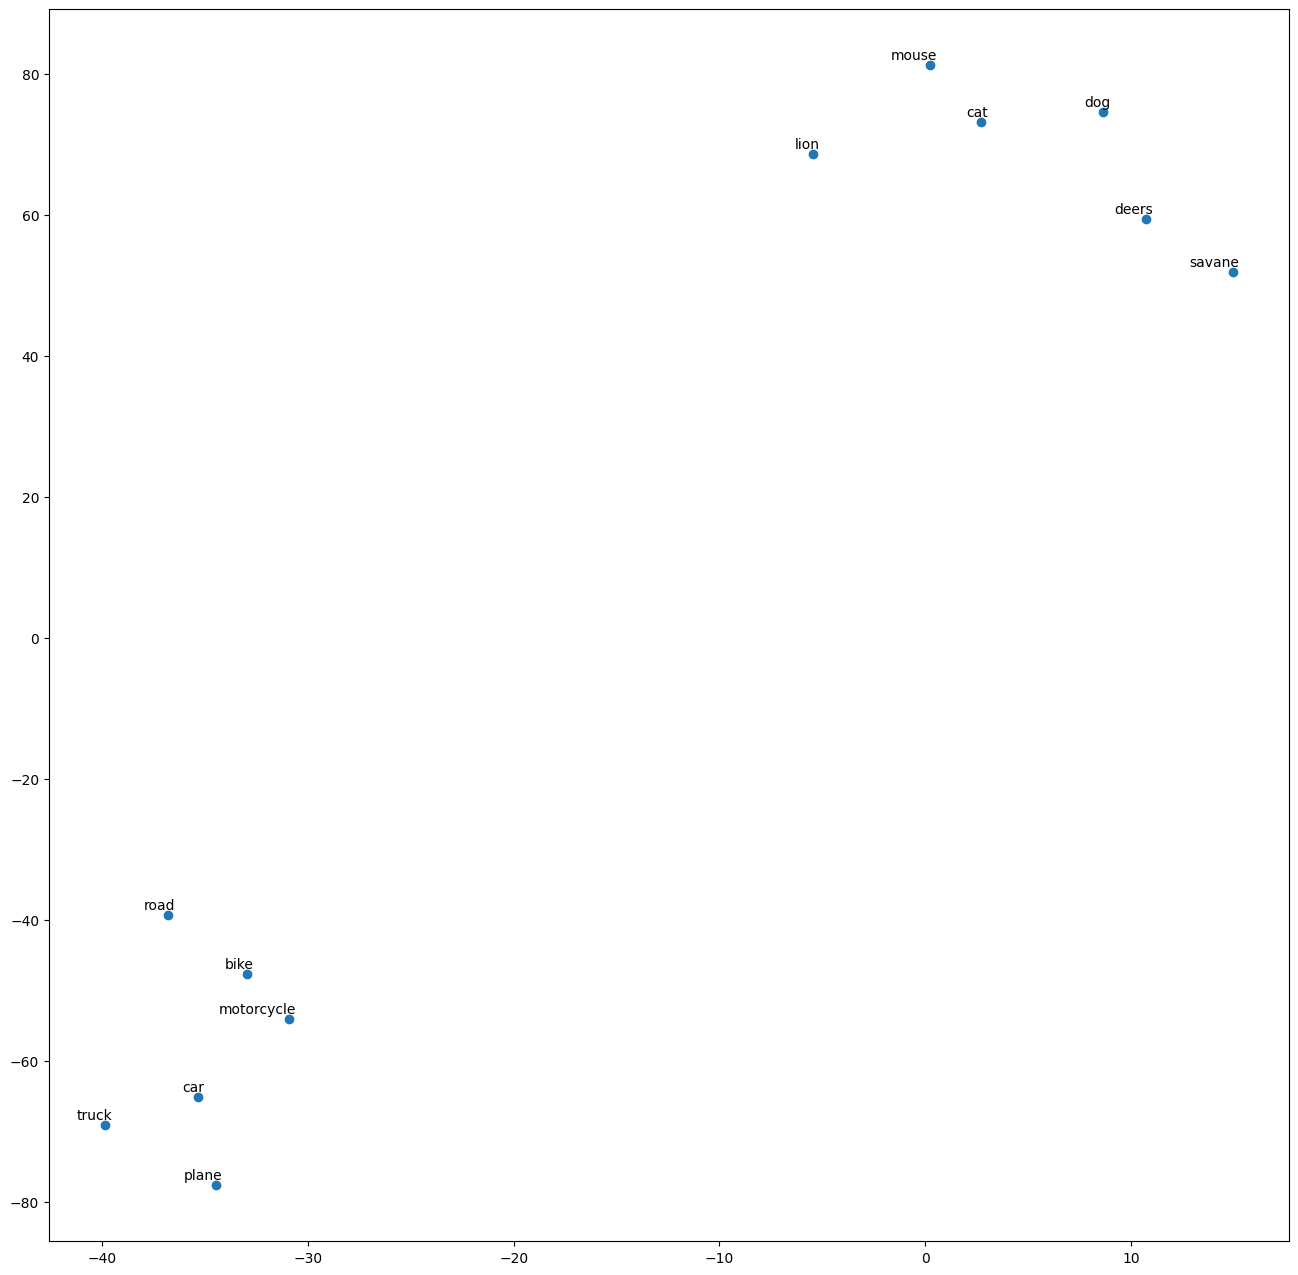

In [224]:
words=['cat','mouse','dog','car','truck','motorcycle','bike','lion','plane','deers', 'savane', 'road']

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# afficher les différents mots en projetant en 2d en essayant de respecter les distances entre les mots T-SNE

def tsne_plot(model, words,n_components=2,perplexity=40):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []
    vocab = model.key_to_index.keys()
    
    for word in words:
        if word in vocab: 
            tokens.append(model[word])
            labels.append(word)
    #print(tokens)
    tsne_model = TSNE(perplexity=perplexity, n_components=n_components, init='pca', max_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(np.array(tokens))
    #print(new_values)
    fig = plt.figure(figsize=(16, 16))
    if n_components==3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(new_values[:,0],new_values[:,1],new_values[:,2],c="r",marker="o")
        for i in range(len(new_values)):
            ax.text(new_values[i][0],new_values[i][1],new_values[i][2],labels[i])
    else:
        plt.scatter(new_values[:,0],new_values[:,1])
        for i in range(len(new_values)):
            plt.annotate(labels[i],
                        xy=(new_values[i][0],new_values[i][1]),
                        xytext=(5, 2),
                        textcoords='offset points',
                        ha='right',
                        va='bottom')
    return new_values,labels

new_values,labels = tsne_plot(embeds,words,n_components=2,perplexity=2)

### Index des Embeddings

Lors de l'établissement de modèles utilisant les embeddings du vocabulaire, il est utile de considérer des indices des mots dans le vocabulaire plutôt que les mots eux mêmes (pour les traiter par exemple dans des tenseurs avant de les remplacer par leurs vecteurs de poids). Ceci se fait dans gensim par l'utilisation des instructions suivantes:  

In [225]:
print(embeds.key_to_index["book"])
print(embeds.index_to_key[539])

# Deux manières equivalentes de recupérer les poids
print(embeds["book"])   # via le mot 
print(embeds.vectors[embeds.key_to_index["book"]]) #via l'index


# taille du vocabulaire: 
print(embeds.vectors.shape)



539
book
[-0.0076543  0.93456   -0.73189   -0.55162    0.76977    0.35925
 -1.1365    -1.1632     0.34214    0.29145   -0.8711     0.9197
 -0.47069   -0.22834    1.4777    -0.81714   -0.17466   -0.51093
 -0.28354    0.23292    0.71832    0.23414    0.49443    0.35483
  0.76889   -1.4374    -1.7457    -0.28994   -0.10156   -0.36959
  2.5502    -1.0581    -0.049416  -0.25524   -0.63303    0.02671
 -0.18733    0.20206   -0.26288   -0.41418    0.83473   -0.14227
 -0.28125    0.098155  -0.17096    0.52408    0.31851   -0.089847
 -0.27223   -0.0088736]
[-0.0076543  0.93456   -0.73189   -0.55162    0.76977    0.35925
 -1.1365    -1.1632     0.34214    0.29145   -0.8711     0.9197
 -0.47069   -0.22834    1.4777    -0.81714   -0.17466   -0.51093
 -0.28354    0.23292    0.71832    0.23414    0.49443    0.35483
  0.76889   -1.4374    -1.7457    -0.28994   -0.10156   -0.36959
  2.5502    -1.0581    -0.049416  -0.25524   -0.63303    0.02671
 -0.18733    0.20206   -0.26288   -0.41418    0.83473   -0

#### Exercice 1 : Similarité de phrases

On souhaite calculer la matrice de similarité de différentes phrases du dataset suivant:




In [226]:
tdf = pd.DataFrame([
    ['the road is straight', 'Y'],
    ['the black cat plays with a ball', 'N'],
    ['a big dog with a ball', 'N'],
    ['dog and cat are together', 'N'],
    ['traffic jam on the 6th road', 'Y'],
    ['white bird on a big tree', 'N'],
    ['a big truck', 'Y'],
    ['two cars crashed', 'Y'],
    ['two deers in a field', 'N'],
    ['I like ridding my bike','Y'],
    ['a lion in the savane','N'],
    ['a motorcycle rides on the road','Y'],
    ['it is a bike, it is not a flamingo', 'Y'], 
    ['it is not a bike, it is a flamingo', 'N'],
    ['a mouse bitten by a cat','N'],
    ['two pigs in the mood','N'],
    ['take a plane is sometimes slower than taking train','Y'],
    ['take the highway','Y']
], columns=['text', 'label'])
tdf

#
#  découper avec ce corpus d'apprentissage (Y classe positive et N classe negative)
#

text label
0                                the road is straight     Y
1                     the black cat plays with a ball     N
2                               a big dog with a ball     N
3                            dog and cat are together     N
4                         traffic jam on the 6th road     Y
5                            white bird on a big tree     N
6                                         a big truck     Y
7                                    two cars crashed     Y
8                                two deers in a field     N
9                              I like ridding my bike     Y
10                               a lion in the savane     N
11                     a motorcycle rides on the road     Y
12                 it is a bike, it is not a flamingo     Y
13                 it is not a bike, it is a flamingo     N
14                            a mouse bitten by a cat     N
15                               two pigs in the mood     N
16  take a plane is sometimes slower than taking t...     Y
17                                   take the highway     Y

Pour chaque phrase, on va moyenner les embeddings de ces mots. Chaque vecteur de phrase sera normalisé (x.norm()). Les phrases pourront être comparées deux à deux par un produit scalaire.

- chaque phrase doit être découpée : ("the", "cat", "is" , "on", "the","bank")
- on définit une fonction getvectors qui à partir de la liste de phrases découpées : moyenne les vecteurs d'embeddings (pensez à utiliser les tenseurs de torch), normalise le resultat et le retourne. On pourra prendre le soin de retirer les stop words de la liste ci-dessous pour améliorer les resultats. 
- on peut ensuite calculer la matrice de similarité qui sera donnée à la fonction visual_similarity_matrix() fournie ci-dessous.

In [227]:
import numpy as np
import gensim
from sklearn.preprocessing import normalize

# Liste des stop words
stop_list = ["in", "a", "is", "the", "it", "on", "with"]

# Fonction pour découper les phrases en mots (robuste, gère la ponctuation)
def getlistwordsentence2(text):
    ret = []
    for sentence in text:
        ret.append([word for word in gensim.utils.tokenize(sentence, lower=True, deacc=True) if word not in stop_list])
    return ret

def getvectors(wordslist, normalize=True):
    vocab = embeds.key_to_index.keys()
    sentences = []
    vectors = []
    for words in wordslist:
        words_filtered = [word for word in words if word not in stop_list and word in vocab]
        if len(words_filtered) == 0:
            # Si aucun mot valide, vecteur nul
            vector = torch.zeros(embeds.vector_size)
        else:
            # Récupérer les embeddings des mots et faire une copie pour qu'ils soient modifiables
            word_vectors = [torch.from_numpy(np.copy(embeds[word])) for word in words_filtered]
            # Moyenne des embeddings
            vector = torch.stack(word_vectors).mean(dim=0)
            if normalize:
                # Normalisation du vecteur
                vector = vector / vector.norm()
        vectors.append(vector)
        sentences.append(" ".join(words))
    x = torch.stack(vectors)
    return x, sentences


print("cat" in embeds.key_to_index)  # Devrait renvoyer True
print("bank" in embeds.key_to_index)  # Devrait renvoyer True

def getSims(x):
    return torch.mm(x, x.T)

# Étapes
text_wordlist = getlistwordsentence2(tdf['text'])
x, sentences = getvectors(text_wordlist, normalize=True)
innerproducts = getSims(x)

# Affichage
print("Liste des mots par phrase :", text_wordlist)
print("Vecteurs des phrases :", x)
print("Matrice de similarité :", innerproducts)


True
True
Liste des mots par phrase : [['road', 'straight'], ['black', 'cat', 'plays', 'ball'], ['big', 'dog', 'ball'], ['dog', 'and', 'cat', 'are', 'together'], ['traffic', 'jam', 'th', 'road'], ['white', 'bird', 'big', 'tree'], ['big', 'truck'], ['two', 'cars', 'crashed'], ['two', 'deers', 'field'], ['i', 'like', 'ridding', 'my', 'bike'], ['lion', 'savane'], ['motorcycle', 'rides', 'road'], ['bike', 'not', 'flamingo'], ['not', 'bike', 'flamingo'], ['mouse', 'bitten', 'by', 'cat'], ['two', 'pigs', 'mood'], ['take', 'plane', 'sometimes', 'slower', 'than', 'taking', 'train'], ['take', 'highway']]
Vecteurs des phrases : tensor([[-1.1732e-01,  1.3151e-01,  4.9436e-02,  1.8232e-02, -4.9698e-02,
         -4.5390e-03, -1.5438e-01,  3.6965e-02,  2.2421e-02, -1.2168e-01,
         -1.9089e-01, -1.3619e-01, -2.7093e-01, -7.3582e-02, -8.3371e-02,
         -3.7438e-02,  6.4854e-02, -7.6205e-02, -1.9868e-01, -6.0244e-02,
         -3.5489e-02, -3.7762e-02, -2.9201e-02,  7.0597e-02,  7.9802e-02,
    

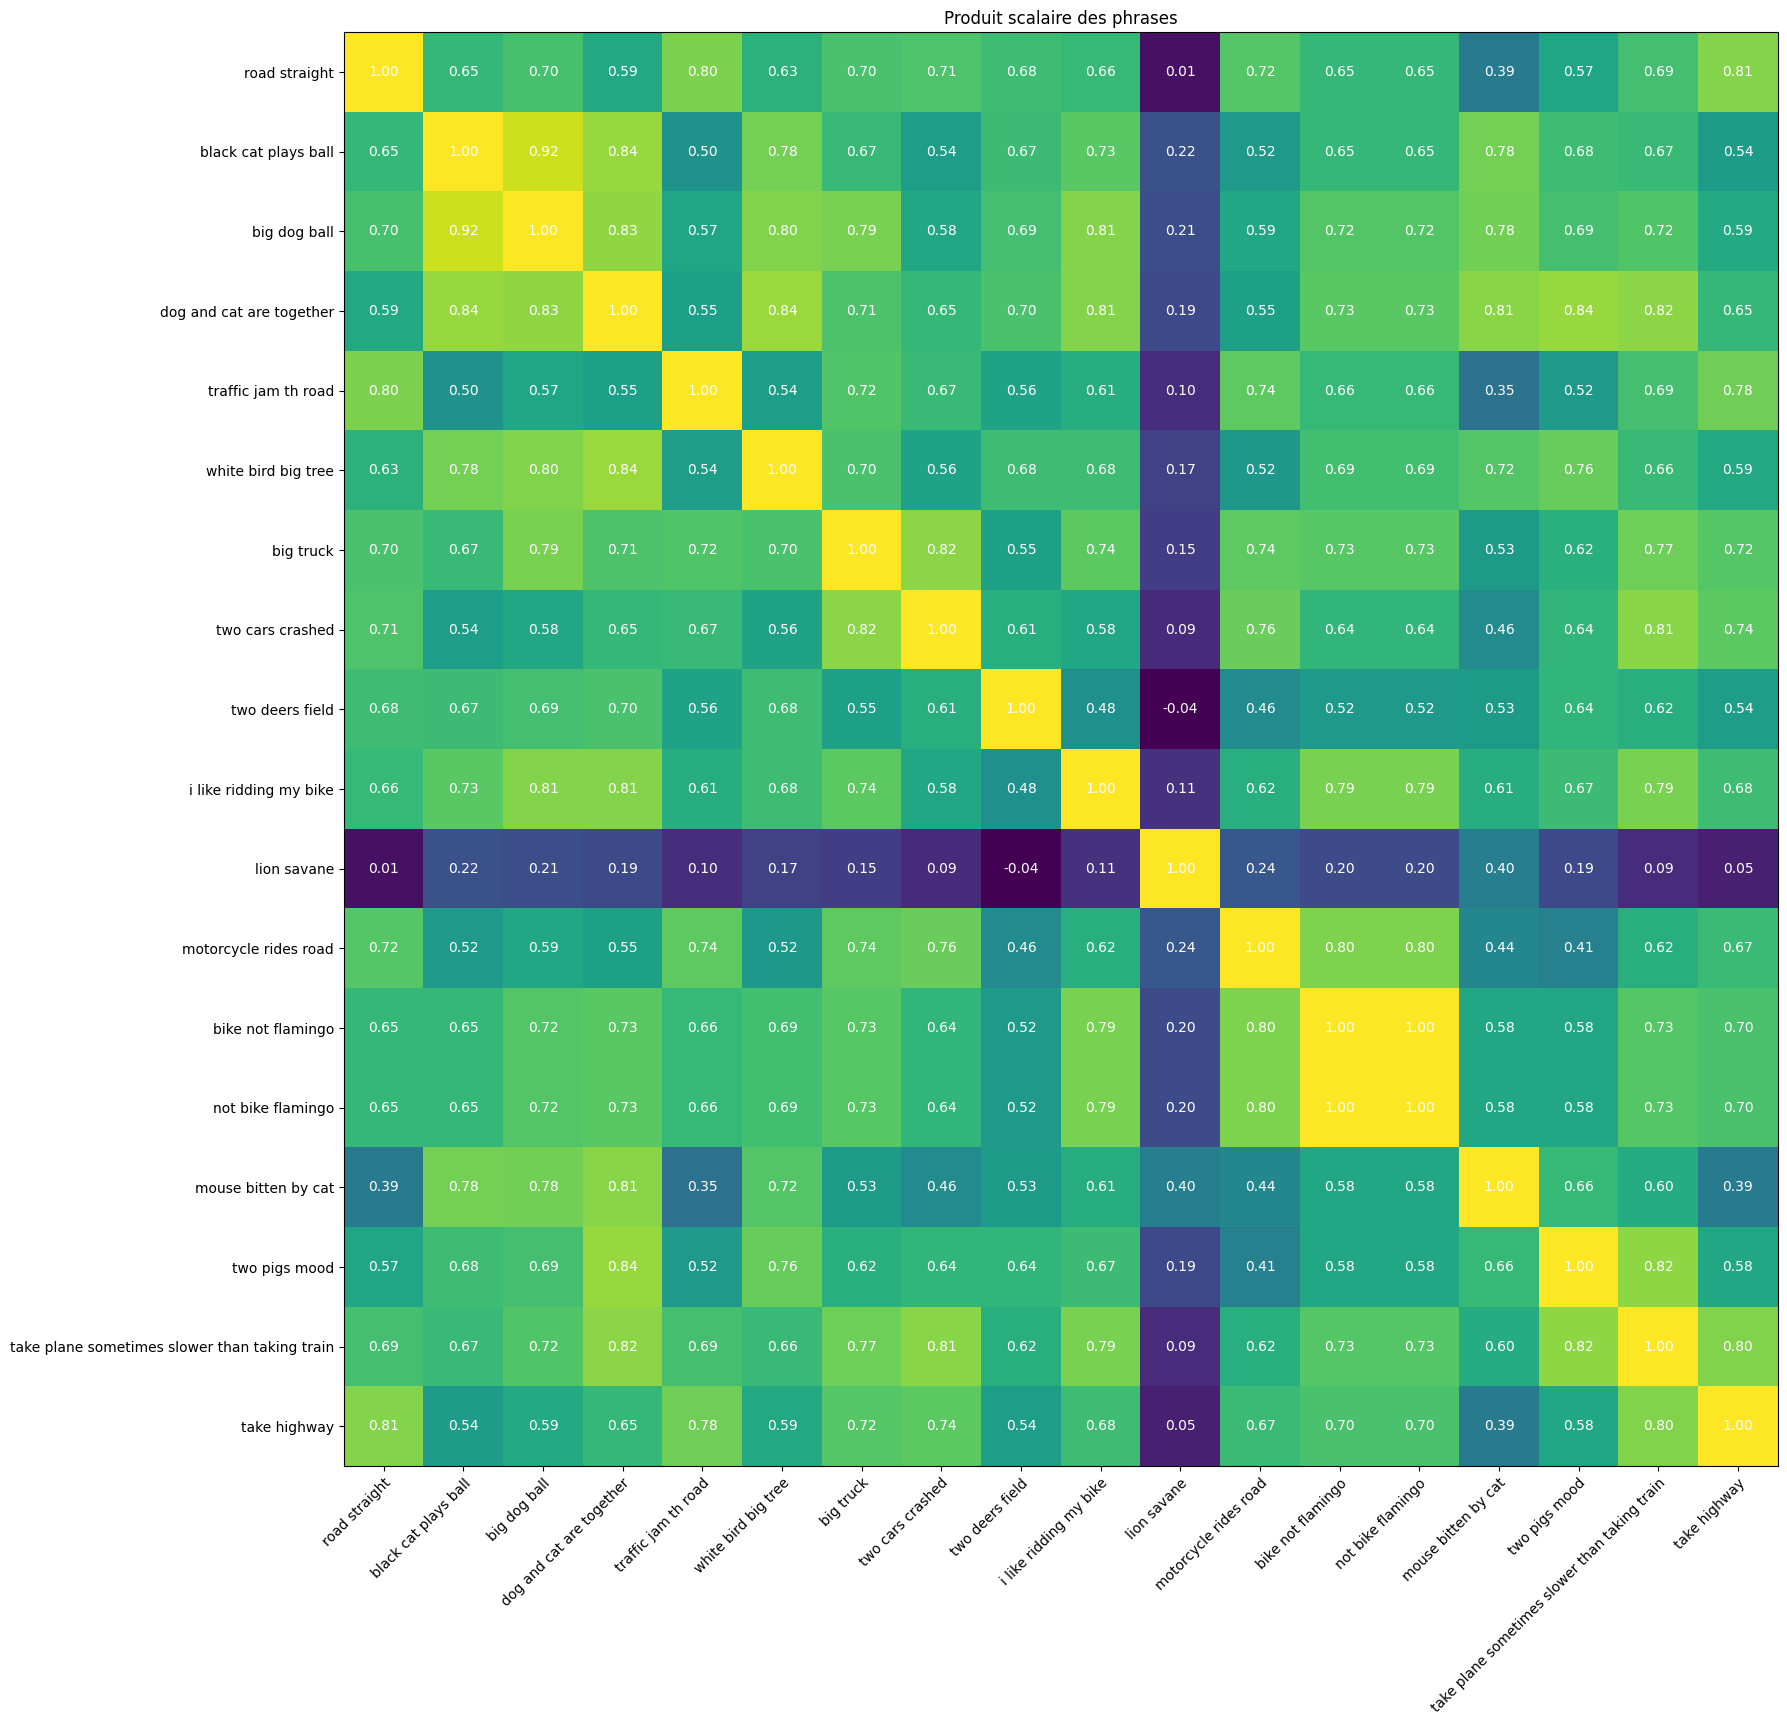

In [228]:
def visual_similarity_matrix(innerproducts):
  fig, ax = plt.subplots()
  #print(innerproducts)
  im = ax.imshow(innerproducts)

  # We want to show all ticks...
  ax.set_xticks(np.arange(len(sentences)))
  ax.set_yticks(np.arange(len(sentences)))
  # ... and label them with the respective list entries
  ax.set_xticklabels(sentences)
  ax.set_yticklabels(sentences)

  # Rotate the tick labels and set their alignment.
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

  # Loop over data dimensions and create text annotations.
  for i in range(len(sentences)):
    for j in range(len(sentences)):
      text = ax.text(j, i, "%.2f" % innerproducts[i, j],
                       ha="center", va="center", color="w")

  
  ax.set_title("Produit scalaire des phrases")
  fig.tight_layout()
  fig.set_size_inches(38.5, 38.5)
  plt.show()

visual_similarity_matrix(np.array(innerproducts.numpy()))

## Utilisation des embeddings pour une tâche de classification

On s'intéresse maintenant à apprendre un classifieur sur les données de l'exemple jouet défini ci dessus. On utilisera le jeu de données suivant comme jeu de validation :



In [229]:
vdf = pd.DataFrame([
    ['the bike drives on the road', 'Y'],
    ['a lion and a cat in a tree', 'N'],
    ['two cars crashed', 'Y'],
    ['i always go to work by bike', 'Y'],
    ['i have no animal at home', 'N'],
    ['dogs like cheese', 'N'], 
    ['a pink flamingo','N'],
    ['trucks','Y'],
    ['truckks','Y'],
    ['truckmegatruck', 'Y'], 
    ['a text about trucks, not animals','Y'], 
    ['a text about animals, not trucks','N'],
    ['doggs','N']
], columns=['text', 'label'])
vdf

text label
0        the bike drives on the road     Y
1         a lion and a cat in a tree     N
2                   two cars crashed     Y
3        i always go to work by bike     Y
4           i have no animal at home     N
5                   dogs like cheese     N
6                    a pink flamingo     N
7                             trucks     Y
8                            truckks     Y
9                     truckmegatruck     Y
10  a text about trucks, not animals     Y
11  a text about animals, not trucks     N
12                             doggs     N

La première étape  consiste à transformer les données (label numérique, tokenization, construction d'un batch.)

In [230]:
import datasets
from datasets import Dataset, DatasetDict

train_dataset = Dataset.from_pandas(tdf)
validation_dataset = Dataset.from_pandas(vdf)
print(train_dataset,validation_dataset)
print(train_dataset["text"])

# Creation d'un index de padding pour les positions a ignorer par le modèle (e.g., mots inconnus)
pad_idx=embeds.vectors.shape[0]



def preprocess_function(examples):
    vocab=embeds.key_to_index
    inputs= getlistwordsentence2(examples["text"])
    
    inputs = [[(vocab[word] if word in vocab else pad_idx) for word in sentence] for sentence in inputs] 
    
    labels = [(1 if l=='Y' else 0) for l in examples["label"]] 
    ret = {}
    ret["input_ids"]=inputs
    ret["labels"]=labels
    #print(ret)
    return ret


train_dataset = train_dataset.map(preprocess_function, batched=True, remove_columns=train_dataset.features.keys(), load_from_cache_file=True)
print(train_dataset)
print(train_dataset["input_ids"])
validation_dataset = validation_dataset.map(preprocess_function, batched=True, remove_columns=validation_dataset.features.keys(), load_from_cache_file=True)
print(validation_dataset)
print(validation_dataset["input_ids"])

Dataset({
    features: ['text', 'label'],
    num_rows: 18
}) Dataset({
    features: ['text', 'label'],
    num_rows: 13
})
['the road is straight', 'the black cat plays with a ball', 'a big dog with a ball', 'dog and cat are together', 'traffic jam on the 6th road', 'white bird on a big tree', 'a big truck', 'two cars crashed', 'two deers in a field', 'I like ridding my bike', 'a lion in the savane', 'a motorcycle rides on the road', 'it is a bike, it is not a flamingo', 'it is not a bike, it is a flamingo', 'a mouse bitten by a cat', 'two pigs in the mood', 'take a plane is sometimes slower than taking train', 'take the highway']


Map: 100%|██████████| 18/18 [00:00<00:00, 6685.93 examples/s]


Dataset({
    features: ['input_ids', 'labels'],
    num_rows: 18
})
[[586, 1362], [521, 5450, 1381, 1083], [365, 2926, 1083], [2926, 5, 5450, 32, 600], [1596, 8202, 14358, 586], [298, 2632, 365, 2654], [365, 2575], [55, 1277, 3732], [55, 134183, 610], [41, 117, 40085, 192, 7696], [6657, 232439], [7213, 9371, 586], [7696, 36, 35115], [36, 7696, 35115], [7571, 22022, 21, 5450], [55, 9609, 5030], [190, 1313, 1071, 6914, 73, 582, 1470], [190, 1883]]


Map: 100%|██████████| 13/13 [00:00<00:00, 6313.07 examples/s]

Dataset({
    features: ['input_ids', 'labels'],
    num_rows: 13
})
[[7696, 5919, 586], [6657, 5, 5450, 2654], [55, 1277, 3732], [41, 690, 242, 4, 161, 21, 7696], [41, 33, 84, 2694, 22, 163], [3876, 117, 5795], [5491, 35115], [3597], [400000], [400000], [2829, 59, 3597, 36, 2430], [2829, 59, 2430, 36, 3597], [400000]]


In [231]:
#import transformers
#from transformers import DataCollatorForSeq2Seq
#import transformers.DataCollatorForSeq2Seq
from torch.utils.data import DataLoader
from transformers.trainer_pt_utils import LengthGroupedSampler,Sampler,get_length_grouped_indices
#import numpy as np 

batchsize=4
megabatch_mul=16


# Un sampler permet de générer les batchs en selectionnant des indices d'échantillons de manière aléatoire
# dans les données d'entrée
# Ici on souhaite minimiser le padding, donc on choisit de regrouper au maximum les sequences par longueur 
# dans les batchs
# C'est fait selon les étapes suivantes :  
#     1 - Tirage d'une permutation des indices de manière aléatoire
#     2 - Découpage de la liste en megabatchs de taille batch_size*megabatch_mul
#     3 - Tri des éléments par ordre de longueur déscendante à l'intérieur de chaque megabatch
#     4 - Concaténation des listes d'indices retriées localement 
#     5 - Découpage en batch de taille batchsize
#
# Ainsi:
#     - si megabatch_mul trop grand, alors aucun aléatoire (ce qui peu être gênant pour l'apprentissage dans certains cas)
#                                   ==> les batchs seront toujours les mêmes (données triées par longueur, minimisation optimale du padding)
#     - si megabatch_mul trop petit (e.g. = 1), alors batchs complètement aléatoires (séquences simplement ordonnées à l'intérieur du batch, pas d'optimisation sur la minimisation du padding) 
#                                   ==> beaucoup de padding possible (rajoute de la complexité à l'apprentissage)
#
# Il s'agit de trouver un bon compromis, jouer en tp avec les valeurs de megabatch_mul et observer les effets
class LengthGroupedSampler(Sampler):
    r"""
    Sampler that samples indices in a way that groups together features of the dataset of roughly the same length while
    keeping a bit of randomness.
    """

    def __init__(self,batch_size,dataset, megabatch_mul=None):
        self.batch_size = batch_size
        lengths = [len(sample["input_ids"]) for sample in dataset]
        self.lengths = lengths
        self.megabatch_mul=megabatch_mul

    def __len__(self):
        return len(self.lengths)

    def __iter__(self):
        indices = get_length_grouped_indices(self.lengths, self.batch_size, self.megabatch_mul)
        return iter(indices)

    
# Fonction qui produit des tenseurs pytorch a partir d'un batch de données issu du sampler
#
# ici on crée deux tenseurs par batch :
#         - un tenseur pour les labels
#         - un tenseur pour les index de mots des séquences, complétées avec l'idex de padding pad_idx pour les séquences plus courtes (afin d'avoir des données de même taille sur chaque ligne du tenseur, ce qui est requis pour leur création) 
def data_collator(batch):
    first = batch[0]
    ret = {}
    dtype = torch.long if type(first["labels"]) is int else torch.float
    ret["labels"] = torch.tensor([f["labels"] for f in batch], dtype=dtype)
    longest=max([len(l["input_ids"]) for l in batch])
    s = np.stack([np.pad(x["input_ids"], (0, longest - len(x["input_ids"])), constant_values=pad_idx) for x in batch])
    #print(type(s))
    ret["input_ids"] = torch.from_numpy(s) #torch.tensor(s)
    return ret


train_sampler = LengthGroupedSampler(batchsize, train_dataset, megabatch_mul)

train_loader=DataLoader(train_dataset,batchsize,sampler=train_sampler,collate_fn=data_collator,pin_memory=True, shuffle=False, num_workers=0)

for data in train_loader:
    print(data)

test_sampler = LengthGroupedSampler(batchsize, validation_dataset, megabatch_mul)    
    
test_loader=DataLoader(validation_dataset,batchsize,sampler=test_sampler,collate_fn=data_collator,pin_memory=True, shuffle=False, num_workers=0)


for data in test_loader:
    print(data)
    


    


{'labels': tensor([1, 0, 1, 1]), 'input_ids': tensor([[   190,   1313,   1071,   6914,     73,    582,   1470],
        [  2926,      5,   5450,     32,    600, 400000, 400000],
        [    41,    117,  40085,    192,   7696, 400000, 400000],
        [  1596,   8202,  14358,    586, 400000, 400000, 400000]])}
{'labels': tensor([0, 0, 0, 0]), 'input_ids': tensor([[   298,   2632,    365,   2654],
        [   521,   5450,   1381,   1083],
        [  7571,  22022,     21,   5450],
        [   365,   2926,   1083, 400000]])}
{'labels': tensor([0, 1, 1, 0]), 'input_ids': tensor([[   36,  7696, 35115],
        [ 7696,    36, 35115],
        [   55,  1277,  3732],
        [   55,  9609,  5030]])}
{'labels': tensor([0, 1, 1, 1]), 'input_ids': tensor([[    55, 134183,    610],
        [  7213,   9371,    586],
        [   586,   1362, 400000],
        [   365,   2575, 400000]])}
{'labels': tensor([1, 0]), 'input_ids': tensor([[   190,   1883],
        [  6657, 232439]])}
{'labels': tensor([1, 

In [232]:
### On peut créer une fonction de décodage des batchs
def batch_decode(input_ids):
    x=input_ids.data
    x=[" ".join([embeds.index_to_key[i] for i in s if i!=pad_idx]) for s in x]
    return x

for data in test_loader:
    print(data)
    print(batch_decode(data["input_ids"]))


{'labels': tensor([1, 0, 0, 1]), 'input_ids': tensor([[    41,    690,    242,      4,    161,     21,   7696],
        [    41,     33,     84,   2694,     22,    163, 400000],
        [  2829,     59,   2430,     36,   3597, 400000, 400000],
        [  2829,     59,   3597,     36,   2430, 400000, 400000]])}
['i always go to work by bike', 'i have no animal at home', 'text about animals not trucks', 'text about trucks not animals']
{'labels': tensor([0, 0, 1, 1]), 'input_ids': tensor([[  6657,      5,   5450,   2654],
        [  3876,    117,   5795, 400000],
        [    55,   1277,   3732, 400000],
        [  7696,   5919,    586, 400000]])}
['lion and cat tree', 'dogs like cheese', 'two cars crashed', 'bike drives road']
{'labels': tensor([0, 1, 0, 1]), 'input_ids': tensor([[  5491,  35115],
        [400000, 400000],
        [400000, 400000],
        [  3597, 400000]])}
['pink flamingo', '', '', 'trucks']
{'labels': tensor([1]), 'input_ids': tensor([[400000]])}
['']


On note que le dernier texte "truckmegatruck" est décodé sous la chaîne vide: il ne contient que des mots inconnus, donc ignorés... 

### Modèle de classifcation simple

On construit ensuite le modèle de classification avec torch. La couche d'entrée correspond aux embeddings, implémentés par nn.Embedding(). nn.Embedding() permet de construire la matrice d'embeddings sur l'ensemble du vocabulaire. Ils sont ensuite "activés" en fonction du texte d'entrée. Le modèle à construire fait une simple moyenne des embeddings des mots des textes, applique une activation tanh et envoie le resultat à travers un Linear à deux sorties. Penser à indiquer l'index de padding à la construction de nn.Embedding, car çà permet de ne pas les prendre en compte dans les calculs de gradients (et de conserver ces embeddings vides à zeros pour ne pas en dépendre => invariance par rapport à la longueur). Penser aussi à ajouter de la l2 sur les embeddings (très importants pour que les représentations ne s'éparpillent pas aux confins de l'espace de représentation!). On pourra aussi ajouter du Dropout. 

In [233]:
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

class MyModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, pad_idx, dropout=0):
        super(MyModel, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim, padding_idx=pad_idx)
        self.embedding.weight.data.copy_(torch.zeros_like(self.embedding.weight))
        self.embedding.weight.requires_grad = False  # Si vous ne voulez pas ajuster les embeddings
        self.dropout = nn.Dropout(p=dropout)
        self.tanh = nn.Tanh()
        self.fc = nn.Linear(embed_dim, 2)
    
    def forward(self, x):
        embeddings = self.embedding(x)  # (batch_size, seq_length, embed_dim)
        embeddings = self.dropout(embeddings)
        mask = (x != self.embedding.padding_idx).unsqueeze(-1).float()
        embeddings = embeddings * mask
        summed = embeddings.sum(dim=1)
        lengths = mask.sum(dim=1)
        epsilon = 1e-8
        averaged = summed / (lengths + epsilon)
        activated = self.tanh(averaged)
        output = self.fc(activated)
        return output



On entraîne et teste le modèle.

In [234]:
def train_test(train_iter, test_iter, model, loss_function, optimizer, epochs, clip=-1):
  for epoch in range(epochs):
      epoch_loss = 0
      epoch_accuracy = 0
      model.train()
      nb_samples=0
      for batch in train_iter:
          optimizer.zero_grad()
          #print("text shape ",batch.text.T.shape)
          prediction = model(batch["input_ids"])
          if not isinstance(prediction,torch.Tensor):  
                prediction = prediction["logits"]
          #print(prediction)
          loss = loss_function(prediction, batch["labels"])

          loss.backward()
          if clip>0:
              torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
          optimizer.step()
          nb_samples+=prediction.shape[0]
          epoch_loss+=loss.item()*prediction.shape[0]
          preds=(prediction[:,1]>prediction[:,0])*1.0
          accuracy=(preds==batch["labels"]).sum()
          epoch_accuracy+=accuracy.item()
      if epoch%100==0:
          print('train loss on epoch {} : {:.3f}'.format(epoch, epoch_loss/nb_samples))
          print('train accuracy on epoch {}: {:.3f}'.format(epoch, epoch_accuracy/nb_samples))
          
      model.eval()
      test_loss = 0
      test_accuracy = 0
      nb_samples=0
      accuracy=0
      for batch in test_iter:
          #print("test ",batch)
          with torch.no_grad():
              optimizer.zero_grad()
                
              prediction = model(batch["input_ids"])
              if not isinstance(prediction,torch.Tensor):
                    prediction = prediction["logits"]
              loss = loss_function(prediction, batch["labels"])
              nb_samples+=prediction.shape[0]
              test_loss+=loss.item()*prediction.shape[0]
              #print(batch_decode(batch["input_ids"]))
              preds=(prediction[:,1]>prediction[:,0])*1.0
              accuracy=(preds==batch["labels"]).sum()
              test_accuracy+=accuracy.item()  
              #print(preds,accuracy)
      print('test loss on epoch {}: {:.3f}'.format(epoch, test_loss/nb_samples))
      print('test accuracy on epoch {}: {:.3f}'.format(epoch, test_accuracy/nb_samples))



In [242]:
vocab_size = embeds.vectors.shape[0] + 1  
embed_dim = embeds.vector_size 
net = MyModel(vocab_size, embed_dim, pad_idx, dropout=0.2)

weights = torch.FloatTensor(embeds.vectors)
pad_embedding = torch.zeros(1, embed_dim)
weights = torch.cat((weights, pad_embedding), dim=0)

net.embedding.weight.data = weights
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(net.parameters(), lr=0.01, weight_decay=0.02)
epochs = 1500
train_test(train_loader, test_loader, net, loss_function, optimizer, epochs)

train loss on epoch 0 : 0.620
train accuracy on epoch 0: 0.611
test loss on epoch 0: 0.565
test accuracy on epoch 0: 0.769
train loss on epoch 1 : 0.497
train accuracy on epoch 1: 0.889
test loss on epoch 1: 0.502
test accuracy on epoch 1: 0.846
train loss on epoch 2 : 0.387
train accuracy on epoch 2: 0.944
test loss on epoch 2: 0.462
test accuracy on epoch 2: 0.846
train loss on epoch 3 : 0.347
train accuracy on epoch 3: 0.944
test loss on epoch 3: 0.431
test accuracy on epoch 3: 0.846
train loss on epoch 4 : 0.299
train accuracy on epoch 4: 0.944
test loss on epoch 4: 0.409
test accuracy on epoch 4: 0.846
train loss on epoch 5 : 0.265
train accuracy on epoch 5: 0.944
test loss on epoch 5: 0.394
test accuracy on epoch 5: 0.846
train loss on epoch 6 : 0.260
train accuracy on epoch 6: 0.944
test loss on epoch 6: 0.384
test accuracy on epoch 6: 0.846
train loss on epoch 7 : 0.252
train accuracy on epoch 7: 0.944
test loss on epoch 7: 0.377
test accuracy on epoch 7: 0.846
train loss on ep

In [236]:
def predict(sentence,model):
    examples={}
    examples["text"]=[sentence]
    examples["label"]=["Y"]
    data=preprocess_function(examples)
    #print(data)
    data=data_collator([data])
    #print(data["input_ids"])
    model.eval()
    with torch.no_grad():
        prediction = model(data["input_ids"][0])
        if not isinstance(prediction,torch.Tensor):
            prediction = prediction["logits"]
        preds=(prediction[:,1]>prediction[:,0])*1.0
    return {"logits":prediction,"prediction":preds}
    
def predict_from_pandas(datap,net):
    data=Dataset.from_pandas(vdf)
    accuracy=0
    size=len(data["text"])
    for i in range(size):
        s=data["text"][i]
        l=data["label"][i]
        l=(1 if l=='Y' else 0)
        p=predict(s,net)
        print(s,p, "truth=",l)
        accuracy+=(p["prediction"]==l)
    return accuracy/size

print(predict_from_pandas(vdf,net))
    

the bike drives on the road {'logits': tensor([[-3.1626,  3.0625]]), 'prediction': tensor([1.])} truth= 1
a lion and a cat in a tree {'logits': tensor([[ 1.8934, -2.0299]]), 'prediction': tensor([0.])} truth= 0
two cars crashed {'logits': tensor([[-2.3952,  2.3144]]), 'prediction': tensor([1.])} truth= 1
i always go to work by bike {'logits': tensor([[-0.9481,  0.8928]]), 'prediction': tensor([1.])} truth= 1
i have no animal at home {'logits': tensor([[ 0.0918, -0.1619]]), 'prediction': tensor([0.])} truth= 0
dogs like cheese {'logits': tensor([[ 1.3661, -1.4632]]), 'prediction': tensor([0.])} truth= 0
a pink flamingo {'logits': tensor([[ 2.1818, -2.3541]]), 'prediction': tensor([0.])} truth= 0
trucks {'logits': tensor([[-2.9350,  2.8636]]), 'prediction': tensor([1.])} truth= 1
truckks {'logits': tensor([[ 0.1986, -0.2468]]), 'prediction': tensor([0.])} truth= 1
truckmegatruck {'logits': tensor([[ 0.1986, -0.2468]]), 'prediction': tensor([0.])} truth= 1
a text about trucks, not animals

On observe beaucoup de sur-apprentissage. Normal étant donné la taille du corpus d'apprentissage...


### Même modèle mais avec des embeddings pré-entraînés

 Voyons ce que celà donne avec les représentations pre-entrainées (que l'on freeze) 

#### Méthode 1 : directement fournir les embeddings construits à partir du vocab

In [237]:

#[[Answer 
# net = ...
# weights=
#/Answer]]

net.embedding.weight.data=weights   # on charge les pre-train 
net.embedding.weight.requires_grad=False  # on freeze
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(net.parameters(), lr=0.01,weight_decay=0.0)
epochs = 5000

train_test(train_loader, test_loader, net, loss_function, optimizer, epochs,clip=1)


train loss on epoch 0 : 0.185
train accuracy on epoch 0: 0.944
test loss on epoch 0: 0.350
test accuracy on epoch 0: 0.769
train loss on epoch 1 : 0.149
train accuracy on epoch 1: 0.944
test loss on epoch 1: 0.348
test accuracy on epoch 1: 0.769
train loss on epoch 2 : 0.240
train accuracy on epoch 2: 0.889
test loss on epoch 2: 0.347
test accuracy on epoch 2: 0.769
train loss on epoch 3 : 0.172
train accuracy on epoch 3: 0.889
test loss on epoch 3: 0.347
test accuracy on epoch 3: 0.769
train loss on epoch 4 : 0.217
train accuracy on epoch 4: 0.944
test loss on epoch 4: 0.347
test accuracy on epoch 4: 0.769
train loss on epoch 5 : 0.169
train accuracy on epoch 5: 0.944
test loss on epoch 5: 0.347
test accuracy on epoch 5: 0.769
train loss on epoch 6 : 0.165
train accuracy on epoch 6: 0.889
test loss on epoch 6: 0.347
test accuracy on epoch 6: 0.769
train loss on epoch 7 : 0.273
train accuracy on epoch 7: 0.889
test loss on epoch 7: 0.347
test accuracy on epoch 7: 0.769
train loss on ep

KeyboardInterrupt: 

#### Méthode 2 : avec la méthode nn.Embedding.from_pretrained()

nn.Embedding permet d'importer directement une matrice de poids (embeddings pré-entraînés) grâce à la méthode from_pretrained() :  
```
weight = torch.FloatTensor([[1, 2.3, 3], [4, 5.1, 6.3]])
embedding = nn.Embedding.from_pretrained(weight)
```
Plus particulièrement, la matrice de poids correspond à notre élément vocab.vectors qui va permettre d'initialiser la matrice d'embeddings.

Par défaut, les embeddings sont "gelés" : ils ne sont pas modifiés avec la backpropagation, mais il est possible de les modifier avec le paramètre freeze=False. Cela revient à "fine-tuner" les embeddings sur la tâche.

In [472]:
#[[Answer 
#net = 
#weights=
#net.embedding=   # on charge les pre-train (en supposant que le module Embedding du modèle soit dans une variable embeddings)
#/Answer]]

loss_function = nn.CrossEntropyLoss()
optimizer = Adam(net.parameters(), lr=0.01,weight_decay=0.0)
epochs = 5000
train_test(train_loader, test_loader, net, loss_function, optimizer, epochs)



train loss on epoch 0 : 0.651
train accuracy on epoch 0: 0.588
test loss on epoch 0: 0.615
test accuracy on epoch 0: 0.769
train loss on epoch 1 : 0.591
train accuracy on epoch 1: 0.824
test loss on epoch 1: 0.578
test accuracy on epoch 1: 0.769
train loss on epoch 2 : 0.498
train accuracy on epoch 2: 0.941
test loss on epoch 2: 0.553
test accuracy on epoch 2: 0.769
train loss on epoch 3 : 0.470
train accuracy on epoch 3: 0.824
test loss on epoch 3: 0.524
test accuracy on epoch 3: 0.769
train loss on epoch 4 : 0.488
train accuracy on epoch 4: 0.824
test loss on epoch 4: 0.493
test accuracy on epoch 4: 0.769
train loss on epoch 5 : 0.373
train accuracy on epoch 5: 0.941
test loss on epoch 5: 0.495
test accuracy on epoch 5: 0.769
train loss on epoch 6 : 0.325
train accuracy on epoch 6: 1.000
test loss on epoch 6: 0.467
test accuracy on epoch 6: 0.769
train loss on epoch 7 : 0.409
train accuracy on epoch 7: 0.882
test loss on epoch 7: 0.462
test accuracy on epoch 7: 0.769
train loss on ep

test loss on epoch 70: 0.343
test accuracy on epoch 70: 0.846
train loss on epoch 71 : 0.086
train accuracy on epoch 71: 0.941
test loss on epoch 71: 0.345
test accuracy on epoch 71: 0.769
train loss on epoch 72 : 0.112
train accuracy on epoch 72: 1.000
test loss on epoch 72: 0.339
test accuracy on epoch 72: 0.769
train loss on epoch 73 : 0.050
train accuracy on epoch 73: 1.000
test loss on epoch 73: 0.343
test accuracy on epoch 73: 0.769
train loss on epoch 74 : 0.071
train accuracy on epoch 74: 1.000
test loss on epoch 74: 0.352
test accuracy on epoch 74: 0.769
train loss on epoch 75 : 0.072
train accuracy on epoch 75: 1.000
test loss on epoch 75: 0.351
test accuracy on epoch 75: 0.769
train loss on epoch 76 : 0.058
train accuracy on epoch 76: 1.000
test loss on epoch 76: 0.346
test accuracy on epoch 76: 0.769
train loss on epoch 77 : 0.073
train accuracy on epoch 77: 1.000
test loss on epoch 77: 0.355
test accuracy on epoch 77: 0.769
train loss on epoch 78 : 0.058
train accuracy on 

train loss on epoch 138 : 0.012
train accuracy on epoch 138: 1.000
test loss on epoch 138: 0.335
test accuracy on epoch 138: 0.769
train loss on epoch 139 : 0.042
train accuracy on epoch 139: 1.000
test loss on epoch 139: 0.353
test accuracy on epoch 139: 0.769
train loss on epoch 140 : 0.064
train accuracy on epoch 140: 1.000
test loss on epoch 140: 0.343
test accuracy on epoch 140: 0.769
train loss on epoch 141 : 0.044
train accuracy on epoch 141: 1.000
test loss on epoch 141: 0.363
test accuracy on epoch 141: 0.769
train loss on epoch 142 : 0.039
train accuracy on epoch 142: 1.000
test loss on epoch 142: 0.363
test accuracy on epoch 142: 0.769
train loss on epoch 143 : 0.118
train accuracy on epoch 143: 0.941
test loss on epoch 143: 0.370
test accuracy on epoch 143: 0.769
train loss on epoch 144 : 0.009
train accuracy on epoch 144: 1.000
test loss on epoch 144: 0.372
test accuracy on epoch 144: 0.769
train loss on epoch 145 : 0.044
train accuracy on epoch 145: 1.000
test loss on epo

test loss on epoch 207: 0.352
test accuracy on epoch 207: 0.769
train loss on epoch 208 : 0.026
train accuracy on epoch 208: 1.000
test loss on epoch 208: 0.326
test accuracy on epoch 208: 0.846
train loss on epoch 209 : 0.071
train accuracy on epoch 209: 0.941
test loss on epoch 209: 0.317
test accuracy on epoch 209: 0.846
train loss on epoch 210 : 0.017
train accuracy on epoch 210: 1.000
test loss on epoch 210: 0.319
test accuracy on epoch 210: 0.846
train loss on epoch 211 : 0.022
train accuracy on epoch 211: 1.000
test loss on epoch 211: 0.317
test accuracy on epoch 211: 0.846
train loss on epoch 212 : 0.028
train accuracy on epoch 212: 1.000
test loss on epoch 212: 0.318
test accuracy on epoch 212: 0.846
train loss on epoch 213 : 0.043
train accuracy on epoch 213: 1.000
test loss on epoch 213: 0.317
test accuracy on epoch 213: 0.846
train loss on epoch 214 : 0.017
train accuracy on epoch 214: 1.000
test loss on epoch 214: 0.319
test accuracy on epoch 214: 0.846
train loss on epoch

test loss on epoch 274: 0.302
test accuracy on epoch 274: 0.846
train loss on epoch 275 : 0.011
train accuracy on epoch 275: 1.000
test loss on epoch 275: 0.302
test accuracy on epoch 275: 0.846
train loss on epoch 276 : 0.141
train accuracy on epoch 276: 0.941
test loss on epoch 276: 0.289
test accuracy on epoch 276: 0.846
train loss on epoch 277 : 0.021
train accuracy on epoch 277: 1.000
test loss on epoch 277: 0.294
test accuracy on epoch 277: 0.846
train loss on epoch 278 : 0.040
train accuracy on epoch 278: 1.000
test loss on epoch 278: 0.285
test accuracy on epoch 278: 0.846
train loss on epoch 279 : 0.049
train accuracy on epoch 279: 1.000
test loss on epoch 279: 0.290
test accuracy on epoch 279: 0.846
train loss on epoch 280 : 0.020
train accuracy on epoch 280: 1.000
test loss on epoch 280: 0.306
test accuracy on epoch 280: 0.846
train loss on epoch 281 : 0.040
train accuracy on epoch 281: 1.000
test loss on epoch 281: 0.302
test accuracy on epoch 281: 0.846
train loss on epoch

train loss on epoch 345 : 0.006
train accuracy on epoch 345: 1.000
test loss on epoch 345: 0.295
test accuracy on epoch 345: 0.846
train loss on epoch 346 : 0.013
train accuracy on epoch 346: 1.000
test loss on epoch 346: 0.295
test accuracy on epoch 346: 0.846
train loss on epoch 347 : 0.016
train accuracy on epoch 347: 1.000
test loss on epoch 347: 0.297
test accuracy on epoch 347: 0.846
train loss on epoch 348 : 0.044
train accuracy on epoch 348: 1.000
test loss on epoch 348: 0.307
test accuracy on epoch 348: 0.846
train loss on epoch 349 : 0.011
train accuracy on epoch 349: 1.000
test loss on epoch 349: 0.297
test accuracy on epoch 349: 0.846
train loss on epoch 350 : 0.034
train accuracy on epoch 350: 1.000
test loss on epoch 350: 0.301
test accuracy on epoch 350: 0.846
train loss on epoch 351 : 0.030
train accuracy on epoch 351: 1.000
test loss on epoch 351: 0.314
test accuracy on epoch 351: 0.846
train loss on epoch 352 : 0.012
train accuracy on epoch 352: 1.000
test loss on epo

train loss on epoch 414 : 0.011
train accuracy on epoch 414: 1.000
test loss on epoch 414: 0.309
test accuracy on epoch 414: 0.846
train loss on epoch 415 : 0.013
train accuracy on epoch 415: 1.000
test loss on epoch 415: 0.306
test accuracy on epoch 415: 0.846
train loss on epoch 416 : 0.076
train accuracy on epoch 416: 1.000
test loss on epoch 416: 0.317
test accuracy on epoch 416: 0.846
train loss on epoch 417 : 0.021
train accuracy on epoch 417: 1.000
test loss on epoch 417: 0.330
test accuracy on epoch 417: 0.846
train loss on epoch 418 : 0.005
train accuracy on epoch 418: 1.000
test loss on epoch 418: 0.363
test accuracy on epoch 418: 0.846
train loss on epoch 419 : 0.009
train accuracy on epoch 419: 1.000
test loss on epoch 419: 0.369
test accuracy on epoch 419: 0.846
train loss on epoch 420 : 0.007
train accuracy on epoch 420: 1.000
test loss on epoch 420: 0.367
test accuracy on epoch 420: 0.846
train loss on epoch 421 : 0.011
train accuracy on epoch 421: 1.000
test loss on epo

train loss on epoch 484 : 0.005
train accuracy on epoch 484: 1.000
test loss on epoch 484: 0.293
test accuracy on epoch 484: 0.846
train loss on epoch 485 : 0.035
train accuracy on epoch 485: 1.000
test loss on epoch 485: 0.296
test accuracy on epoch 485: 0.846
train loss on epoch 486 : 0.013
train accuracy on epoch 486: 1.000
test loss on epoch 486: 0.284
test accuracy on epoch 486: 0.846
train loss on epoch 487 : 0.183
train accuracy on epoch 487: 0.941
test loss on epoch 487: 0.305
test accuracy on epoch 487: 0.846
train loss on epoch 488 : 0.043
train accuracy on epoch 488: 1.000
test loss on epoch 488: 0.308
test accuracy on epoch 488: 0.846
train loss on epoch 489 : 0.013
train accuracy on epoch 489: 1.000
test loss on epoch 489: 0.296
test accuracy on epoch 489: 0.846
train loss on epoch 490 : 0.017
train accuracy on epoch 490: 1.000
test loss on epoch 490: 0.308
test accuracy on epoch 490: 0.846
train loss on epoch 491 : 0.009
train accuracy on epoch 491: 1.000
test loss on epo

train loss on epoch 548 : 0.010
train accuracy on epoch 548: 1.000
test loss on epoch 548: 0.325
test accuracy on epoch 548: 0.846
train loss on epoch 549 : 0.003
train accuracy on epoch 549: 1.000
test loss on epoch 549: 0.342
test accuracy on epoch 549: 0.846
train loss on epoch 550 : 0.006
train accuracy on epoch 550: 1.000
test loss on epoch 550: 0.321
test accuracy on epoch 550: 0.846
train loss on epoch 551 : 0.023
train accuracy on epoch 551: 1.000
test loss on epoch 551: 0.336
test accuracy on epoch 551: 0.846
train loss on epoch 552 : 0.005
train accuracy on epoch 552: 1.000
test loss on epoch 552: 0.313
test accuracy on epoch 552: 0.846
train loss on epoch 553 : 0.004
train accuracy on epoch 553: 1.000
test loss on epoch 553: 0.328
test accuracy on epoch 553: 0.846
train loss on epoch 554 : 0.017
train accuracy on epoch 554: 1.000
test loss on epoch 554: 0.303
test accuracy on epoch 554: 0.846
train loss on epoch 555 : 0.021
train accuracy on epoch 555: 1.000
test loss on epo

train loss on epoch 615 : 0.008
train accuracy on epoch 615: 1.000
test loss on epoch 615: 0.283
test accuracy on epoch 615: 0.846
train loss on epoch 616 : 0.030
train accuracy on epoch 616: 1.000
test loss on epoch 616: 0.301
test accuracy on epoch 616: 0.846
train loss on epoch 617 : 0.096
train accuracy on epoch 617: 0.941
test loss on epoch 617: 0.306
test accuracy on epoch 617: 0.846
train loss on epoch 618 : 0.019
train accuracy on epoch 618: 1.000
test loss on epoch 618: 0.361
test accuracy on epoch 618: 0.769
train loss on epoch 619 : 0.007
train accuracy on epoch 619: 1.000
test loss on epoch 619: 0.433
test accuracy on epoch 619: 0.769
train loss on epoch 620 : 0.001
train accuracy on epoch 620: 1.000
test loss on epoch 620: 0.430
test accuracy on epoch 620: 0.769
train loss on epoch 621 : 0.021
train accuracy on epoch 621: 1.000
test loss on epoch 621: 0.477
test accuracy on epoch 621: 0.769
train loss on epoch 622 : 0.164
train accuracy on epoch 622: 0.882
test loss on epo

train loss on epoch 682 : 0.028
train accuracy on epoch 682: 1.000
test loss on epoch 682: 0.374
test accuracy on epoch 682: 0.769
train loss on epoch 683 : 0.032
train accuracy on epoch 683: 1.000
test loss on epoch 683: 0.363
test accuracy on epoch 683: 0.846
train loss on epoch 684 : 0.004
train accuracy on epoch 684: 1.000
test loss on epoch 684: 0.337
test accuracy on epoch 684: 0.846
train loss on epoch 685 : 0.023
train accuracy on epoch 685: 1.000
test loss on epoch 685: 0.353
test accuracy on epoch 685: 0.846
train loss on epoch 686 : 0.076
train accuracy on epoch 686: 0.941
test loss on epoch 686: 0.323
test accuracy on epoch 686: 0.846
train loss on epoch 687 : 0.025
train accuracy on epoch 687: 1.000
test loss on epoch 687: 0.307
test accuracy on epoch 687: 0.846
train loss on epoch 688 : 0.075
train accuracy on epoch 688: 0.941
test loss on epoch 688: 0.310
test accuracy on epoch 688: 0.846
train loss on epoch 689 : 0.011
train accuracy on epoch 689: 1.000
test loss on epo

train loss on epoch 764 : 0.005
train accuracy on epoch 764: 1.000
test loss on epoch 764: 0.334
test accuracy on epoch 764: 0.846
train loss on epoch 765 : 0.004
train accuracy on epoch 765: 1.000
test loss on epoch 765: 0.338
test accuracy on epoch 765: 0.846
train loss on epoch 766 : 0.010
train accuracy on epoch 766: 1.000
test loss on epoch 766: 0.338
test accuracy on epoch 766: 0.846
train loss on epoch 767 : 0.001
train accuracy on epoch 767: 1.000
test loss on epoch 767: 0.340
test accuracy on epoch 767: 0.846
train loss on epoch 768 : 0.044
train accuracy on epoch 768: 0.941
test loss on epoch 768: 0.350
test accuracy on epoch 768: 0.846
train loss on epoch 769 : 0.005
train accuracy on epoch 769: 1.000
test loss on epoch 769: 0.334
test accuracy on epoch 769: 0.846
train loss on epoch 770 : 0.002
train accuracy on epoch 770: 1.000
test loss on epoch 770: 0.316
test accuracy on epoch 770: 0.846
train loss on epoch 771 : 0.029
train accuracy on epoch 771: 1.000
test loss on epo

train loss on epoch 830 : 0.001
train accuracy on epoch 830: 1.000
test loss on epoch 830: 0.367
test accuracy on epoch 830: 0.769
train loss on epoch 831 : 0.008
train accuracy on epoch 831: 1.000
test loss on epoch 831: 0.350
test accuracy on epoch 831: 0.846
train loss on epoch 832 : 0.103
train accuracy on epoch 832: 0.882
test loss on epoch 832: 0.337
test accuracy on epoch 832: 0.846
train loss on epoch 833 : 0.002
train accuracy on epoch 833: 1.000
test loss on epoch 833: 0.328
test accuracy on epoch 833: 0.846
train loss on epoch 834 : 0.008
train accuracy on epoch 834: 1.000
test loss on epoch 834: 0.314
test accuracy on epoch 834: 0.846
train loss on epoch 835 : 0.004
train accuracy on epoch 835: 1.000
test loss on epoch 835: 0.305
test accuracy on epoch 835: 0.846
train loss on epoch 836 : 0.055
train accuracy on epoch 836: 0.941
test loss on epoch 836: 0.307
test accuracy on epoch 836: 0.846
train loss on epoch 837 : 0.001
train accuracy on epoch 837: 1.000
test loss on epo

test loss on epoch 893: 0.284
test accuracy on epoch 893: 0.846
train loss on epoch 894 : 0.007
train accuracy on epoch 894: 1.000
test loss on epoch 894: 0.282
test accuracy on epoch 894: 0.846
train loss on epoch 895 : 0.017
train accuracy on epoch 895: 1.000
test loss on epoch 895: 0.282
test accuracy on epoch 895: 0.846
train loss on epoch 896 : 0.002
train accuracy on epoch 896: 1.000
test loss on epoch 896: 0.278
test accuracy on epoch 896: 0.846
train loss on epoch 897 : 0.030
train accuracy on epoch 897: 1.000
test loss on epoch 897: 0.274
test accuracy on epoch 897: 0.846
train loss on epoch 898 : 0.009
train accuracy on epoch 898: 1.000
test loss on epoch 898: 0.270
test accuracy on epoch 898: 0.846
train loss on epoch 899 : 0.018
train accuracy on epoch 899: 1.000
test loss on epoch 899: 0.281
test accuracy on epoch 899: 0.846
train loss on epoch 900 : 0.048
train accuracy on epoch 900: 0.941
test loss on epoch 900: 0.281
test accuracy on epoch 900: 0.846
train loss on epoch

train loss on epoch 957 : 0.141
train accuracy on epoch 957: 0.941
test loss on epoch 957: 0.270
test accuracy on epoch 957: 0.846
train loss on epoch 958 : 0.041
train accuracy on epoch 958: 1.000
test loss on epoch 958: 0.276
test accuracy on epoch 958: 0.846
train loss on epoch 959 : 0.000
train accuracy on epoch 959: 1.000
test loss on epoch 959: 0.282
test accuracy on epoch 959: 0.846
train loss on epoch 960 : 0.001
train accuracy on epoch 960: 1.000
test loss on epoch 960: 0.286
test accuracy on epoch 960: 0.846
train loss on epoch 961 : 0.003
train accuracy on epoch 961: 1.000
test loss on epoch 961: 0.288
test accuracy on epoch 961: 0.846
train loss on epoch 962 : 0.035
train accuracy on epoch 962: 1.000
test loss on epoch 962: 0.301
test accuracy on epoch 962: 0.846
train loss on epoch 963 : 0.002
train accuracy on epoch 963: 1.000
test loss on epoch 963: 0.306
test accuracy on epoch 963: 0.846
train loss on epoch 964 : 0.011
train accuracy on epoch 964: 1.000
test loss on epo

train loss on epoch 1039 : 0.025
train accuracy on epoch 1039: 1.000
test loss on epoch 1039: 0.325
test accuracy on epoch 1039: 0.846
train loss on epoch 1040 : 0.048
train accuracy on epoch 1040: 0.941
test loss on epoch 1040: 0.315
test accuracy on epoch 1040: 0.846
train loss on epoch 1041 : 0.007
train accuracy on epoch 1041: 1.000
test loss on epoch 1041: 0.312
test accuracy on epoch 1041: 0.846
train loss on epoch 1042 : 0.003
train accuracy on epoch 1042: 1.000
test loss on epoch 1042: 0.316
test accuracy on epoch 1042: 0.846
train loss on epoch 1043 : 0.019
train accuracy on epoch 1043: 1.000
test loss on epoch 1043: 0.338
test accuracy on epoch 1043: 0.846
train loss on epoch 1044 : 0.009
train accuracy on epoch 1044: 1.000
test loss on epoch 1044: 0.338
test accuracy on epoch 1044: 0.846
train loss on epoch 1045 : 0.003
train accuracy on epoch 1045: 1.000
test loss on epoch 1045: 0.321
test accuracy on epoch 1045: 0.846
train loss on epoch 1046 : 0.029
train accuracy on epoc

test loss on epoch 1103: 0.297
test accuracy on epoch 1103: 0.846
train loss on epoch 1104 : 0.031
train accuracy on epoch 1104: 1.000
test loss on epoch 1104: 0.303
test accuracy on epoch 1104: 0.846
train loss on epoch 1105 : 0.041
train accuracy on epoch 1105: 1.000
test loss on epoch 1105: 0.312
test accuracy on epoch 1105: 0.846
train loss on epoch 1106 : 0.004
train accuracy on epoch 1106: 1.000
test loss on epoch 1106: 0.311
test accuracy on epoch 1106: 0.846
train loss on epoch 1107 : 0.001
train accuracy on epoch 1107: 1.000
test loss on epoch 1107: 0.306
test accuracy on epoch 1107: 0.846
train loss on epoch 1108 : 0.003
train accuracy on epoch 1108: 1.000
test loss on epoch 1108: 0.301
test accuracy on epoch 1108: 0.846
train loss on epoch 1109 : 0.001
train accuracy on epoch 1109: 1.000
test loss on epoch 1109: 0.299
test accuracy on epoch 1109: 0.846
train loss on epoch 1110 : 0.015
train accuracy on epoch 1110: 1.000
test loss on epoch 1110: 0.301
test accuracy on epoch 1

train loss on epoch 1165 : 0.024
train accuracy on epoch 1165: 1.000
test loss on epoch 1165: 0.385
test accuracy on epoch 1165: 0.769
train loss on epoch 1166 : 0.004
train accuracy on epoch 1166: 1.000
test loss on epoch 1166: 0.377
test accuracy on epoch 1166: 0.769
train loss on epoch 1167 : 0.029
train accuracy on epoch 1167: 1.000
test loss on epoch 1167: 0.362
test accuracy on epoch 1167: 0.769
train loss on epoch 1168 : 0.091
train accuracy on epoch 1168: 0.941
test loss on epoch 1168: 0.348
test accuracy on epoch 1168: 0.846
train loss on epoch 1169 : 0.006
train accuracy on epoch 1169: 1.000
test loss on epoch 1169: 0.341
test accuracy on epoch 1169: 0.846
train loss on epoch 1170 : 0.001
train accuracy on epoch 1170: 1.000
test loss on epoch 1170: 0.334
test accuracy on epoch 1170: 0.846
train loss on epoch 1171 : 0.001
train accuracy on epoch 1171: 1.000
test loss on epoch 1171: 0.329
test accuracy on epoch 1171: 0.846
train loss on epoch 1172 : 0.017
train accuracy on epoc

test loss on epoch 1228: 0.355
test accuracy on epoch 1228: 0.846
train loss on epoch 1229 : 0.001
train accuracy on epoch 1229: 1.000
test loss on epoch 1229: 0.354
test accuracy on epoch 1229: 0.846
train loss on epoch 1230 : 0.090
train accuracy on epoch 1230: 0.941
test loss on epoch 1230: 0.331
test accuracy on epoch 1230: 0.846
train loss on epoch 1231 : 0.005
train accuracy on epoch 1231: 1.000
test loss on epoch 1231: 0.319
test accuracy on epoch 1231: 0.846
train loss on epoch 1232 : 0.005
train accuracy on epoch 1232: 1.000
test loss on epoch 1232: 0.329
test accuracy on epoch 1232: 0.846
train loss on epoch 1233 : 0.005
train accuracy on epoch 1233: 1.000
test loss on epoch 1233: 0.314
test accuracy on epoch 1233: 0.846
train loss on epoch 1234 : 0.026
train accuracy on epoch 1234: 1.000
test loss on epoch 1234: 0.297
test accuracy on epoch 1234: 0.846
train loss on epoch 1235 : 0.002
train accuracy on epoch 1235: 1.000
test loss on epoch 1235: 0.307
test accuracy on epoch 1

train loss on epoch 1290 : 0.000
train accuracy on epoch 1290: 1.000
test loss on epoch 1290: 0.315
test accuracy on epoch 1290: 0.846
train loss on epoch 1291 : 0.002
train accuracy on epoch 1291: 1.000
test loss on epoch 1291: 0.324
test accuracy on epoch 1291: 0.846
train loss on epoch 1292 : 0.002
train accuracy on epoch 1292: 1.000
test loss on epoch 1292: 0.330
test accuracy on epoch 1292: 0.846
train loss on epoch 1293 : 0.029
train accuracy on epoch 1293: 1.000
test loss on epoch 1293: 0.319
test accuracy on epoch 1293: 0.846
train loss on epoch 1294 : 0.005
train accuracy on epoch 1294: 1.000
test loss on epoch 1294: 0.308
test accuracy on epoch 1294: 0.846
train loss on epoch 1295 : 0.204
train accuracy on epoch 1295: 0.941
test loss on epoch 1295: 0.283
test accuracy on epoch 1295: 0.846
train loss on epoch 1296 : 0.001
train accuracy on epoch 1296: 1.000
test loss on epoch 1296: 0.277
test accuracy on epoch 1296: 0.846
train loss on epoch 1297 : 0.151
train accuracy on epoc

train loss on epoch 1353 : 0.013
train accuracy on epoch 1353: 1.000
test loss on epoch 1353: 0.300
test accuracy on epoch 1353: 0.846
train loss on epoch 1354 : 0.000
train accuracy on epoch 1354: 1.000
test loss on epoch 1354: 0.306
test accuracy on epoch 1354: 0.846
train loss on epoch 1355 : 0.020
train accuracy on epoch 1355: 1.000
test loss on epoch 1355: 0.329
test accuracy on epoch 1355: 0.846
train loss on epoch 1356 : 0.001
train accuracy on epoch 1356: 1.000
test loss on epoch 1356: 0.329
test accuracy on epoch 1356: 0.846
train loss on epoch 1357 : 0.002
train accuracy on epoch 1357: 1.000
test loss on epoch 1357: 0.324
test accuracy on epoch 1357: 0.846
train loss on epoch 1358 : 0.004
train accuracy on epoch 1358: 1.000
test loss on epoch 1358: 0.315
test accuracy on epoch 1358: 0.846
train loss on epoch 1359 : 0.008
train accuracy on epoch 1359: 1.000
test loss on epoch 1359: 0.328
test accuracy on epoch 1359: 0.846
train loss on epoch 1360 : 0.001
train accuracy on epoc

test loss on epoch 1416: 0.299
test accuracy on epoch 1416: 0.846
train loss on epoch 1417 : 0.015
train accuracy on epoch 1417: 1.000
test loss on epoch 1417: 0.304
test accuracy on epoch 1417: 0.846
train loss on epoch 1418 : 0.020
train accuracy on epoch 1418: 1.000
test loss on epoch 1418: 0.298
test accuracy on epoch 1418: 0.846
train loss on epoch 1419 : 0.010
train accuracy on epoch 1419: 1.000
test loss on epoch 1419: 0.304
test accuracy on epoch 1419: 0.846
train loss on epoch 1420 : 0.002
train accuracy on epoch 1420: 1.000
test loss on epoch 1420: 0.297
test accuracy on epoch 1420: 0.846
train loss on epoch 1421 : 0.005
train accuracy on epoch 1421: 1.000
test loss on epoch 1421: 0.295
test accuracy on epoch 1421: 0.846
train loss on epoch 1422 : 0.001
train accuracy on epoch 1422: 1.000
test loss on epoch 1422: 0.311
test accuracy on epoch 1422: 0.846
train loss on epoch 1423 : 0.001
train accuracy on epoch 1423: 1.000
test loss on epoch 1423: 0.303
test accuracy on epoch 1

test loss on epoch 1480: 0.277
test accuracy on epoch 1480: 0.846
train loss on epoch 1481 : 0.017
train accuracy on epoch 1481: 1.000
test loss on epoch 1481: 0.278
test accuracy on epoch 1481: 0.846
train loss on epoch 1482 : 0.005
train accuracy on epoch 1482: 1.000
test loss on epoch 1482: 0.279
test accuracy on epoch 1482: 0.846
train loss on epoch 1483 : 0.001
train accuracy on epoch 1483: 1.000
test loss on epoch 1483: 0.286
test accuracy on epoch 1483: 0.846
train loss on epoch 1484 : 0.004
train accuracy on epoch 1484: 1.000
test loss on epoch 1484: 0.277
test accuracy on epoch 1484: 0.846
train loss on epoch 1485 : 0.010
train accuracy on epoch 1485: 1.000
test loss on epoch 1485: 0.277
test accuracy on epoch 1485: 0.846
train loss on epoch 1486 : 0.002
train accuracy on epoch 1486: 1.000
test loss on epoch 1486: 0.270
test accuracy on epoch 1486: 0.846
train loss on epoch 1487 : 0.008
train accuracy on epoch 1487: 1.000
test loss on epoch 1487: 0.282
test accuracy on epoch 1

train loss on epoch 1544 : 0.038
train accuracy on epoch 1544: 1.000
test loss on epoch 1544: 0.287
test accuracy on epoch 1544: 0.846
train loss on epoch 1545 : 0.007
train accuracy on epoch 1545: 1.000
test loss on epoch 1545: 0.297
test accuracy on epoch 1545: 0.846
train loss on epoch 1546 : 0.004
train accuracy on epoch 1546: 1.000
test loss on epoch 1546: 0.293
test accuracy on epoch 1546: 0.846
train loss on epoch 1547 : 0.020
train accuracy on epoch 1547: 1.000
test loss on epoch 1547: 0.317
test accuracy on epoch 1547: 0.846
train loss on epoch 1548 : 0.006
train accuracy on epoch 1548: 1.000
test loss on epoch 1548: 0.321
test accuracy on epoch 1548: 0.846
train loss on epoch 1549 : 0.000
train accuracy on epoch 1549: 1.000
test loss on epoch 1549: 0.333
test accuracy on epoch 1549: 0.846
train loss on epoch 1550 : 0.003
train accuracy on epoch 1550: 1.000
test loss on epoch 1550: 0.340
test accuracy on epoch 1550: 0.846
train loss on epoch 1551 : 0.000
train accuracy on epoc

train loss on epoch 1607 : 0.001
train accuracy on epoch 1607: 1.000
test loss on epoch 1607: 0.349
test accuracy on epoch 1607: 0.846
train loss on epoch 1608 : 0.003
train accuracy on epoch 1608: 1.000
test loss on epoch 1608: 0.327
test accuracy on epoch 1608: 0.846
train loss on epoch 1609 : 0.003
train accuracy on epoch 1609: 1.000
test loss on epoch 1609: 0.330
test accuracy on epoch 1609: 0.846
train loss on epoch 1610 : 0.092
train accuracy on epoch 1610: 0.941
test loss on epoch 1610: 0.342
test accuracy on epoch 1610: 0.846
train loss on epoch 1611 : 0.076
train accuracy on epoch 1611: 0.941
test loss on epoch 1611: 0.351
test accuracy on epoch 1611: 0.846
train loss on epoch 1612 : 0.003
train accuracy on epoch 1612: 1.000
test loss on epoch 1612: 0.349
test accuracy on epoch 1612: 0.846
train loss on epoch 1613 : 0.006
train accuracy on epoch 1613: 1.000
test loss on epoch 1613: 0.335
test accuracy on epoch 1613: 0.846
train loss on epoch 1614 : 0.002
train accuracy on epoc

train loss on epoch 1673 : 0.001
train accuracy on epoch 1673: 1.000
test loss on epoch 1673: 0.290
test accuracy on epoch 1673: 0.846
train loss on epoch 1674 : 0.002
train accuracy on epoch 1674: 1.000
test loss on epoch 1674: 0.297
test accuracy on epoch 1674: 0.846
train loss on epoch 1675 : 0.013
train accuracy on epoch 1675: 1.000
test loss on epoch 1675: 0.303
test accuracy on epoch 1675: 0.846
train loss on epoch 1676 : 0.000
train accuracy on epoch 1676: 1.000
test loss on epoch 1676: 0.303
test accuracy on epoch 1676: 0.846
train loss on epoch 1677 : 0.003
train accuracy on epoch 1677: 1.000
test loss on epoch 1677: 0.308
test accuracy on epoch 1677: 0.846
train loss on epoch 1678 : 0.002
train accuracy on epoch 1678: 1.000
test loss on epoch 1678: 0.304
test accuracy on epoch 1678: 0.846
train loss on epoch 1679 : 0.045
train accuracy on epoch 1679: 1.000
test loss on epoch 1679: 0.307
test accuracy on epoch 1679: 0.846
train loss on epoch 1680 : 0.002
train accuracy on epoc

train loss on epoch 1742 : 0.003
train accuracy on epoch 1742: 1.000
test loss on epoch 1742: 0.346
test accuracy on epoch 1742: 0.846
train loss on epoch 1743 : 0.031
train accuracy on epoch 1743: 1.000
test loss on epoch 1743: 0.349
test accuracy on epoch 1743: 0.846
train loss on epoch 1744 : 0.001
train accuracy on epoch 1744: 1.000
test loss on epoch 1744: 0.319
test accuracy on epoch 1744: 0.846
train loss on epoch 1745 : 0.008
train accuracy on epoch 1745: 1.000
test loss on epoch 1745: 0.332
test accuracy on epoch 1745: 0.846
train loss on epoch 1746 : 0.001
train accuracy on epoch 1746: 1.000
test loss on epoch 1746: 0.308
test accuracy on epoch 1746: 0.846
train loss on epoch 1747 : 0.019
train accuracy on epoch 1747: 1.000
test loss on epoch 1747: 0.307
test accuracy on epoch 1747: 0.846
train loss on epoch 1748 : 0.008
train accuracy on epoch 1748: 1.000
test loss on epoch 1748: 0.304
test accuracy on epoch 1748: 0.846
train loss on epoch 1749 : 0.005
train accuracy on epoc

train loss on epoch 1812 : 0.007
train accuracy on epoch 1812: 1.000
test loss on epoch 1812: 0.313
test accuracy on epoch 1812: 0.846
train loss on epoch 1813 : 0.006
train accuracy on epoch 1813: 1.000
test loss on epoch 1813: 0.310
test accuracy on epoch 1813: 0.846
train loss on epoch 1814 : 0.033
train accuracy on epoch 1814: 1.000
test loss on epoch 1814: 0.307
test accuracy on epoch 1814: 0.846
train loss on epoch 1815 : 0.000
train accuracy on epoch 1815: 1.000
test loss on epoch 1815: 0.306
test accuracy on epoch 1815: 0.846
train loss on epoch 1816 : 0.095
train accuracy on epoch 1816: 0.941
test loss on epoch 1816: 0.312
test accuracy on epoch 1816: 0.846
train loss on epoch 1817 : 0.003
train accuracy on epoch 1817: 1.000
test loss on epoch 1817: 0.305
test accuracy on epoch 1817: 0.846
train loss on epoch 1818 : 0.405
train accuracy on epoch 1818: 0.882
test loss on epoch 1818: 0.312
test accuracy on epoch 1818: 0.846
train loss on epoch 1819 : 0.066
train accuracy on epoc

train loss on epoch 1879 : 0.011
train accuracy on epoch 1879: 1.000
test loss on epoch 1879: 0.313
test accuracy on epoch 1879: 0.846
train loss on epoch 1880 : 0.000
train accuracy on epoch 1880: 1.000
test loss on epoch 1880: 0.314
test accuracy on epoch 1880: 0.846
train loss on epoch 1881 : 0.000
train accuracy on epoch 1881: 1.000
test loss on epoch 1881: 0.303
test accuracy on epoch 1881: 0.846
train loss on epoch 1882 : 0.027
train accuracy on epoch 1882: 1.000
test loss on epoch 1882: 0.326
test accuracy on epoch 1882: 0.846
train loss on epoch 1883 : 0.050
train accuracy on epoch 1883: 0.941
test loss on epoch 1883: 0.313
test accuracy on epoch 1883: 0.846
train loss on epoch 1884 : 0.027
train accuracy on epoch 1884: 1.000
test loss on epoch 1884: 0.336
test accuracy on epoch 1884: 0.846
train loss on epoch 1885 : 0.003
train accuracy on epoch 1885: 1.000
test loss on epoch 1885: 0.338
test accuracy on epoch 1885: 0.846
train loss on epoch 1886 : 0.001
train accuracy on epoc

train loss on epoch 1947 : 0.005
train accuracy on epoch 1947: 1.000
test loss on epoch 1947: 0.270
test accuracy on epoch 1947: 0.846
train loss on epoch 1948 : 0.024
train accuracy on epoch 1948: 1.000
test loss on epoch 1948: 0.271
test accuracy on epoch 1948: 0.846
train loss on epoch 1949 : 0.011
train accuracy on epoch 1949: 1.000
test loss on epoch 1949: 0.275
test accuracy on epoch 1949: 0.846
train loss on epoch 1950 : 0.002
train accuracy on epoch 1950: 1.000
test loss on epoch 1950: 0.271
test accuracy on epoch 1950: 0.846
train loss on epoch 1951 : 0.002
train accuracy on epoch 1951: 1.000
test loss on epoch 1951: 0.270
test accuracy on epoch 1951: 0.846
train loss on epoch 1952 : 0.002
train accuracy on epoch 1952: 1.000
test loss on epoch 1952: 0.269
test accuracy on epoch 1952: 0.846
train loss on epoch 1953 : 0.028
train accuracy on epoch 1953: 1.000
test loss on epoch 1953: 0.267
test accuracy on epoch 1953: 0.846
train loss on epoch 1954 : 0.009
train accuracy on epoc

train loss on epoch 2015 : 0.002
train accuracy on epoch 2015: 1.000
test loss on epoch 2015: 0.261
test accuracy on epoch 2015: 0.846
train loss on epoch 2016 : 0.019
train accuracy on epoch 2016: 1.000
test loss on epoch 2016: 0.261
test accuracy on epoch 2016: 0.846
train loss on epoch 2017 : 0.000
train accuracy on epoch 2017: 1.000
test loss on epoch 2017: 0.263
test accuracy on epoch 2017: 0.846
train loss on epoch 2018 : 0.115
train accuracy on epoch 2018: 0.941
test loss on epoch 2018: 0.265
test accuracy on epoch 2018: 0.846
train loss on epoch 2019 : 0.000
train accuracy on epoch 2019: 1.000
test loss on epoch 2019: 0.265
test accuracy on epoch 2019: 0.846
train loss on epoch 2020 : 0.016
train accuracy on epoch 2020: 1.000
test loss on epoch 2020: 0.274
test accuracy on epoch 2020: 0.846
train loss on epoch 2021 : 0.001
train accuracy on epoch 2021: 1.000
test loss on epoch 2021: 0.284
test accuracy on epoch 2021: 0.846
train loss on epoch 2022 : 0.073
train accuracy on epoc

train loss on epoch 2081 : 0.001
train accuracy on epoch 2081: 1.000
test loss on epoch 2081: 0.275
test accuracy on epoch 2081: 0.846
train loss on epoch 2082 : 0.000
train accuracy on epoch 2082: 1.000
test loss on epoch 2082: 0.275
test accuracy on epoch 2082: 0.846
train loss on epoch 2083 : 0.011
train accuracy on epoch 2083: 1.000
test loss on epoch 2083: 0.268
test accuracy on epoch 2083: 0.846
train loss on epoch 2084 : 0.090
train accuracy on epoch 2084: 0.941
test loss on epoch 2084: 0.280
test accuracy on epoch 2084: 0.846
train loss on epoch 2085 : 0.001
train accuracy on epoch 2085: 1.000
test loss on epoch 2085: 0.300
test accuracy on epoch 2085: 0.846
train loss on epoch 2086 : 0.182
train accuracy on epoch 2086: 0.882
test loss on epoch 2086: 0.298
test accuracy on epoch 2086: 0.846
train loss on epoch 2087 : 0.003
train accuracy on epoch 2087: 1.000
test loss on epoch 2087: 0.323
test accuracy on epoch 2087: 0.846
train loss on epoch 2088 : 0.011
train accuracy on epoc

train loss on epoch 2144 : 0.058
train accuracy on epoch 2144: 0.941
test loss on epoch 2144: 0.281
test accuracy on epoch 2144: 0.846
train loss on epoch 2145 : 0.037
train accuracy on epoch 2145: 1.000
test loss on epoch 2145: 0.298
test accuracy on epoch 2145: 0.846
train loss on epoch 2146 : 0.000
train accuracy on epoch 2146: 1.000
test loss on epoch 2146: 0.296
test accuracy on epoch 2146: 0.846
train loss on epoch 2147 : 0.003
train accuracy on epoch 2147: 1.000
test loss on epoch 2147: 0.285
test accuracy on epoch 2147: 0.846
train loss on epoch 2148 : 0.016
train accuracy on epoch 2148: 1.000
test loss on epoch 2148: 0.298
test accuracy on epoch 2148: 0.846
train loss on epoch 2149 : 0.004
train accuracy on epoch 2149: 1.000
test loss on epoch 2149: 0.302
test accuracy on epoch 2149: 0.846
train loss on epoch 2150 : 0.000
train accuracy on epoch 2150: 1.000
test loss on epoch 2150: 0.308
test accuracy on epoch 2150: 0.846
train loss on epoch 2151 : 0.001
train accuracy on epoc

test loss on epoch 2223: 0.373
test accuracy on epoch 2223: 0.846
train loss on epoch 2224 : 0.002
train accuracy on epoch 2224: 1.000
test loss on epoch 2224: 0.403
test accuracy on epoch 2224: 0.846
train loss on epoch 2225 : 0.297
train accuracy on epoch 2225: 0.941
test loss on epoch 2225: 0.355
test accuracy on epoch 2225: 0.846
train loss on epoch 2226 : 0.002
train accuracy on epoch 2226: 1.000
test loss on epoch 2226: 0.385
test accuracy on epoch 2226: 0.846
train loss on epoch 2227 : 0.015
train accuracy on epoch 2227: 1.000
test loss on epoch 2227: 0.376
test accuracy on epoch 2227: 0.846
train loss on epoch 2228 : 0.010
train accuracy on epoch 2228: 1.000
test loss on epoch 2228: 0.366
test accuracy on epoch 2228: 0.846
train loss on epoch 2229 : 0.004
train accuracy on epoch 2229: 1.000
test loss on epoch 2229: 0.338
test accuracy on epoch 2229: 0.846
train loss on epoch 2230 : 0.001
train accuracy on epoch 2230: 1.000
test loss on epoch 2230: 0.360
test accuracy on epoch 2

test loss on epoch 2290: 0.374
test accuracy on epoch 2290: 0.846
train loss on epoch 2291 : 0.000
train accuracy on epoch 2291: 1.000
test loss on epoch 2291: 0.373
test accuracy on epoch 2291: 0.846
train loss on epoch 2292 : 0.003
train accuracy on epoch 2292: 1.000
test loss on epoch 2292: 0.347
test accuracy on epoch 2292: 0.846
train loss on epoch 2293 : 0.099
train accuracy on epoch 2293: 0.941
test loss on epoch 2293: 0.374
test accuracy on epoch 2293: 0.846
train loss on epoch 2294 : 0.005
train accuracy on epoch 2294: 1.000
test loss on epoch 2294: 0.337
test accuracy on epoch 2294: 0.846
train loss on epoch 2295 : 0.002
train accuracy on epoch 2295: 1.000
test loss on epoch 2295: 0.369
test accuracy on epoch 2295: 0.846
train loss on epoch 2296 : 0.004
train accuracy on epoch 2296: 1.000
test loss on epoch 2296: 0.337
test accuracy on epoch 2296: 0.846
train loss on epoch 2297 : 0.014
train accuracy on epoch 2297: 1.000
test loss on epoch 2297: 0.335
test accuracy on epoch 2

test loss on epoch 2356: 0.321
test accuracy on epoch 2356: 0.846
train loss on epoch 2357 : 0.009
train accuracy on epoch 2357: 1.000
test loss on epoch 2357: 0.317
test accuracy on epoch 2357: 0.846
train loss on epoch 2358 : 0.002
train accuracy on epoch 2358: 1.000
test loss on epoch 2358: 0.342
test accuracy on epoch 2358: 0.846
train loss on epoch 2359 : 0.072
train accuracy on epoch 2359: 0.941
test loss on epoch 2359: 0.334
test accuracy on epoch 2359: 0.846
train loss on epoch 2360 : 0.002
train accuracy on epoch 2360: 1.000
test loss on epoch 2360: 0.346
test accuracy on epoch 2360: 0.846
train loss on epoch 2361 : 0.002
train accuracy on epoch 2361: 1.000
test loss on epoch 2361: 0.345
test accuracy on epoch 2361: 0.846
train loss on epoch 2362 : 0.003
train accuracy on epoch 2362: 1.000
test loss on epoch 2362: 0.385
test accuracy on epoch 2362: 0.846
train loss on epoch 2363 : 0.008
train accuracy on epoch 2363: 1.000
test loss on epoch 2363: 0.352
test accuracy on epoch 2

test loss on epoch 2424: 0.283
test accuracy on epoch 2424: 0.846
train loss on epoch 2425 : 0.004
train accuracy on epoch 2425: 1.000
test loss on epoch 2425: 0.279
test accuracy on epoch 2425: 0.846
train loss on epoch 2426 : 0.001
train accuracy on epoch 2426: 1.000
test loss on epoch 2426: 0.297
test accuracy on epoch 2426: 0.846
train loss on epoch 2427 : 0.003
train accuracy on epoch 2427: 1.000
test loss on epoch 2427: 0.282
test accuracy on epoch 2427: 0.846
train loss on epoch 2428 : 0.111
train accuracy on epoch 2428: 0.941
test loss on epoch 2428: 0.283
test accuracy on epoch 2428: 0.846
train loss on epoch 2429 : 0.009
train accuracy on epoch 2429: 1.000
test loss on epoch 2429: 0.289
test accuracy on epoch 2429: 0.846
train loss on epoch 2430 : 0.006
train accuracy on epoch 2430: 1.000
test loss on epoch 2430: 0.314
test accuracy on epoch 2430: 0.846
train loss on epoch 2431 : 0.001
train accuracy on epoch 2431: 1.000
test loss on epoch 2431: 0.318
test accuracy on epoch 2

test loss on epoch 2492: 0.415
test accuracy on epoch 2492: 0.846
train loss on epoch 2493 : 0.007
train accuracy on epoch 2493: 1.000
test loss on epoch 2493: 0.434
test accuracy on epoch 2493: 0.846
train loss on epoch 2494 : 0.014
train accuracy on epoch 2494: 1.000
test loss on epoch 2494: 0.418
test accuracy on epoch 2494: 0.846
train loss on epoch 2495 : 0.003
train accuracy on epoch 2495: 1.000
test loss on epoch 2495: 0.408
test accuracy on epoch 2495: 0.846
train loss on epoch 2496 : 0.001
train accuracy on epoch 2496: 1.000
test loss on epoch 2496: 0.401
test accuracy on epoch 2496: 0.846
train loss on epoch 2497 : 0.006
train accuracy on epoch 2497: 1.000
test loss on epoch 2497: 0.393
test accuracy on epoch 2497: 0.846
train loss on epoch 2498 : 0.047
train accuracy on epoch 2498: 0.941
test loss on epoch 2498: 0.357
test accuracy on epoch 2498: 0.846
train loss on epoch 2499 : 0.003
train accuracy on epoch 2499: 1.000
test loss on epoch 2499: 0.382
test accuracy on epoch 2

train loss on epoch 2561 : 0.002
train accuracy on epoch 2561: 1.000
test loss on epoch 2561: 0.293
test accuracy on epoch 2561: 0.846
train loss on epoch 2562 : 0.001
train accuracy on epoch 2562: 1.000
test loss on epoch 2562: 0.293
test accuracy on epoch 2562: 0.846
train loss on epoch 2563 : 0.009
train accuracy on epoch 2563: 1.000
test loss on epoch 2563: 0.288
test accuracy on epoch 2563: 0.846
train loss on epoch 2564 : 0.002
train accuracy on epoch 2564: 1.000
test loss on epoch 2564: 0.276
test accuracy on epoch 2564: 0.846
train loss on epoch 2565 : 0.002
train accuracy on epoch 2565: 1.000
test loss on epoch 2565: 0.272
test accuracy on epoch 2565: 0.846
train loss on epoch 2566 : 0.004
train accuracy on epoch 2566: 1.000
test loss on epoch 2566: 0.275
test accuracy on epoch 2566: 0.846
train loss on epoch 2567 : 0.000
train accuracy on epoch 2567: 1.000
test loss on epoch 2567: 0.276
test accuracy on epoch 2567: 0.846
train loss on epoch 2568 : 0.000
train accuracy on epoc

train loss on epoch 2628 : 0.004
train accuracy on epoch 2628: 1.000
test loss on epoch 2628: 0.385
test accuracy on epoch 2628: 0.846
train loss on epoch 2629 : 0.045
train accuracy on epoch 2629: 0.941
test loss on epoch 2629: 0.364
test accuracy on epoch 2629: 0.846
train loss on epoch 2630 : 0.021
train accuracy on epoch 2630: 1.000
test loss on epoch 2630: 0.398
test accuracy on epoch 2630: 0.846
train loss on epoch 2631 : 0.004
train accuracy on epoch 2631: 1.000
test loss on epoch 2631: 0.402
test accuracy on epoch 2631: 0.846
train loss on epoch 2632 : 0.001
train accuracy on epoch 2632: 1.000
test loss on epoch 2632: 0.368
test accuracy on epoch 2632: 0.846
train loss on epoch 2633 : 0.006
train accuracy on epoch 2633: 1.000
test loss on epoch 2633: 0.371
test accuracy on epoch 2633: 0.846
train loss on epoch 2634 : 0.000
train accuracy on epoch 2634: 1.000
test loss on epoch 2634: 0.400
test accuracy on epoch 2634: 0.846
train loss on epoch 2635 : 0.036
train accuracy on epoc

train loss on epoch 2693 : 0.001
train accuracy on epoch 2693: 1.000
test loss on epoch 2693: 0.350
test accuracy on epoch 2693: 0.846
train loss on epoch 2694 : 0.065
train accuracy on epoch 2694: 0.941
test loss on epoch 2694: 0.328
test accuracy on epoch 2694: 0.846
train loss on epoch 2695 : 0.017
train accuracy on epoch 2695: 1.000
test loss on epoch 2695: 0.301
test accuracy on epoch 2695: 0.846
train loss on epoch 2696 : 0.009
train accuracy on epoch 2696: 1.000
test loss on epoch 2696: 0.301
test accuracy on epoch 2696: 0.846
train loss on epoch 2697 : 0.006
train accuracy on epoch 2697: 1.000
test loss on epoch 2697: 0.292
test accuracy on epoch 2697: 0.846
train loss on epoch 2698 : 0.020
train accuracy on epoch 2698: 1.000
test loss on epoch 2698: 0.311
test accuracy on epoch 2698: 0.846
train loss on epoch 2699 : 0.001
train accuracy on epoch 2699: 1.000
test loss on epoch 2699: 0.313
test accuracy on epoch 2699: 0.846
train loss on epoch 2700 : 0.009
train accuracy on epoc

train loss on epoch 2771 : 0.067
train accuracy on epoch 2771: 0.941
test loss on epoch 2771: 0.388
test accuracy on epoch 2771: 0.846
train loss on epoch 2772 : 0.002
train accuracy on epoch 2772: 1.000
test loss on epoch 2772: 0.415
test accuracy on epoch 2772: 0.846
train loss on epoch 2773 : 0.013
train accuracy on epoch 2773: 1.000
test loss on epoch 2773: 0.404
test accuracy on epoch 2773: 0.846
train loss on epoch 2774 : 0.003
train accuracy on epoch 2774: 1.000
test loss on epoch 2774: 0.365
test accuracy on epoch 2774: 0.846
train loss on epoch 2775 : 0.000
train accuracy on epoch 2775: 1.000
test loss on epoch 2775: 0.383
test accuracy on epoch 2775: 0.846
train loss on epoch 2776 : 0.000
train accuracy on epoch 2776: 1.000
test loss on epoch 2776: 0.385
test accuracy on epoch 2776: 0.846
train loss on epoch 2777 : 0.005
train accuracy on epoch 2777: 1.000
test loss on epoch 2777: 0.362
test accuracy on epoch 2777: 0.846
train loss on epoch 2778 : 0.001
train accuracy on epoc

train loss on epoch 2841 : 0.094
train accuracy on epoch 2841: 0.941
test loss on epoch 2841: 0.378
test accuracy on epoch 2841: 0.846
train loss on epoch 2842 : 0.002
train accuracy on epoch 2842: 1.000
test loss on epoch 2842: 0.389
test accuracy on epoch 2842: 0.846
train loss on epoch 2843 : 0.002
train accuracy on epoch 2843: 1.000
test loss on epoch 2843: 0.373
test accuracy on epoch 2843: 0.846
train loss on epoch 2844 : 0.001
train accuracy on epoch 2844: 1.000
test loss on epoch 2844: 0.378
test accuracy on epoch 2844: 0.846
train loss on epoch 2845 : 0.005
train accuracy on epoch 2845: 1.000
test loss on epoch 2845: 0.385
test accuracy on epoch 2845: 0.846
train loss on epoch 2846 : 0.007
train accuracy on epoch 2846: 1.000
test loss on epoch 2846: 0.419
test accuracy on epoch 2846: 0.846
train loss on epoch 2847 : 0.005
train accuracy on epoch 2847: 1.000
test loss on epoch 2847: 0.413
test accuracy on epoch 2847: 0.846
train loss on epoch 2848 : 0.001
train accuracy on epoc

test loss on epoch 2909: 0.379
test accuracy on epoch 2909: 0.846
train loss on epoch 2910 : 0.001
train accuracy on epoch 2910: 1.000
test loss on epoch 2910: 0.376
test accuracy on epoch 2910: 0.846
train loss on epoch 2911 : 0.088
train accuracy on epoch 2911: 0.941
test loss on epoch 2911: 0.393
test accuracy on epoch 2911: 0.846
train loss on epoch 2912 : 0.017
train accuracy on epoch 2912: 1.000
test loss on epoch 2912: 0.477
test accuracy on epoch 2912: 0.769
train loss on epoch 2913 : 0.000
train accuracy on epoch 2913: 1.000
test loss on epoch 2913: 0.535
test accuracy on epoch 2913: 0.769
train loss on epoch 2914 : 0.006
train accuracy on epoch 2914: 1.000
test loss on epoch 2914: 0.524
test accuracy on epoch 2914: 0.769
train loss on epoch 2915 : 0.002
train accuracy on epoch 2915: 1.000
test loss on epoch 2915: 0.585
test accuracy on epoch 2915: 0.769
train loss on epoch 2916 : 0.083
train accuracy on epoch 2916: 0.941
test loss on epoch 2916: 0.524
test accuracy on epoch 2

train loss on epoch 2977 : 0.003
train accuracy on epoch 2977: 1.000
test loss on epoch 2977: 0.316
test accuracy on epoch 2977: 0.846
train loss on epoch 2978 : 0.012
train accuracy on epoch 2978: 1.000
test loss on epoch 2978: 0.315
test accuracy on epoch 2978: 0.846
train loss on epoch 2979 : 0.001
train accuracy on epoch 2979: 1.000


KeyboardInterrupt: 

In [80]:
print(predict_from_pandas(vdf,net))

the bike drives on the road {'logits': tensor([[-4.5153,  4.7588]]), 'prediction': tensor([1.])} truth= 1
a lion and a cat in a tree {'logits': tensor([[ 3.6272, -3.5645]]), 'prediction': tensor([0.])} truth= 0
two cars crashed {'logits': tensor([[-7.0961,  6.8147]]), 'prediction': tensor([1.])} truth= 1
i always go to work by bike {'logits': tensor([[-1.9524,  2.0536]]), 'prediction': tensor([1.])} truth= 1
i have no animal at home {'logits': tensor([[ 1.1583, -1.2654]]), 'prediction': tensor([0.])} truth= 0
dogs like cheese {'logits': tensor([[ 3.5383, -3.6414]]), 'prediction': tensor([0.])} truth= 0
a pink flamingo {'logits': tensor([[ 3.9578, -3.7396]]), 'prediction': tensor([0.])} truth= 0
trucks {'logits': tensor([[-10.0304,   9.9176]]), 'prediction': tensor([1.])} truth= 1
truckks {'logits': tensor([[ 0.1998, -0.0262]]), 'prediction': tensor([0.])} truth= 1
truckmegatruck {'logits': tensor([[ 0.1998, -0.0262]]), 'prediction': tensor([0.])} truth= 1
a text about trucks, not anima

Ok c'est beaucoup mieux, mais on a toujours des limites importantes: 
- Pas de prise en compte de l'ordre des mots : on voit que "a text about trucks, not animals" et "a text about animals, not trucks" retournent exactement les mêmes scores de prediction
- Pas de gestion des mots hors vocabulaire. Exemple truckmegatruck n'est pas géré, et retourne exactement les mêmes predictions que les deux textes avec fautes de frappe truckks et doggs 

###  Tokenizers 

Pour aller plus loin, on propose maintenant d'utiliser des tokens issus d'un tokenizer plus évolué, du type Byte Pair Encoding vu en cours, pour voir si cela pourrait améliorer les performances. 

On commence par récupérer un tokenizer pré-entraîné sur un corpus : 

In [514]:

from transformers import AutoTokenizer, DistilBertForSequenceClassification

#tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# De la même manière qu'avec Glove, on peut observer le vocabulaire : 
print(tokenizer.vocab)

vocab_size=len(tokenizer.vocab)
print("Size of Vocab : ",vocab_size)


{'interfaces': 19706, 'sustain': 15770, '##gaard': 18839, 'dietary': 23444, '##་': 29960, 'terrain': 9291, 'メ': 1726, '1954': 4051, '##ishing': 21837, '1900': 5141, 'roland': 8262, 'licence': 11172, 'ph': 6887, '##icing': 23553, 'newfound': 27608, 'adam': 4205, '##kushima': 24917, 'aspects': 5919, 'very': 2200, 'shaky': 15311, 'hannibal': 24181, 'internet': 4274, 'chelsea': 9295, 'significantly': 6022, 'overhead': 8964, 'flooding': 9451, 'poverty': 5635, '[unused204]': 209, 'kensington': 17775, 'promises': 10659, '##河': 30425, 'spirit': 4382, 'hermitage': 24708, 'systemic': 22575, '##ves': 6961, 'slope': 9663, 'consistent': 8335, '##eng': 13159, '##ingly': 15787, 'now': 2085, '##roy': 13238, '[unused429]': 434, '##pee': 28084, '##yr': 12541, 'bahamas': 17094, '##hus': 9825, 'compartments': 27998, '##ᵈ': 30034, '##崎': 30360, 'automobile': 9935, 'residing': 7154, 'origins': 7321, '##rrow': 28597, 'nature': 3267, 'emmy': 10096, 'leftist': 24247, 'organisms': 11767, 'involves': 7336, 'towe

Pour pouvoir utiliser ce tokenizer dans nos modèles, il faut recréer le datasets. 

Donner ci-dessous le code de la fonction preprocess_function à utiliser maintenant :

In [515]:
# On recrée nos datasets initiaux que l'on va traiter différemment : 
train_dataset = Dataset.from_pandas(tdf)
validation_dataset = Dataset.from_pandas(vdf)
#print(train_dataset,validation_dataset)
#print(train_dataset["text"])




def preprocess_function(examples):
#[[Answer
    
#/Answer]]

train_dataset = train_dataset.map(preprocess_function, batched=True, remove_columns=train_dataset.features.keys(), load_from_cache_file=True)
print(train_dataset)
print(train_dataset["input_ids"])
validation_dataset = validation_dataset.map(preprocess_function, batched=True, remove_columns=validation_dataset.features.keys(), load_from_cache_file=True)
print(validation_dataset)
print(validation_dataset["input_ids"])


Dataset({
    features: ['attention_mask', 'input_ids', 'labels'],
    num_rows: 18
})
[[101, 1996, 2346, 2003, 3442, 102], [101, 1996, 2304, 4937, 3248, 2007, 1037, 3608, 102], [101, 1037, 2502, 3899, 2007, 1037, 3608, 102], [101, 3899, 1998, 4937, 2024, 2362, 102], [101, 4026, 9389, 2006, 1996, 5351, 2346, 102], [101, 2317, 4743, 2006, 1037, 2502, 3392, 102], [101, 1037, 2502, 4744, 102], [101, 2048, 3765, 8007, 102], [101, 2048, 8448, 2015, 1999, 1037, 2492, 102], [101, 1045, 2066, 9436, 4667, 2026, 7997, 102], [101, 1037, 7006, 1999, 1996, 28350, 2638, 102], [101, 1037, 9055, 12271, 2006, 1996, 2346, 102], [101, 2009, 2003, 1037, 7997, 1010, 2009, 2003, 2025, 1037, 19091, 2080, 102], [101, 2009, 2003, 2025, 1037, 7997, 1010, 2009, 2003, 1037, 19091, 2080, 102], [101, 1037, 8000, 19026, 2011, 1037, 4937, 102], [101, 2048, 14695, 1999, 1996, 6888, 102], [101, 2202, 1037, 4946, 2003, 2823, 12430, 2084, 2635, 3345, 102], [101, 2202, 1996, 3307, 102]]



Dataset({
    features: ['attention_mask', 'input_ids', 'labels'],
    num_rows: 13
})
[[101, 1996, 7997, 9297, 2006, 1996, 2346, 102], [101, 1037, 7006, 1998, 1037, 4937, 1999, 1037, 3392, 102], [101, 2048, 3765, 8007, 102], [101, 1045, 2467, 2175, 2000, 2147, 2011, 7997, 102], [101, 1045, 2031, 2053, 4111, 2012, 2188, 102], [101, 6077, 2066, 8808, 102], [101, 1037, 5061, 19091, 2080, 102], [101, 9322, 102], [101, 4744, 5705, 102], [101, 4744, 4168, 20697, 29314, 102], [101, 1037, 3793, 2055, 9322, 1010, 2025, 4176, 102], [101, 1037, 3793, 2055, 4176, 1010, 2025, 9322, 102], [101, 28844, 2015, 102]]


In [516]:
pad_idx=tokenizer.pad_token_id  # On met à jour l'index de padding et on recrée les dataloaders

train_sampler = LengthGroupedSampler(batchsize, train_dataset, megabatch_mul)

train_loader=DataLoader(train_dataset,batchsize,sampler=train_sampler,collate_fn=data_collator,pin_memory=True, shuffle=False, num_workers=0)

for data in train_loader:
    print(data)
    print(tokenizer.batch_decode(data["input_ids"]))

test_sampler = LengthGroupedSampler(batchsize, validation_dataset, megabatch_mul)    
    
test_loader=DataLoader(validation_dataset,batchsize,sampler=test_sampler,collate_fn=data_collator,pin_memory=True, shuffle=False, num_workers=0)


for data in test_loader:
    print(data)
    print(tokenizer.batch_decode(data["input_ids"]))
    


{'labels': tensor([0, 1, 1, 0]), 'input_ids': tensor([[  101,  2009,  2003,  2025,  1037,  7997,  1010,  2009,  2003,  1037,
         19091,  2080,   102],
        [  101,  2009,  2003,  1037,  7997,  1010,  2009,  2003,  2025,  1037,
         19091,  2080,   102],
        [  101,  2202,  1037,  4946,  2003,  2823, 12430,  2084,  2635,  3345,
           102,     0,     0],
        [  101,  1996,  2304,  4937,  3248,  2007,  1037,  3608,   102,     0,
             0,     0,     0]])}
['[CLS] it is not a bike, it is a flamingo [SEP]', '[CLS] it is a bike, it is not a flamingo [SEP]', '[CLS] take a plane is sometimes slower than taking train [SEP] [PAD] [PAD]', '[CLS] the black cat plays with a ball [SEP] [PAD] [PAD] [PAD] [PAD]']
{'labels': tensor([0, 1, 0, 0]), 'input_ids': tensor([[  101,  1037,  8000, 19026,  2011,  1037,  4937,   102],
        [  101,  1045,  2066,  9436,  4667,  2026,  7997,   102],
        [  101,  2048,  8448,  2015,  1999,  1037,  2492,   102],
        [  101,  1

On note que truckmegatruck n'est plus complètement ignoré mais découpé en tokens (on retrouve par exemple le token truck d'id 4744 au début du mot). 

On a donc un nouvel encodage de notre corpus, mais nous ne possédons pas d'embeddings pour les tokens correspondants. On peut essayer d'en récupérer en chargeant un modèle transformer pre-entraîné : 

In [517]:
distil_bert = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")
print(distil_bert)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classi

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

On se propose d'extraire les embeddings de ce modèle pour les utiliser directement dans notre modèle simple MyModel défini plus haut. Donner la procédure pour charger ces embeddings et lancer l'entraînement du modèle. 

In [518]:

#[[Answer
embeds=distil_bert.distilbert.embeddings.word_embeddings

#net = 
#net.embedding=               # on charge les pre-train (en supposant que le module Embedding du modèle soit dans une variable embeddings)

#/Answer]]

loss_function = nn.CrossEntropyLoss()
optimizer = Adam(net.parameters(), lr=0.01,weight_decay=0.000)
epochs = 50000

train_test(train_loader, test_loader, net, loss_function, optimizer, epochs) 


train loss on epoch 0 : 0.702
train accuracy on epoch 0: 0.444
test loss on epoch 0: 0.682
test accuracy on epoch 0: 0.462
train loss on epoch 1 : 0.651
train accuracy on epoch 1: 0.778
test loss on epoch 1: 0.651
test accuracy on epoch 1: 0.615
train loss on epoch 2 : 0.618
train accuracy on epoch 2: 0.778
test loss on epoch 2: 0.639
test accuracy on epoch 2: 0.615
train loss on epoch 3 : 0.609
train accuracy on epoch 3: 0.611
test loss on epoch 3: 0.627
test accuracy on epoch 3: 0.615
train loss on epoch 4 : 0.575
train accuracy on epoch 4: 0.833
test loss on epoch 4: 0.614
test accuracy on epoch 4: 0.615
train loss on epoch 5 : 0.552
train accuracy on epoch 5: 0.833
test loss on epoch 5: 0.601
test accuracy on epoch 5: 0.615
train loss on epoch 6 : 0.535
train accuracy on epoch 6: 0.889
test loss on epoch 6: 0.587
test accuracy on epoch 6: 0.692
train loss on epoch 7 : 0.499
train accuracy on epoch 7: 1.000
test loss on epoch 7: 0.575
test accuracy on epoch 7: 0.692
train loss on ep

train loss on epoch 79 : 0.154
train accuracy on epoch 79: 0.944
test loss on epoch 79: 0.487
test accuracy on epoch 79: 0.692
train loss on epoch 80 : 0.172
train accuracy on epoch 80: 0.944
test loss on epoch 80: 0.476
test accuracy on epoch 80: 0.692
train loss on epoch 81 : 0.125
train accuracy on epoch 81: 0.944
test loss on epoch 81: 0.482
test accuracy on epoch 81: 0.692
train loss on epoch 82 : 0.131
train accuracy on epoch 82: 0.889
test loss on epoch 82: 0.495
test accuracy on epoch 82: 0.692
train loss on epoch 83 : 0.126
train accuracy on epoch 83: 0.944
test loss on epoch 83: 0.496
test accuracy on epoch 83: 0.692
train loss on epoch 84 : 0.137
train accuracy on epoch 84: 0.944
test loss on epoch 84: 0.483
test accuracy on epoch 84: 0.692
train loss on epoch 85 : 0.129
train accuracy on epoch 85: 1.000
test loss on epoch 85: 0.486
test accuracy on epoch 85: 0.692
train loss on epoch 86 : 0.148
train accuracy on epoch 86: 0.944
test loss on epoch 86: 0.483
test accuracy on 

test loss on epoch 156: 0.454
test accuracy on epoch 156: 0.692
train loss on epoch 157 : 0.106
train accuracy on epoch 157: 0.944
test loss on epoch 157: 0.455
test accuracy on epoch 157: 0.692
train loss on epoch 158 : 0.087
train accuracy on epoch 158: 0.944
test loss on epoch 158: 0.466
test accuracy on epoch 158: 0.692
train loss on epoch 159 : 0.104
train accuracy on epoch 159: 0.944
test loss on epoch 159: 0.489
test accuracy on epoch 159: 0.692
train loss on epoch 160 : 0.109
train accuracy on epoch 160: 0.944
test loss on epoch 160: 0.496
test accuracy on epoch 160: 0.692
train loss on epoch 161 : 0.108
train accuracy on epoch 161: 0.944
test loss on epoch 161: 0.487
test accuracy on epoch 161: 0.692
train loss on epoch 162 : 0.134
train accuracy on epoch 162: 0.889
test loss on epoch 162: 0.480
test accuracy on epoch 162: 0.692
train loss on epoch 163 : 0.096
train accuracy on epoch 163: 0.944
test loss on epoch 163: 0.472
test accuracy on epoch 163: 0.692
train loss on epoch

train loss on epoch 236 : 0.093
train accuracy on epoch 236: 0.944
test loss on epoch 236: 0.408
test accuracy on epoch 236: 0.692
train loss on epoch 237 : 0.080
train accuracy on epoch 237: 0.944
test loss on epoch 237: 0.457
test accuracy on epoch 237: 0.692
train loss on epoch 238 : 0.065
train accuracy on epoch 238: 1.000
test loss on epoch 238: 0.500
test accuracy on epoch 238: 0.692
train loss on epoch 239 : 0.086
train accuracy on epoch 239: 1.000
test loss on epoch 239: 0.531
test accuracy on epoch 239: 0.692
train loss on epoch 240 : 0.105
train accuracy on epoch 240: 0.944
test loss on epoch 240: 0.498
test accuracy on epoch 240: 0.692
train loss on epoch 241 : 0.074
train accuracy on epoch 241: 1.000
test loss on epoch 241: 0.478
test accuracy on epoch 241: 0.692
train loss on epoch 242 : 0.084
train accuracy on epoch 242: 0.944
test loss on epoch 242: 0.478
test accuracy on epoch 242: 0.692
train loss on epoch 243 : 0.095
train accuracy on epoch 243: 0.944
test loss on epo

train loss on epoch 315 : 0.075
train accuracy on epoch 315: 0.944
test loss on epoch 315: 0.528
test accuracy on epoch 315: 0.692
train loss on epoch 316 : 0.071
train accuracy on epoch 316: 1.000
test loss on epoch 316: 0.522
test accuracy on epoch 316: 0.692
train loss on epoch 317 : 0.163
train accuracy on epoch 317: 0.889
test loss on epoch 317: 0.518
test accuracy on epoch 317: 0.692
train loss on epoch 318 : 0.075
train accuracy on epoch 318: 0.944
test loss on epoch 318: 0.497
test accuracy on epoch 318: 0.692
train loss on epoch 319 : 0.078
train accuracy on epoch 319: 0.944
test loss on epoch 319: 0.457
test accuracy on epoch 319: 0.692
train loss on epoch 320 : 0.114
train accuracy on epoch 320: 0.889
test loss on epoch 320: 0.448
test accuracy on epoch 320: 0.692
train loss on epoch 321 : 0.084
train accuracy on epoch 321: 0.944
test loss on epoch 321: 0.447
test accuracy on epoch 321: 0.692
train loss on epoch 322 : 0.089
train accuracy on epoch 322: 0.944
test loss on epo

train loss on epoch 395 : 0.063
train accuracy on epoch 395: 1.000
test loss on epoch 395: 0.471
test accuracy on epoch 395: 0.692
train loss on epoch 396 : 0.131
train accuracy on epoch 396: 0.889
test loss on epoch 396: 0.453
test accuracy on epoch 396: 0.692
train loss on epoch 397 : 0.106
train accuracy on epoch 397: 0.889
test loss on epoch 397: 0.447
test accuracy on epoch 397: 0.692
train loss on epoch 398 : 0.068
train accuracy on epoch 398: 0.944
test loss on epoch 398: 0.475
test accuracy on epoch 398: 0.692
train loss on epoch 399 : 0.097
train accuracy on epoch 399: 0.944
test loss on epoch 399: 0.498
test accuracy on epoch 399: 0.692
train loss on epoch 400 : 0.105
train accuracy on epoch 400: 0.889
test loss on epoch 400: 0.518
test accuracy on epoch 400: 0.692
train loss on epoch 401 : 0.078
train accuracy on epoch 401: 0.944
test loss on epoch 401: 0.517
test accuracy on epoch 401: 0.692
train loss on epoch 402 : 0.074
train accuracy on epoch 402: 1.000
test loss on epo

test loss on epoch 473: 0.460
test accuracy on epoch 473: 0.692
train loss on epoch 474 : 0.124
train accuracy on epoch 474: 0.944
test loss on epoch 474: 0.416
test accuracy on epoch 474: 0.769
train loss on epoch 475 : 0.082
train accuracy on epoch 475: 1.000
test loss on epoch 475: 0.392
test accuracy on epoch 475: 0.769
train loss on epoch 476 : 0.074
train accuracy on epoch 476: 0.944
test loss on epoch 476: 0.389
test accuracy on epoch 476: 0.769
train loss on epoch 477 : 0.087
train accuracy on epoch 477: 0.944
test loss on epoch 477: 0.414
test accuracy on epoch 477: 0.769
train loss on epoch 478 : 0.116
train accuracy on epoch 478: 0.944
test loss on epoch 478: 0.454
test accuracy on epoch 478: 0.692
train loss on epoch 479 : 0.095
train accuracy on epoch 479: 0.944
test loss on epoch 479: 0.464
test accuracy on epoch 479: 0.692
train loss on epoch 480 : 0.083
train accuracy on epoch 480: 0.944
test loss on epoch 480: 0.432
test accuracy on epoch 480: 0.692
train loss on epoch

train loss on epoch 551 : 0.074
train accuracy on epoch 551: 0.944
test loss on epoch 551: 0.441
test accuracy on epoch 551: 0.692
train loss on epoch 552 : 0.094
train accuracy on epoch 552: 0.944
test loss on epoch 552: 0.415
test accuracy on epoch 552: 0.769
train loss on epoch 553 : 0.095
train accuracy on epoch 553: 0.889
test loss on epoch 553: 0.407
test accuracy on epoch 553: 0.769
train loss on epoch 554 : 0.101
train accuracy on epoch 554: 0.889
test loss on epoch 554: 0.393
test accuracy on epoch 554: 0.769
train loss on epoch 555 : 0.117
train accuracy on epoch 555: 0.944
test loss on epoch 555: 0.375
test accuracy on epoch 555: 0.769
train loss on epoch 556 : 0.104
train accuracy on epoch 556: 0.944
test loss on epoch 556: 0.399
test accuracy on epoch 556: 0.769
train loss on epoch 557 : 0.094
train accuracy on epoch 557: 0.944
test loss on epoch 557: 0.438
test accuracy on epoch 557: 0.769
train loss on epoch 558 : 0.090
train accuracy on epoch 558: 0.944
test loss on epo

train loss on epoch 632 : 0.061
train accuracy on epoch 632: 1.000
test loss on epoch 632: 0.556
test accuracy on epoch 632: 0.692
train loss on epoch 633 : 0.048
train accuracy on epoch 633: 1.000
test loss on epoch 633: 0.614
test accuracy on epoch 633: 0.692
train loss on epoch 634 : 0.081
train accuracy on epoch 634: 0.944
test loss on epoch 634: 0.630
test accuracy on epoch 634: 0.692
train loss on epoch 635 : 0.080
train accuracy on epoch 635: 0.944
test loss on epoch 635: 0.564
test accuracy on epoch 635: 0.692
train loss on epoch 636 : 0.092
train accuracy on epoch 636: 0.889
test loss on epoch 636: 0.532
test accuracy on epoch 636: 0.692
train loss on epoch 637 : 0.077
train accuracy on epoch 637: 1.000
test loss on epoch 637: 0.511
test accuracy on epoch 637: 0.692
train loss on epoch 638 : 0.101
train accuracy on epoch 638: 0.944
test loss on epoch 638: 0.461
test accuracy on epoch 638: 0.692
train loss on epoch 639 : 0.058
train accuracy on epoch 639: 0.944
test loss on epo

test loss on epoch 711: 0.411
test accuracy on epoch 711: 0.769
train loss on epoch 712 : 0.101
train accuracy on epoch 712: 0.944
test loss on epoch 712: 0.440
test accuracy on epoch 712: 0.769
train loss on epoch 713 : 0.076
train accuracy on epoch 713: 0.944
test loss on epoch 713: 0.484
test accuracy on epoch 713: 0.692
train loss on epoch 714 : 0.076
train accuracy on epoch 714: 0.944
test loss on epoch 714: 0.496
test accuracy on epoch 714: 0.692
train loss on epoch 715 : 0.062
train accuracy on epoch 715: 1.000
test loss on epoch 715: 0.483
test accuracy on epoch 715: 0.692
train loss on epoch 716 : 0.082
train accuracy on epoch 716: 0.944
test loss on epoch 716: 0.469
test accuracy on epoch 716: 0.692
train loss on epoch 717 : 0.109
train accuracy on epoch 717: 0.889
test loss on epoch 717: 0.459
test accuracy on epoch 717: 0.692
train loss on epoch 718 : 0.078
train accuracy on epoch 718: 1.000
test loss on epoch 718: 0.483
test accuracy on epoch 718: 0.692
train loss on epoch

train loss on epoch 789 : 0.104
train accuracy on epoch 789: 0.889
test loss on epoch 789: 0.522
test accuracy on epoch 789: 0.692
train loss on epoch 790 : 0.068
train accuracy on epoch 790: 0.944
test loss on epoch 790: 0.505
test accuracy on epoch 790: 0.692
train loss on epoch 791 : 0.081
train accuracy on epoch 791: 0.944
test loss on epoch 791: 0.472
test accuracy on epoch 791: 0.692
train loss on epoch 792 : 0.114
train accuracy on epoch 792: 0.889
test loss on epoch 792: 0.432
test accuracy on epoch 792: 0.769
train loss on epoch 793 : 0.107
train accuracy on epoch 793: 0.944
test loss on epoch 793: 0.469
test accuracy on epoch 793: 0.692
train loss on epoch 794 : 0.074
train accuracy on epoch 794: 0.944
test loss on epoch 794: 0.511
test accuracy on epoch 794: 0.692
train loss on epoch 795 : 0.030
train accuracy on epoch 795: 1.000
test loss on epoch 795: 0.521
test accuracy on epoch 795: 0.692
train loss on epoch 796 : 0.120
train accuracy on epoch 796: 0.944
test loss on epo

test loss on epoch 866: 0.634
test accuracy on epoch 866: 0.692
train loss on epoch 867 : 0.069
train accuracy on epoch 867: 0.944
test loss on epoch 867: 0.617
test accuracy on epoch 867: 0.692
train loss on epoch 868 : 0.100
train accuracy on epoch 868: 0.944
test loss on epoch 868: 0.575
test accuracy on epoch 868: 0.692
train loss on epoch 869 : 0.072
train accuracy on epoch 869: 0.944
test loss on epoch 869: 0.490
test accuracy on epoch 869: 0.692
train loss on epoch 870 : 0.088
train accuracy on epoch 870: 0.944
test loss on epoch 870: 0.476
test accuracy on epoch 870: 0.692
train loss on epoch 871 : 0.105
train accuracy on epoch 871: 0.944
test loss on epoch 871: 0.498
test accuracy on epoch 871: 0.692
train loss on epoch 872 : 0.142
train accuracy on epoch 872: 0.944
test loss on epoch 872: 0.432
test accuracy on epoch 872: 0.769
train loss on epoch 873 : 0.103
train accuracy on epoch 873: 0.889
test loss on epoch 873: 0.386
test accuracy on epoch 873: 0.769
train loss on epoch

train loss on epoch 944 : 0.154
train accuracy on epoch 944: 0.889
test loss on epoch 944: 0.496
test accuracy on epoch 944: 0.692
train loss on epoch 945 : 0.073
train accuracy on epoch 945: 1.000
test loss on epoch 945: 0.506
test accuracy on epoch 945: 0.692
train loss on epoch 946 : 0.058
train accuracy on epoch 946: 1.000
test loss on epoch 946: 0.521
test accuracy on epoch 946: 0.692
train loss on epoch 947 : 0.084
train accuracy on epoch 947: 0.944
test loss on epoch 947: 0.453
test accuracy on epoch 947: 0.769
train loss on epoch 948 : 0.052
train accuracy on epoch 948: 1.000
test loss on epoch 948: 0.414
test accuracy on epoch 948: 0.769
train loss on epoch 949 : 0.082
train accuracy on epoch 949: 0.944
test loss on epoch 949: 0.406
test accuracy on epoch 949: 0.769
train loss on epoch 950 : 0.147
train accuracy on epoch 950: 0.889
test loss on epoch 950: 0.417
test accuracy on epoch 950: 0.769
train loss on epoch 951 : 0.111
train accuracy on epoch 951: 0.944
test loss on epo

test loss on epoch 1023: 0.522
test accuracy on epoch 1023: 0.692
train loss on epoch 1024 : 0.101
train accuracy on epoch 1024: 0.944
test loss on epoch 1024: 0.498
test accuracy on epoch 1024: 0.692
train loss on epoch 1025 : 0.050
train accuracy on epoch 1025: 1.000
test loss on epoch 1025: 0.509
test accuracy on epoch 1025: 0.692
train loss on epoch 1026 : 0.104
train accuracy on epoch 1026: 0.889
test loss on epoch 1026: 0.527
test accuracy on epoch 1026: 0.692
train loss on epoch 1027 : 0.081
train accuracy on epoch 1027: 0.944
test loss on epoch 1027: 0.550
test accuracy on epoch 1027: 0.692
train loss on epoch 1028 : 0.054
train accuracy on epoch 1028: 1.000
test loss on epoch 1028: 0.550
test accuracy on epoch 1028: 0.692
train loss on epoch 1029 : 0.066
train accuracy on epoch 1029: 0.944
test loss on epoch 1029: 0.594
test accuracy on epoch 1029: 0.692
train loss on epoch 1030 : 0.035
train accuracy on epoch 1030: 1.000
test loss on epoch 1030: 0.629
test accuracy on epoch 1

train loss on epoch 1097 : 0.056
train accuracy on epoch 1097: 1.000
test loss on epoch 1097: 0.512
test accuracy on epoch 1097: 0.692
train loss on epoch 1098 : 0.099
train accuracy on epoch 1098: 0.944
test loss on epoch 1098: 0.606
test accuracy on epoch 1098: 0.692
train loss on epoch 1099 : 0.137
train accuracy on epoch 1099: 0.944
test loss on epoch 1099: 0.594
test accuracy on epoch 1099: 0.692
train loss on epoch 1100 : 0.093
train accuracy on epoch 1100: 0.944
test loss on epoch 1100: 0.559
test accuracy on epoch 1100: 0.692
train loss on epoch 1101 : 0.059
train accuracy on epoch 1101: 1.000
test loss on epoch 1101: 0.528
test accuracy on epoch 1101: 0.692
train loss on epoch 1102 : 0.058
train accuracy on epoch 1102: 0.944
test loss on epoch 1102: 0.461
test accuracy on epoch 1102: 0.769
train loss on epoch 1103 : 0.080
train accuracy on epoch 1103: 0.944
test loss on epoch 1103: 0.433
test accuracy on epoch 1103: 0.769
train loss on epoch 1104 : 0.090
train accuracy on epoc

train loss on epoch 1176 : 0.145
train accuracy on epoch 1176: 0.889
test loss on epoch 1176: 0.505
test accuracy on epoch 1176: 0.692
train loss on epoch 1177 : 0.098
train accuracy on epoch 1177: 0.889
test loss on epoch 1177: 0.517
test accuracy on epoch 1177: 0.692
train loss on epoch 1178 : 0.145
train accuracy on epoch 1178: 0.889
test loss on epoch 1178: 0.561
test accuracy on epoch 1178: 0.692
train loss on epoch 1179 : 0.104
train accuracy on epoch 1179: 0.944
test loss on epoch 1179: 0.620
test accuracy on epoch 1179: 0.692
train loss on epoch 1180 : 0.066
train accuracy on epoch 1180: 0.944
test loss on epoch 1180: 0.588
test accuracy on epoch 1180: 0.692
train loss on epoch 1181 : 0.049
train accuracy on epoch 1181: 1.000
test loss on epoch 1181: 0.551
test accuracy on epoch 1181: 0.692
train loss on epoch 1182 : 0.064
train accuracy on epoch 1182: 1.000
test loss on epoch 1182: 0.539
test accuracy on epoch 1182: 0.692
train loss on epoch 1183 : 0.101
train accuracy on epoc

test loss on epoch 1253: 0.484
test accuracy on epoch 1253: 0.692
train loss on epoch 1254 : 0.083
train accuracy on epoch 1254: 0.944
test loss on epoch 1254: 0.467
test accuracy on epoch 1254: 0.692
train loss on epoch 1255 : 0.094
train accuracy on epoch 1255: 0.944
test loss on epoch 1255: 0.478
test accuracy on epoch 1255: 0.692
train loss on epoch 1256 : 0.082
train accuracy on epoch 1256: 0.944
test loss on epoch 1256: 0.509
test accuracy on epoch 1256: 0.692
train loss on epoch 1257 : 0.138
train accuracy on epoch 1257: 0.944
test loss on epoch 1257: 0.580
test accuracy on epoch 1257: 0.692
train loss on epoch 1258 : 0.056
train accuracy on epoch 1258: 1.000
test loss on epoch 1258: 0.599
test accuracy on epoch 1258: 0.692
train loss on epoch 1259 : 0.102
train accuracy on epoch 1259: 0.944
test loss on epoch 1259: 0.574
test accuracy on epoch 1259: 0.692
train loss on epoch 1260 : 0.089
train accuracy on epoch 1260: 0.944
test loss on epoch 1260: 0.526
test accuracy on epoch 1

train loss on epoch 1327 : 0.043
train accuracy on epoch 1327: 1.000
test loss on epoch 1327: 0.403
test accuracy on epoch 1327: 0.769
train loss on epoch 1328 : 0.069
train accuracy on epoch 1328: 0.944
test loss on epoch 1328: 0.440
test accuracy on epoch 1328: 0.769
train loss on epoch 1329 : 0.095
train accuracy on epoch 1329: 0.889
test loss on epoch 1329: 0.463
test accuracy on epoch 1329: 0.692
train loss on epoch 1330 : 0.103
train accuracy on epoch 1330: 0.889
test loss on epoch 1330: 0.502
test accuracy on epoch 1330: 0.692
train loss on epoch 1331 : 0.108
train accuracy on epoch 1331: 0.944
test loss on epoch 1331: 0.478
test accuracy on epoch 1331: 0.692
train loss on epoch 1332 : 0.071
train accuracy on epoch 1332: 0.944
test loss on epoch 1332: 0.496
test accuracy on epoch 1332: 0.692
train loss on epoch 1333 : 0.093
train accuracy on epoch 1333: 0.944
test loss on epoch 1333: 0.471
test accuracy on epoch 1333: 0.692
train loss on epoch 1334 : 0.114
train accuracy on epoc

train loss on epoch 1404 : 0.073
train accuracy on epoch 1404: 0.944
test loss on epoch 1404: 0.464
test accuracy on epoch 1404: 0.769
train loss on epoch 1405 : 0.032
train accuracy on epoch 1405: 1.000
test loss on epoch 1405: 0.436
test accuracy on epoch 1405: 0.769
train loss on epoch 1406 : 0.069
train accuracy on epoch 1406: 0.944
test loss on epoch 1406: 0.454
test accuracy on epoch 1406: 0.769
train loss on epoch 1407 : 0.035
train accuracy on epoch 1407: 1.000
test loss on epoch 1407: 0.485
test accuracy on epoch 1407: 0.692
train loss on epoch 1408 : 0.110
train accuracy on epoch 1408: 0.944
test loss on epoch 1408: 0.565
test accuracy on epoch 1408: 0.692
train loss on epoch 1409 : 0.077
train accuracy on epoch 1409: 0.944
test loss on epoch 1409: 0.588
test accuracy on epoch 1409: 0.692
train loss on epoch 1410 : 0.095
train accuracy on epoch 1410: 0.944
test loss on epoch 1410: 0.550
test accuracy on epoch 1410: 0.692
train loss on epoch 1411 : 0.077
train accuracy on epoc

train loss on epoch 1482 : 0.108
train accuracy on epoch 1482: 0.944
test loss on epoch 1482: 0.478
test accuracy on epoch 1482: 0.769
train loss on epoch 1483 : 0.039
train accuracy on epoch 1483: 1.000
test loss on epoch 1483: 0.496
test accuracy on epoch 1483: 0.769
train loss on epoch 1484 : 0.134
train accuracy on epoch 1484: 0.944
test loss on epoch 1484: 0.465
test accuracy on epoch 1484: 0.769
train loss on epoch 1485 : 0.104
train accuracy on epoch 1485: 0.889
test loss on epoch 1485: 0.464
test accuracy on epoch 1485: 0.769
train loss on epoch 1486 : 0.062
train accuracy on epoch 1486: 0.944
test loss on epoch 1486: 0.487
test accuracy on epoch 1486: 0.769
train loss on epoch 1487 : 0.075
train accuracy on epoch 1487: 0.944
test loss on epoch 1487: 0.479
test accuracy on epoch 1487: 0.769
train loss on epoch 1488 : 0.126
train accuracy on epoch 1488: 0.889
test loss on epoch 1488: 0.498
test accuracy on epoch 1488: 0.692
train loss on epoch 1489 : 0.075
train accuracy on epoc

train loss on epoch 1558 : 0.047
train accuracy on epoch 1558: 1.000
test loss on epoch 1558: 0.579
test accuracy on epoch 1558: 0.692
train loss on epoch 1559 : 0.101
train accuracy on epoch 1559: 0.889
test loss on epoch 1559: 0.603
test accuracy on epoch 1559: 0.692
train loss on epoch 1560 : 0.054
train accuracy on epoch 1560: 1.000
test loss on epoch 1560: 0.623
test accuracy on epoch 1560: 0.692
train loss on epoch 1561 : 0.068
train accuracy on epoch 1561: 1.000
test loss on epoch 1561: 0.612
test accuracy on epoch 1561: 0.692
train loss on epoch 1562 : 0.086
train accuracy on epoch 1562: 0.944
test loss on epoch 1562: 0.579
test accuracy on epoch 1562: 0.692
train loss on epoch 1563 : 0.093
train accuracy on epoch 1563: 0.944
test loss on epoch 1563: 0.577
test accuracy on epoch 1563: 0.692
train loss on epoch 1564 : 0.087
train accuracy on epoch 1564: 0.944
test loss on epoch 1564: 0.615
test accuracy on epoch 1564: 0.692
train loss on epoch 1565 : 0.073
train accuracy on epoc

train loss on epoch 1634 : 0.088
train accuracy on epoch 1634: 0.944
test loss on epoch 1634: 0.584
test accuracy on epoch 1634: 0.692
train loss on epoch 1635 : 0.116
train accuracy on epoch 1635: 0.944
test loss on epoch 1635: 0.480
test accuracy on epoch 1635: 0.769
train loss on epoch 1636 : 0.105
train accuracy on epoch 1636: 0.889
test loss on epoch 1636: 0.444
test accuracy on epoch 1636: 0.769
train loss on epoch 1637 : 0.091
train accuracy on epoch 1637: 0.944
test loss on epoch 1637: 0.450
test accuracy on epoch 1637: 0.769
train loss on epoch 1638 : 0.059
train accuracy on epoch 1638: 0.944
test loss on epoch 1638: 0.497
test accuracy on epoch 1638: 0.769
train loss on epoch 1639 : 0.070
train accuracy on epoch 1639: 1.000
test loss on epoch 1639: 0.539
test accuracy on epoch 1639: 0.692
train loss on epoch 1640 : 0.058
train accuracy on epoch 1640: 0.944
test loss on epoch 1640: 0.502
test accuracy on epoch 1640: 0.692
train loss on epoch 1641 : 0.073
train accuracy on epoc

test loss on epoch 1709: 0.544
test accuracy on epoch 1709: 0.692
train loss on epoch 1710 : 0.070
train accuracy on epoch 1710: 0.944
test loss on epoch 1710: 0.576
test accuracy on epoch 1710: 0.692
train loss on epoch 1711 : 0.095
train accuracy on epoch 1711: 0.889
test loss on epoch 1711: 0.591
test accuracy on epoch 1711: 0.692
train loss on epoch 1712 : 0.091
train accuracy on epoch 1712: 0.889
test loss on epoch 1712: 0.587
test accuracy on epoch 1712: 0.692
train loss on epoch 1713 : 0.141
train accuracy on epoch 1713: 0.889
test loss on epoch 1713: 0.577
test accuracy on epoch 1713: 0.692
train loss on epoch 1714 : 0.047
train accuracy on epoch 1714: 1.000
test loss on epoch 1714: 0.542
test accuracy on epoch 1714: 0.692
train loss on epoch 1715 : 0.121
train accuracy on epoch 1715: 0.944
test loss on epoch 1715: 0.452
test accuracy on epoch 1715: 0.769
train loss on epoch 1716 : 0.078
train accuracy on epoch 1716: 0.944
test loss on epoch 1716: 0.400
test accuracy on epoch 1

train loss on epoch 1789 : 0.102
train accuracy on epoch 1789: 0.889
test loss on epoch 1789: 0.448
test accuracy on epoch 1789: 0.769
train loss on epoch 1790 : 0.074
train accuracy on epoch 1790: 0.944
test loss on epoch 1790: 0.514
test accuracy on epoch 1790: 0.692
train loss on epoch 1791 : 0.062
train accuracy on epoch 1791: 1.000
test loss on epoch 1791: 0.543
test accuracy on epoch 1791: 0.692
train loss on epoch 1792 : 0.069
train accuracy on epoch 1792: 0.944
test loss on epoch 1792: 0.521
test accuracy on epoch 1792: 0.692
train loss on epoch 1793 : 0.115
train accuracy on epoch 1793: 0.944
test loss on epoch 1793: 0.471
test accuracy on epoch 1793: 0.769
train loss on epoch 1794 : 0.057
train accuracy on epoch 1794: 0.944
test loss on epoch 1794: 0.479
test accuracy on epoch 1794: 0.769
train loss on epoch 1795 : 0.127
train accuracy on epoch 1795: 0.889
test loss on epoch 1795: 0.452
test accuracy on epoch 1795: 0.769
train loss on epoch 1796 : 0.082
train accuracy on epoc

test loss on epoch 1870: 0.428
test accuracy on epoch 1870: 0.769
train loss on epoch 1871 : 0.101
train accuracy on epoch 1871: 0.889
test loss on epoch 1871: 0.422
test accuracy on epoch 1871: 0.769
train loss on epoch 1872 : 0.071
train accuracy on epoch 1872: 0.944
test loss on epoch 1872: 0.468
test accuracy on epoch 1872: 0.769
train loss on epoch 1873 : 0.060
train accuracy on epoch 1873: 1.000
test loss on epoch 1873: 0.493
test accuracy on epoch 1873: 0.769
train loss on epoch 1874 : 0.090
train accuracy on epoch 1874: 0.944
test loss on epoch 1874: 0.490
test accuracy on epoch 1874: 0.769
train loss on epoch 1875 : 0.077
train accuracy on epoch 1875: 0.944
test loss on epoch 1875: 0.443
test accuracy on epoch 1875: 0.769
train loss on epoch 1876 : 0.056
train accuracy on epoch 1876: 1.000
test loss on epoch 1876: 0.427
test accuracy on epoch 1876: 0.769
train loss on epoch 1877 : 0.077
train accuracy on epoch 1877: 0.944
test loss on epoch 1877: 0.435
test accuracy on epoch 1

train loss on epoch 1951 : 0.051
train accuracy on epoch 1951: 1.000
test loss on epoch 1951: 0.481
test accuracy on epoch 1951: 0.769
train loss on epoch 1952 : 0.051
train accuracy on epoch 1952: 1.000
test loss on epoch 1952: 0.504
test accuracy on epoch 1952: 0.692
train loss on epoch 1953 : 0.148
train accuracy on epoch 1953: 0.889
test loss on epoch 1953: 0.556
test accuracy on epoch 1953: 0.692
train loss on epoch 1954 : 0.067
train accuracy on epoch 1954: 0.944
test loss on epoch 1954: 0.548
test accuracy on epoch 1954: 0.692
train loss on epoch 1955 : 0.074
train accuracy on epoch 1955: 0.944
test loss on epoch 1955: 0.503
test accuracy on epoch 1955: 0.692
train loss on epoch 1956 : 0.110
train accuracy on epoch 1956: 0.944
test loss on epoch 1956: 0.454
test accuracy on epoch 1956: 0.769
train loss on epoch 1957 : 0.147
train accuracy on epoch 1957: 0.944
test loss on epoch 1957: 0.477
test accuracy on epoch 1957: 0.769
train loss on epoch 1958 : 0.088
train accuracy on epoc

test loss on epoch 2031: 0.479
test accuracy on epoch 2031: 0.769
train loss on epoch 2032 : 0.064
train accuracy on epoch 2032: 0.944
test loss on epoch 2032: 0.402
test accuracy on epoch 2032: 0.769
train loss on epoch 2033 : 0.049
train accuracy on epoch 2033: 1.000
test loss on epoch 2033: 0.383
test accuracy on epoch 2033: 0.769
train loss on epoch 2034 : 0.052
train accuracy on epoch 2034: 1.000
test loss on epoch 2034: 0.399
test accuracy on epoch 2034: 0.769
train loss on epoch 2035 : 0.081
train accuracy on epoch 2035: 0.944
test loss on epoch 2035: 0.467
test accuracy on epoch 2035: 0.769
train loss on epoch 2036 : 0.049
train accuracy on epoch 2036: 1.000
test loss on epoch 2036: 0.511
test accuracy on epoch 2036: 0.692
train loss on epoch 2037 : 0.109
train accuracy on epoch 2037: 0.889
test loss on epoch 2037: 0.544
test accuracy on epoch 2037: 0.692
train loss on epoch 2038 : 0.073
train accuracy on epoch 2038: 0.944
test loss on epoch 2038: 0.528
test accuracy on epoch 2

train loss on epoch 2110 : 0.169
train accuracy on epoch 2110: 0.889
test loss on epoch 2110: 0.498
test accuracy on epoch 2110: 0.692
train loss on epoch 2111 : 0.066
train accuracy on epoch 2111: 0.944
test loss on epoch 2111: 0.520
test accuracy on epoch 2111: 0.692
train loss on epoch 2112 : 0.072
train accuracy on epoch 2112: 0.944
test loss on epoch 2112: 0.564
test accuracy on epoch 2112: 0.692
train loss on epoch 2113 : 0.073
train accuracy on epoch 2113: 0.944
test loss on epoch 2113: 0.554
test accuracy on epoch 2113: 0.692
train loss on epoch 2114 : 0.082
train accuracy on epoch 2114: 0.944
test loss on epoch 2114: 0.538
test accuracy on epoch 2114: 0.692
train loss on epoch 2115 : 0.046
train accuracy on epoch 2115: 1.000
test loss on epoch 2115: 0.484
test accuracy on epoch 2115: 0.692
train loss on epoch 2116 : 0.094
train accuracy on epoch 2116: 0.944
test loss on epoch 2116: 0.434
test accuracy on epoch 2116: 0.769
train loss on epoch 2117 : 0.030
train accuracy on epoc

train loss on epoch 2190 : 0.045
train accuracy on epoch 2190: 1.000
test loss on epoch 2190: 0.396
test accuracy on epoch 2190: 0.769
train loss on epoch 2191 : 0.117
train accuracy on epoch 2191: 0.889
test loss on epoch 2191: 0.389
test accuracy on epoch 2191: 0.769
train loss on epoch 2192 : 0.091
train accuracy on epoch 2192: 0.944
test loss on epoch 2192: 0.428
test accuracy on epoch 2192: 0.769
train loss on epoch 2193 : 0.181
train accuracy on epoch 2193: 0.889
test loss on epoch 2193: 0.416
test accuracy on epoch 2193: 0.769
train loss on epoch 2194 : 0.101
train accuracy on epoch 2194: 0.944
test loss on epoch 2194: 0.452
test accuracy on epoch 2194: 0.769
train loss on epoch 2195 : 0.074
train accuracy on epoch 2195: 0.944
test loss on epoch 2195: 0.502
test accuracy on epoch 2195: 0.692
train loss on epoch 2196 : 0.044
train accuracy on epoch 2196: 1.000
test loss on epoch 2196: 0.522
test accuracy on epoch 2196: 0.692
train loss on epoch 2197 : 0.129
train accuracy on epoc

test loss on epoch 2270: 0.327
test accuracy on epoch 2270: 0.769
train loss on epoch 2271 : 0.154
train accuracy on epoch 2271: 0.944
test loss on epoch 2271: 0.350
test accuracy on epoch 2271: 0.769
train loss on epoch 2272 : 0.064
train accuracy on epoch 2272: 0.944
test loss on epoch 2272: 0.385
test accuracy on epoch 2272: 0.769
train loss on epoch 2273 : 0.101
train accuracy on epoch 2273: 0.889
test loss on epoch 2273: 0.394
test accuracy on epoch 2273: 0.769
train loss on epoch 2274 : 0.042
train accuracy on epoch 2274: 1.000
test loss on epoch 2274: 0.396
test accuracy on epoch 2274: 0.769
train loss on epoch 2275 : 0.099
train accuracy on epoch 2275: 0.889
test loss on epoch 2275: 0.386
test accuracy on epoch 2275: 0.769
train loss on epoch 2276 : 0.093
train accuracy on epoch 2276: 0.944
test loss on epoch 2276: 0.395
test accuracy on epoch 2276: 0.769
train loss on epoch 2277 : 0.091
train accuracy on epoch 2277: 0.944
test loss on epoch 2277: 0.385
test accuracy on epoch 2

test loss on epoch 2348: 0.477
test accuracy on epoch 2348: 0.769
train loss on epoch 2349 : 0.052
train accuracy on epoch 2349: 1.000
test loss on epoch 2349: 0.470
test accuracy on epoch 2349: 0.769
train loss on epoch 2350 : 0.054
train accuracy on epoch 2350: 0.944
test loss on epoch 2350: 0.433
test accuracy on epoch 2350: 0.769
train loss on epoch 2351 : 0.090
train accuracy on epoch 2351: 0.944
test loss on epoch 2351: 0.437
test accuracy on epoch 2351: 0.769
train loss on epoch 2352 : 0.096
train accuracy on epoch 2352: 0.944
test loss on epoch 2352: 0.417
test accuracy on epoch 2352: 0.769
train loss on epoch 2353 : 0.057
train accuracy on epoch 2353: 1.000
test loss on epoch 2353: 0.410
test accuracy on epoch 2353: 0.769
train loss on epoch 2354 : 0.126
train accuracy on epoch 2354: 0.889
test loss on epoch 2354: 0.408
test accuracy on epoch 2354: 0.769
train loss on epoch 2355 : 0.067
train accuracy on epoch 2355: 0.944
test loss on epoch 2355: 0.385
test accuracy on epoch 2

test loss on epoch 2409: 0.421
test accuracy on epoch 2409: 0.769
train loss on epoch 2410 : 0.084
train accuracy on epoch 2410: 0.944
test loss on epoch 2410: 0.492
test accuracy on epoch 2410: 0.769
train loss on epoch 2411 : 0.134
train accuracy on epoch 2411: 0.889
test loss on epoch 2411: 0.505
test accuracy on epoch 2411: 0.769
train loss on epoch 2412 : 0.125
train accuracy on epoch 2412: 0.944
test loss on epoch 2412: 0.475
test accuracy on epoch 2412: 0.769
train loss on epoch 2413 : 0.058
train accuracy on epoch 2413: 0.944
test loss on epoch 2413: 0.436
test accuracy on epoch 2413: 0.769
train loss on epoch 2414 : 0.167
train accuracy on epoch 2414: 0.889
test loss on epoch 2414: 0.424
test accuracy on epoch 2414: 0.769
train loss on epoch 2415 : 0.107
train accuracy on epoch 2415: 0.889
test loss on epoch 2415: 0.427
test accuracy on epoch 2415: 0.769
train loss on epoch 2416 : 0.056
train accuracy on epoch 2416: 1.000
test loss on epoch 2416: 0.450
test accuracy on epoch 2

train loss on epoch 2490 : 0.072
train accuracy on epoch 2490: 0.944
test loss on epoch 2490: 0.461
test accuracy on epoch 2490: 0.769
train loss on epoch 2491 : 0.066
train accuracy on epoch 2491: 0.944
test loss on epoch 2491: 0.433
test accuracy on epoch 2491: 0.769
train loss on epoch 2492 : 0.069
train accuracy on epoch 2492: 1.000
test loss on epoch 2492: 0.416
test accuracy on epoch 2492: 0.769
train loss on epoch 2493 : 0.039
train accuracy on epoch 2493: 1.000
test loss on epoch 2493: 0.394
test accuracy on epoch 2493: 0.769
train loss on epoch 2494 : 0.087
train accuracy on epoch 2494: 0.944
test loss on epoch 2494: 0.401
test accuracy on epoch 2494: 0.769
train loss on epoch 2495 : 0.041
train accuracy on epoch 2495: 1.000
test loss on epoch 2495: 0.392
test accuracy on epoch 2495: 0.769
train loss on epoch 2496 : 0.103
train accuracy on epoch 2496: 0.944
test loss on epoch 2496: 0.406
test accuracy on epoch 2496: 0.769
train loss on epoch 2497 : 0.032
train accuracy on epoc

train loss on epoch 2571 : 0.116
train accuracy on epoch 2571: 0.944
test loss on epoch 2571: 0.502
test accuracy on epoch 2571: 0.692
train loss on epoch 2572 : 0.058
train accuracy on epoch 2572: 1.000
test loss on epoch 2572: 0.552
test accuracy on epoch 2572: 0.692
train loss on epoch 2573 : 0.096
train accuracy on epoch 2573: 0.944
test loss on epoch 2573: 0.539
test accuracy on epoch 2573: 0.692
train loss on epoch 2574 : 0.108
train accuracy on epoch 2574: 0.889
test loss on epoch 2574: 0.507
test accuracy on epoch 2574: 0.692
train loss on epoch 2575 : 0.061
train accuracy on epoch 2575: 1.000
test loss on epoch 2575: 0.471
test accuracy on epoch 2575: 0.769
train loss on epoch 2576 : 0.111
train accuracy on epoch 2576: 0.889
test loss on epoch 2576: 0.444
test accuracy on epoch 2576: 0.769
train loss on epoch 2577 : 0.107
train accuracy on epoch 2577: 0.889
test loss on epoch 2577: 0.411
test accuracy on epoch 2577: 0.769
train loss on epoch 2578 : 0.075
train accuracy on epoc

train loss on epoch 2647 : 0.103
train accuracy on epoch 2647: 0.889
test loss on epoch 2647: 0.388
test accuracy on epoch 2647: 0.769
train loss on epoch 2648 : 0.104
train accuracy on epoch 2648: 0.889
test loss on epoch 2648: 0.387
test accuracy on epoch 2648: 0.769
train loss on epoch 2649 : 0.103
train accuracy on epoch 2649: 0.944
test loss on epoch 2649: 0.437
test accuracy on epoch 2649: 0.769
train loss on epoch 2650 : 0.076
train accuracy on epoch 2650: 1.000
test loss on epoch 2650: 0.465
test accuracy on epoch 2650: 0.769
train loss on epoch 2651 : 0.046
train accuracy on epoch 2651: 1.000
test loss on epoch 2651: 0.479
test accuracy on epoch 2651: 0.769
train loss on epoch 2652 : 0.019
train accuracy on epoch 2652: 1.000
test loss on epoch 2652: 0.481
test accuracy on epoch 2652: 0.769
train loss on epoch 2653 : 0.089
train accuracy on epoch 2653: 0.944
test loss on epoch 2653: 0.429
test accuracy on epoch 2653: 0.769
train loss on epoch 2654 : 0.099
train accuracy on epoc

train loss on epoch 2725 : 0.162
train accuracy on epoch 2725: 0.889
test loss on epoch 2725: 0.399
test accuracy on epoch 2725: 0.769
train loss on epoch 2726 : 0.072
train accuracy on epoch 2726: 0.944
test loss on epoch 2726: 0.460
test accuracy on epoch 2726: 0.769
train loss on epoch 2727 : 0.074
train accuracy on epoch 2727: 0.944
test loss on epoch 2727: 0.440
test accuracy on epoch 2727: 0.769
train loss on epoch 2728 : 0.113
train accuracy on epoch 2728: 0.889
test loss on epoch 2728: 0.404
test accuracy on epoch 2728: 0.769
train loss on epoch 2729 : 0.137
train accuracy on epoch 2729: 0.889
test loss on epoch 2729: 0.392
test accuracy on epoch 2729: 0.769
train loss on epoch 2730 : 0.064
train accuracy on epoch 2730: 1.000
test loss on epoch 2730: 0.390
test accuracy on epoch 2730: 0.769
train loss on epoch 2731 : 0.129
train accuracy on epoch 2731: 0.889
test loss on epoch 2731: 0.393
test accuracy on epoch 2731: 0.769
train loss on epoch 2732 : 0.078
train accuracy on epoc

test loss on epoch 2802: 0.509
test accuracy on epoch 2802: 0.692
train loss on epoch 2803 : 0.104
train accuracy on epoch 2803: 0.944
test loss on epoch 2803: 0.473
test accuracy on epoch 2803: 0.692
train loss on epoch 2804 : 0.066
train accuracy on epoch 2804: 1.000
test loss on epoch 2804: 0.458
test accuracy on epoch 2804: 0.692
train loss on epoch 2805 : 0.078
train accuracy on epoch 2805: 0.944
test loss on epoch 2805: 0.494
test accuracy on epoch 2805: 0.692
train loss on epoch 2806 : 0.048
train accuracy on epoch 2806: 0.944
test loss on epoch 2806: 0.462
test accuracy on epoch 2806: 0.692
train loss on epoch 2807 : 0.090
train accuracy on epoch 2807: 0.944
test loss on epoch 2807: 0.415
test accuracy on epoch 2807: 0.769
train loss on epoch 2808 : 0.059
train accuracy on epoch 2808: 1.000
test loss on epoch 2808: 0.410
test accuracy on epoch 2808: 0.769
train loss on epoch 2809 : 0.037
train accuracy on epoch 2809: 1.000
test loss on epoch 2809: 0.407
test accuracy on epoch 2

test loss on epoch 2863: 0.475
test accuracy on epoch 2863: 0.769
train loss on epoch 2864 : 0.100
train accuracy on epoch 2864: 0.944
test loss on epoch 2864: 0.463
test accuracy on epoch 2864: 0.769
train loss on epoch 2865 : 0.096
train accuracy on epoch 2865: 0.944
test loss on epoch 2865: 0.516
test accuracy on epoch 2865: 0.692
train loss on epoch 2866 : 0.065
train accuracy on epoch 2866: 0.944
test loss on epoch 2866: 0.591
test accuracy on epoch 2866: 0.692
train loss on epoch 2867 : 0.081
train accuracy on epoch 2867: 0.944
test loss on epoch 2867: 0.566
test accuracy on epoch 2867: 0.692
train loss on epoch 2868 : 0.080
train accuracy on epoch 2868: 0.944
test loss on epoch 2868: 0.591
test accuracy on epoch 2868: 0.692
train loss on epoch 2869 : 0.071
train accuracy on epoch 2869: 0.944
test loss on epoch 2869: 0.660
test accuracy on epoch 2869: 0.692
train loss on epoch 2870 : 0.111
train accuracy on epoch 2870: 0.944
test loss on epoch 2870: 0.649
test accuracy on epoch 2

train loss on epoch 2940 : 0.107
train accuracy on epoch 2940: 0.889
test loss on epoch 2940: 0.458
test accuracy on epoch 2940: 0.769
train loss on epoch 2941 : 0.049
train accuracy on epoch 2941: 0.944
test loss on epoch 2941: 0.418
test accuracy on epoch 2941: 0.769
train loss on epoch 2942 : 0.039
train accuracy on epoch 2942: 1.000
test loss on epoch 2942: 0.396
test accuracy on epoch 2942: 0.769
train loss on epoch 2943 : 0.092
train accuracy on epoch 2943: 0.944
test loss on epoch 2943: 0.370
test accuracy on epoch 2943: 0.769
train loss on epoch 2944 : 0.147
train accuracy on epoch 2944: 0.944
test loss on epoch 2944: 0.415
test accuracy on epoch 2944: 0.769
train loss on epoch 2945 : 0.092
train accuracy on epoch 2945: 0.944
test loss on epoch 2945: 0.423
test accuracy on epoch 2945: 0.769
train loss on epoch 2946 : 0.038
train accuracy on epoch 2946: 1.000
test loss on epoch 2946: 0.453
test accuracy on epoch 2946: 0.769
train loss on epoch 2947 : 0.065
train accuracy on epoc

train loss on epoch 3008 : 0.101
train accuracy on epoch 3008: 0.889
test loss on epoch 3008: 0.563
test accuracy on epoch 3008: 0.692
train loss on epoch 3009 : 0.081
train accuracy on epoch 3009: 0.944
test loss on epoch 3009: 0.551
test accuracy on epoch 3009: 0.692
train loss on epoch 3010 : 0.070
train accuracy on epoch 3010: 0.944
test loss on epoch 3010: 0.558
test accuracy on epoch 3010: 0.692
train loss on epoch 3011 : 0.122
train accuracy on epoch 3011: 0.889
test loss on epoch 3011: 0.576
test accuracy on epoch 3011: 0.692
train loss on epoch 3012 : 0.031
train accuracy on epoch 3012: 1.000
test loss on epoch 3012: 0.606
test accuracy on epoch 3012: 0.692
train loss on epoch 3013 : 0.071
train accuracy on epoch 3013: 0.944
test loss on epoch 3013: 0.560
test accuracy on epoch 3013: 0.692
train loss on epoch 3014 : 0.081
train accuracy on epoch 3014: 0.944
test loss on epoch 3014: 0.506
test accuracy on epoch 3014: 0.692
train loss on epoch 3015 : 0.075
train accuracy on epoc

train loss on epoch 3087 : 0.069
train accuracy on epoch 3087: 1.000
test loss on epoch 3087: 0.460
test accuracy on epoch 3087: 0.692
train loss on epoch 3088 : 0.067
train accuracy on epoch 3088: 1.000
test loss on epoch 3088: 0.465
test accuracy on epoch 3088: 0.692
train loss on epoch 3089 : 0.065
train accuracy on epoch 3089: 1.000
test loss on epoch 3089: 0.478
test accuracy on epoch 3089: 0.692
train loss on epoch 3090 : 0.052
train accuracy on epoch 3090: 1.000
test loss on epoch 3090: 0.492
test accuracy on epoch 3090: 0.692
train loss on epoch 3091 : 0.098
train accuracy on epoch 3091: 0.889
test loss on epoch 3091: 0.509
test accuracy on epoch 3091: 0.692
train loss on epoch 3092 : 0.086
train accuracy on epoch 3092: 0.944
test loss on epoch 3092: 0.552
test accuracy on epoch 3092: 0.692
train loss on epoch 3093 : 0.061
train accuracy on epoch 3093: 0.944
test loss on epoch 3093: 0.608
test accuracy on epoch 3093: 0.692
train loss on epoch 3094 : 0.047
train accuracy on epoc

train loss on epoch 3166 : 0.070
train accuracy on epoch 3166: 0.944
test loss on epoch 3166: 0.483
test accuracy on epoch 3166: 0.692
train loss on epoch 3167 : 0.118
train accuracy on epoch 3167: 0.889
test loss on epoch 3167: 0.492
test accuracy on epoch 3167: 0.692
train loss on epoch 3168 : 0.059
train accuracy on epoch 3168: 1.000
test loss on epoch 3168: 0.490
test accuracy on epoch 3168: 0.692
train loss on epoch 3169 : 0.081
train accuracy on epoch 3169: 0.944
test loss on epoch 3169: 0.527
test accuracy on epoch 3169: 0.692
train loss on epoch 3170 : 0.094
train accuracy on epoch 3170: 0.944
test loss on epoch 3170: 0.507
test accuracy on epoch 3170: 0.692
train loss on epoch 3171 : 0.081
train accuracy on epoch 3171: 0.944
test loss on epoch 3171: 0.479
test accuracy on epoch 3171: 0.692
train loss on epoch 3172 : 0.128
train accuracy on epoch 3172: 0.944
test loss on epoch 3172: 0.414
test accuracy on epoch 3172: 0.692
train loss on epoch 3173 : 0.082
train accuracy on epoc

test loss on epoch 3227: 0.423
test accuracy on epoch 3227: 0.692
train loss on epoch 3228 : 0.055
train accuracy on epoch 3228: 1.000
test loss on epoch 3228: 0.406
test accuracy on epoch 3228: 0.692
train loss on epoch 3229 : 0.036
train accuracy on epoch 3229: 1.000
test loss on epoch 3229: 0.396
test accuracy on epoch 3229: 0.769
train loss on epoch 3230 : 0.088
train accuracy on epoch 3230: 0.944
test loss on epoch 3230: 0.370
test accuracy on epoch 3230: 0.769
train loss on epoch 3231 : 0.051
train accuracy on epoch 3231: 1.000
test loss on epoch 3231: 0.384
test accuracy on epoch 3231: 0.769
train loss on epoch 3232 : 0.108
train accuracy on epoch 3232: 0.944
test loss on epoch 3232: 0.424
test accuracy on epoch 3232: 0.692
train loss on epoch 3233 : 0.087
train accuracy on epoch 3233: 0.944
test loss on epoch 3233: 0.434
test accuracy on epoch 3233: 0.692
train loss on epoch 3234 : 0.061
train accuracy on epoch 3234: 1.000
test loss on epoch 3234: 0.452
test accuracy on epoch 3

train loss on epoch 3301 : 0.130
train accuracy on epoch 3301: 0.944
test loss on epoch 3301: 0.411
test accuracy on epoch 3301: 0.769
train loss on epoch 3302 : 0.066
train accuracy on epoch 3302: 0.944
test loss on epoch 3302: 0.377
test accuracy on epoch 3302: 0.769
train loss on epoch 3303 : 0.099
train accuracy on epoch 3303: 0.944
test loss on epoch 3303: 0.380
test accuracy on epoch 3303: 0.769
train loss on epoch 3304 : 0.124
train accuracy on epoch 3304: 0.889
test loss on epoch 3304: 0.380
test accuracy on epoch 3304: 0.769
train loss on epoch 3305 : 0.078
train accuracy on epoch 3305: 0.944
test loss on epoch 3305: 0.414
test accuracy on epoch 3305: 0.769
train loss on epoch 3306 : 0.078
train accuracy on epoch 3306: 0.944
test loss on epoch 3306: 0.442
test accuracy on epoch 3306: 0.692
train loss on epoch 3307 : 0.101
train accuracy on epoch 3307: 0.944
test loss on epoch 3307: 0.436
test accuracy on epoch 3307: 0.692
train loss on epoch 3308 : 0.078
train accuracy on epoc

train loss on epoch 3377 : 0.102
train accuracy on epoch 3377: 0.944
test loss on epoch 3377: 0.375
test accuracy on epoch 3377: 0.769
train loss on epoch 3378 : 0.076
train accuracy on epoch 3378: 0.944
test loss on epoch 3378: 0.388
test accuracy on epoch 3378: 0.769
train loss on epoch 3379 : 0.104
train accuracy on epoch 3379: 0.944
test loss on epoch 3379: 0.364
test accuracy on epoch 3379: 0.769
train loss on epoch 3380 : 0.051
train accuracy on epoch 3380: 1.000
test loss on epoch 3380: 0.342
test accuracy on epoch 3380: 0.769
train loss on epoch 3381 : 0.114
train accuracy on epoch 3381: 0.944
test loss on epoch 3381: 0.395
test accuracy on epoch 3381: 0.769
train loss on epoch 3382 : 0.114
train accuracy on epoch 3382: 0.944
test loss on epoch 3382: 0.394
test accuracy on epoch 3382: 0.769
train loss on epoch 3383 : 0.041
train accuracy on epoch 3383: 1.000
test loss on epoch 3383: 0.411
test accuracy on epoch 3383: 0.692
train loss on epoch 3384 : 0.087
train accuracy on epoc

train loss on epoch 3452 : 0.114
train accuracy on epoch 3452: 0.889
test loss on epoch 3452: 0.294
test accuracy on epoch 3452: 0.769
train loss on epoch 3453 : 0.071
train accuracy on epoch 3453: 0.944
test loss on epoch 3453: 0.298
test accuracy on epoch 3453: 0.769
train loss on epoch 3454 : 0.067
train accuracy on epoch 3454: 1.000
test loss on epoch 3454: 0.312
test accuracy on epoch 3454: 0.769
train loss on epoch 3455 : 0.074
train accuracy on epoch 3455: 0.944
test loss on epoch 3455: 0.311
test accuracy on epoch 3455: 0.769
train loss on epoch 3456 : 0.130
train accuracy on epoch 3456: 0.889
test loss on epoch 3456: 0.299
test accuracy on epoch 3456: 0.769
train loss on epoch 3457 : 0.125
train accuracy on epoch 3457: 0.889
test loss on epoch 3457: 0.307
test accuracy on epoch 3457: 0.769
train loss on epoch 3458 : 0.133
train accuracy on epoch 3458: 0.889
test loss on epoch 3458: 0.341
test accuracy on epoch 3458: 0.769
train loss on epoch 3459 : 0.068
train accuracy on epoc

train loss on epoch 3531 : 0.125
train accuracy on epoch 3531: 0.889
test loss on epoch 3531: 0.390
test accuracy on epoch 3531: 0.769
train loss on epoch 3532 : 0.119
train accuracy on epoch 3532: 0.889
test loss on epoch 3532: 0.395
test accuracy on epoch 3532: 0.692
train loss on epoch 3533 : 0.049
train accuracy on epoch 3533: 1.000
test loss on epoch 3533: 0.391
test accuracy on epoch 3533: 0.769
train loss on epoch 3534 : 0.134
train accuracy on epoch 3534: 0.889
test loss on epoch 3534: 0.373
test accuracy on epoch 3534: 0.769
train loss on epoch 3535 : 0.083
train accuracy on epoch 3535: 0.944
test loss on epoch 3535: 0.402
test accuracy on epoch 3535: 0.692
train loss on epoch 3536 : 0.096
train accuracy on epoch 3536: 0.944
test loss on epoch 3536: 0.379
test accuracy on epoch 3536: 0.769
train loss on epoch 3537 : 0.038
train accuracy on epoch 3537: 1.000
test loss on epoch 3537: 0.361
test accuracy on epoch 3537: 0.769
train loss on epoch 3538 : 0.126
train accuracy on epoc

train loss on epoch 3608 : 0.030
train accuracy on epoch 3608: 1.000
test loss on epoch 3608: 0.271
test accuracy on epoch 3608: 0.846
train loss on epoch 3609 : 0.074
train accuracy on epoch 3609: 0.944
test loss on epoch 3609: 0.299
test accuracy on epoch 3609: 0.769
train loss on epoch 3610 : 0.076
train accuracy on epoch 3610: 0.944
test loss on epoch 3610: 0.361
test accuracy on epoch 3610: 0.769
train loss on epoch 3611 : 0.118
train accuracy on epoch 3611: 0.944
test loss on epoch 3611: 0.440
test accuracy on epoch 3611: 0.692
train loss on epoch 3612 : 0.063
train accuracy on epoch 3612: 1.000
test loss on epoch 3612: 0.475
test accuracy on epoch 3612: 0.692
train loss on epoch 3613 : 0.143
train accuracy on epoch 3613: 0.889
test loss on epoch 3613: 0.470
test accuracy on epoch 3613: 0.692
train loss on epoch 3614 : 0.059
train accuracy on epoch 3614: 0.944
test loss on epoch 3614: 0.415
test accuracy on epoch 3614: 0.692
train loss on epoch 3615 : 0.068
train accuracy on epoc

train loss on epoch 3689 : 0.122
train accuracy on epoch 3689: 0.889
test loss on epoch 3689: 0.342
test accuracy on epoch 3689: 0.769
train loss on epoch 3690 : 0.114
train accuracy on epoch 3690: 0.889
test loss on epoch 3690: 0.347
test accuracy on epoch 3690: 0.769
train loss on epoch 3691 : 0.102
train accuracy on epoch 3691: 0.944
test loss on epoch 3691: 0.373
test accuracy on epoch 3691: 0.769
train loss on epoch 3692 : 0.152
train accuracy on epoch 3692: 0.889
test loss on epoch 3692: 0.367
test accuracy on epoch 3692: 0.769
train loss on epoch 3693 : 0.092
train accuracy on epoch 3693: 0.944
test loss on epoch 3693: 0.343
test accuracy on epoch 3693: 0.769
train loss on epoch 3694 : 0.072
train accuracy on epoch 3694: 0.944
test loss on epoch 3694: 0.314
test accuracy on epoch 3694: 0.769
train loss on epoch 3695 : 0.105
train accuracy on epoch 3695: 0.889
test loss on epoch 3695: 0.295
test accuracy on epoch 3695: 0.769
train loss on epoch 3696 : 0.117
train accuracy on epoc

train loss on epoch 3769 : 0.107
train accuracy on epoch 3769: 0.889
test loss on epoch 3769: 0.408
test accuracy on epoch 3769: 0.769
train loss on epoch 3770 : 0.050
train accuracy on epoch 3770: 1.000
test loss on epoch 3770: 0.433
test accuracy on epoch 3770: 0.692
train loss on epoch 3771 : 0.140
train accuracy on epoch 3771: 0.889
test loss on epoch 3771: 0.442
test accuracy on epoch 3771: 0.692
train loss on epoch 3772 : 0.036
train accuracy on epoch 3772: 1.000
test loss on epoch 3772: 0.429
test accuracy on epoch 3772: 0.692
train loss on epoch 3773 : 0.063
train accuracy on epoch 3773: 0.944
test loss on epoch 3773: 0.381
test accuracy on epoch 3773: 0.769
train loss on epoch 3774 : 0.082
train accuracy on epoch 3774: 0.944
test loss on epoch 3774: 0.408
test accuracy on epoch 3774: 0.769
train loss on epoch 3775 : 0.066
train accuracy on epoch 3775: 0.944
test loss on epoch 3775: 0.406
test accuracy on epoch 3775: 0.769
train loss on epoch 3776 : 0.028
train accuracy on epoc

test loss on epoch 3845: 0.343
test accuracy on epoch 3845: 0.769
train loss on epoch 3846 : 0.060
train accuracy on epoch 3846: 1.000
test loss on epoch 3846: 0.321
test accuracy on epoch 3846: 0.769
train loss on epoch 3847 : 0.113
train accuracy on epoch 3847: 0.889
test loss on epoch 3847: 0.306
test accuracy on epoch 3847: 0.769
train loss on epoch 3848 : 0.203
train accuracy on epoch 3848: 0.889
test loss on epoch 3848: 0.320
test accuracy on epoch 3848: 0.769
train loss on epoch 3849 : 0.054
train accuracy on epoch 3849: 1.000
test loss on epoch 3849: 0.323
test accuracy on epoch 3849: 0.769
train loss on epoch 3850 : 0.088
train accuracy on epoch 3850: 0.944
test loss on epoch 3850: 0.339
test accuracy on epoch 3850: 0.769
train loss on epoch 3851 : 0.097
train accuracy on epoch 3851: 0.889
test loss on epoch 3851: 0.353
test accuracy on epoch 3851: 0.769
train loss on epoch 3852 : 0.089
train accuracy on epoch 3852: 0.944
test loss on epoch 3852: 0.377
test accuracy on epoch 3

test loss on epoch 3906: 0.448
test accuracy on epoch 3906: 0.769
train loss on epoch 3907 : 0.062
train accuracy on epoch 3907: 1.000
test loss on epoch 3907: 0.479
test accuracy on epoch 3907: 0.692
train loss on epoch 3908 : 0.135
train accuracy on epoch 3908: 0.889
test loss on epoch 3908: 0.504
test accuracy on epoch 3908: 0.692
train loss on epoch 3909 : 0.080
train accuracy on epoch 3909: 0.944
test loss on epoch 3909: 0.486
test accuracy on epoch 3909: 0.692
train loss on epoch 3910 : 0.057
train accuracy on epoch 3910: 1.000
test loss on epoch 3910: 0.496
test accuracy on epoch 3910: 0.692
train loss on epoch 3911 : 0.129
train accuracy on epoch 3911: 0.889
test loss on epoch 3911: 0.490
test accuracy on epoch 3911: 0.692
train loss on epoch 3912 : 0.058
train accuracy on epoch 3912: 1.000
test loss on epoch 3912: 0.493
test accuracy on epoch 3912: 0.692
train loss on epoch 3913 : 0.071
train accuracy on epoch 3913: 0.944
test loss on epoch 3913: 0.477
test accuracy on epoch 3

test loss on epoch 3987: 0.304
test accuracy on epoch 3987: 0.769
train loss on epoch 3988 : 0.071
train accuracy on epoch 3988: 0.944
test loss on epoch 3988: 0.315
test accuracy on epoch 3988: 0.769
train loss on epoch 3989 : 0.056
train accuracy on epoch 3989: 1.000
test loss on epoch 3989: 0.321
test accuracy on epoch 3989: 0.769
train loss on epoch 3990 : 0.139
train accuracy on epoch 3990: 0.944
test loss on epoch 3990: 0.355
test accuracy on epoch 3990: 0.769
train loss on epoch 3991 : 0.083
train accuracy on epoch 3991: 0.944
test loss on epoch 3991: 0.381
test accuracy on epoch 3991: 0.769
train loss on epoch 3992 : 0.083
train accuracy on epoch 3992: 0.944
test loss on epoch 3992: 0.395
test accuracy on epoch 3992: 0.769
train loss on epoch 3993 : 0.142
train accuracy on epoch 3993: 0.889
test loss on epoch 3993: 0.416
test accuracy on epoch 3993: 0.769
train loss on epoch 3994 : 0.103
train accuracy on epoch 3994: 0.944
test loss on epoch 3994: 0.458
test accuracy on epoch 3

train loss on epoch 4065 : 0.159
train accuracy on epoch 4065: 0.944
test loss on epoch 4065: 0.483
test accuracy on epoch 4065: 0.692
train loss on epoch 4066 : 0.090
train accuracy on epoch 4066: 0.944
test loss on epoch 4066: 0.424
test accuracy on epoch 4066: 0.769
train loss on epoch 4067 : 0.085
train accuracy on epoch 4067: 0.944
test loss on epoch 4067: 0.398
test accuracy on epoch 4067: 0.769
train loss on epoch 4068 : 0.094
train accuracy on epoch 4068: 0.944
test loss on epoch 4068: 0.420
test accuracy on epoch 4068: 0.769
train loss on epoch 4069 : 0.159
train accuracy on epoch 4069: 0.889
test loss on epoch 4069: 0.433
test accuracy on epoch 4069: 0.769
train loss on epoch 4070 : 0.092
train accuracy on epoch 4070: 0.944
test loss on epoch 4070: 0.473
test accuracy on epoch 4070: 0.692
train loss on epoch 4071 : 0.114
train accuracy on epoch 4071: 0.889
test loss on epoch 4071: 0.501
test accuracy on epoch 4071: 0.692
train loss on epoch 4072 : 0.142
train accuracy on epoc

train loss on epoch 4126 : 0.042
train accuracy on epoch 4126: 1.000
test loss on epoch 4126: 0.476
test accuracy on epoch 4126: 0.692
train loss on epoch 4127 : 0.052
train accuracy on epoch 4127: 1.000
test loss on epoch 4127: 0.473
test accuracy on epoch 4127: 0.692
train loss on epoch 4128 : 0.093
train accuracy on epoch 4128: 0.889
test loss on epoch 4128: 0.473
test accuracy on epoch 4128: 0.692
train loss on epoch 4129 : 0.070
train accuracy on epoch 4129: 0.944
test loss on epoch 4129: 0.500
test accuracy on epoch 4129: 0.692
train loss on epoch 4130 : 0.071
train accuracy on epoch 4130: 1.000
test loss on epoch 4130: 0.529
test accuracy on epoch 4130: 0.692
train loss on epoch 4131 : 0.056
train accuracy on epoch 4131: 1.000
test loss on epoch 4131: 0.568
test accuracy on epoch 4131: 0.692
train loss on epoch 4132 : 0.076
train accuracy on epoch 4132: 0.944
test loss on epoch 4132: 0.538
test accuracy on epoch 4132: 0.692
train loss on epoch 4133 : 0.091
train accuracy on epoc

train loss on epoch 4203 : 0.069
train accuracy on epoch 4203: 0.944
test loss on epoch 4203: 0.413
test accuracy on epoch 4203: 0.769
train loss on epoch 4204 : 0.068
train accuracy on epoch 4204: 0.944
test loss on epoch 4204: 0.407
test accuracy on epoch 4204: 0.769
train loss on epoch 4205 : 0.087
train accuracy on epoch 4205: 0.944
test loss on epoch 4205: 0.449
test accuracy on epoch 4205: 0.692
train loss on epoch 4206 : 0.098
train accuracy on epoch 4206: 0.889
test loss on epoch 4206: 0.484
test accuracy on epoch 4206: 0.692
train loss on epoch 4207 : 0.056
train accuracy on epoch 4207: 0.944
test loss on epoch 4207: 0.471
test accuracy on epoch 4207: 0.692
train loss on epoch 4208 : 0.135
train accuracy on epoch 4208: 0.889
test loss on epoch 4208: 0.444
test accuracy on epoch 4208: 0.692
train loss on epoch 4209 : 0.090
train accuracy on epoch 4209: 0.889
test loss on epoch 4209: 0.434
test accuracy on epoch 4209: 0.692
train loss on epoch 4210 : 0.092
train accuracy on epoc

test loss on epoch 4264: 0.406
test accuracy on epoch 4264: 0.769
train loss on epoch 4265 : 0.051
train accuracy on epoch 4265: 1.000
test loss on epoch 4265: 0.403
test accuracy on epoch 4265: 0.769
train loss on epoch 4266 : 0.098
train accuracy on epoch 4266: 0.944
test loss on epoch 4266: 0.456
test accuracy on epoch 4266: 0.692
train loss on epoch 4267 : 0.037
train accuracy on epoch 4267: 1.000
test loss on epoch 4267: 0.477
test accuracy on epoch 4267: 0.692
train loss on epoch 4268 : 0.032
train accuracy on epoch 4268: 1.000
test loss on epoch 4268: 0.493
test accuracy on epoch 4268: 0.692
train loss on epoch 4269 : 0.070
train accuracy on epoch 4269: 0.944
test loss on epoch 4269: 0.465
test accuracy on epoch 4269: 0.692
train loss on epoch 4270 : 0.115
train accuracy on epoch 4270: 0.889
test loss on epoch 4270: 0.455
test accuracy on epoch 4270: 0.692
train loss on epoch 4271 : 0.046
train accuracy on epoch 4271: 1.000
test loss on epoch 4271: 0.462
test accuracy on epoch 4

train loss on epoch 4340 : 0.083
train accuracy on epoch 4340: 0.944
test loss on epoch 4340: 0.522
test accuracy on epoch 4340: 0.692
train loss on epoch 4341 : 0.061
train accuracy on epoch 4341: 0.944
test loss on epoch 4341: 0.565
test accuracy on epoch 4341: 0.692
train loss on epoch 4342 : 0.125
train accuracy on epoch 4342: 0.889
test loss on epoch 4342: 0.554
test accuracy on epoch 4342: 0.692
train loss on epoch 4343 : 0.040
train accuracy on epoch 4343: 1.000
test loss on epoch 4343: 0.518
test accuracy on epoch 4343: 0.692
train loss on epoch 4344 : 0.046
train accuracy on epoch 4344: 1.000
test loss on epoch 4344: 0.481
test accuracy on epoch 4344: 0.692
train loss on epoch 4345 : 0.118
train accuracy on epoch 4345: 0.944
test loss on epoch 4345: 0.510
test accuracy on epoch 4345: 0.692
train loss on epoch 4346 : 0.111
train accuracy on epoch 4346: 0.889
test loss on epoch 4346: 0.502
test accuracy on epoch 4346: 0.692
train loss on epoch 4347 : 0.089
train accuracy on epoc

test loss on epoch 4415: 0.571
test accuracy on epoch 4415: 0.692
train loss on epoch 4416 : 0.053
train accuracy on epoch 4416: 1.000
test loss on epoch 4416: 0.561
test accuracy on epoch 4416: 0.692
train loss on epoch 4417 : 0.105
train accuracy on epoch 4417: 0.944
test loss on epoch 4417: 0.478
test accuracy on epoch 4417: 0.692
train loss on epoch 4418 : 0.071
train accuracy on epoch 4418: 0.944
test loss on epoch 4418: 0.405
test accuracy on epoch 4418: 0.769
train loss on epoch 4419 : 0.086
train accuracy on epoch 4419: 0.944
test loss on epoch 4419: 0.390
test accuracy on epoch 4419: 0.769
train loss on epoch 4420 : 0.074
train accuracy on epoch 4420: 0.944
test loss on epoch 4420: 0.389
test accuracy on epoch 4420: 0.769
train loss on epoch 4421 : 0.100
train accuracy on epoch 4421: 0.889
test loss on epoch 4421: 0.395
test accuracy on epoch 4421: 0.769
train loss on epoch 4422 : 0.048
train accuracy on epoch 4422: 1.000
test loss on epoch 4422: 0.417
test accuracy on epoch 4

train loss on epoch 4490 : 0.114
train accuracy on epoch 4490: 0.889
test loss on epoch 4490: 0.400
test accuracy on epoch 4490: 0.769
train loss on epoch 4491 : 0.063
train accuracy on epoch 4491: 0.944
test loss on epoch 4491: 0.376
test accuracy on epoch 4491: 0.769
train loss on epoch 4492 : 0.091
train accuracy on epoch 4492: 0.944
test loss on epoch 4492: 0.384
test accuracy on epoch 4492: 0.769
train loss on epoch 4493 : 0.090
train accuracy on epoch 4493: 0.944
test loss on epoch 4493: 0.379
test accuracy on epoch 4493: 0.769
train loss on epoch 4494 : 0.116
train accuracy on epoch 4494: 0.889
test loss on epoch 4494: 0.381
test accuracy on epoch 4494: 0.769
train loss on epoch 4495 : 0.056
train accuracy on epoch 4495: 1.000
test loss on epoch 4495: 0.401
test accuracy on epoch 4495: 0.769
train loss on epoch 4496 : 0.117
train accuracy on epoch 4496: 0.889
test loss on epoch 4496: 0.430
test accuracy on epoch 4496: 0.769
train loss on epoch 4497 : 0.100
train accuracy on epoc

test loss on epoch 4553: 0.447
test accuracy on epoch 4553: 0.692
train loss on epoch 4554 : 0.050
train accuracy on epoch 4554: 1.000
test loss on epoch 4554: 0.427
test accuracy on epoch 4554: 0.769
train loss on epoch 4555 : 0.038
train accuracy on epoch 4555: 1.000
test loss on epoch 4555: 0.442
test accuracy on epoch 4555: 0.692
train loss on epoch 4556 : 0.130
train accuracy on epoch 4556: 0.889
test loss on epoch 4556: 0.471
test accuracy on epoch 4556: 0.692
train loss on epoch 4557 : 0.064
train accuracy on epoch 4557: 1.000
test loss on epoch 4557: 0.480
test accuracy on epoch 4557: 0.692
train loss on epoch 4558 : 0.097
train accuracy on epoch 4558: 0.889
test loss on epoch 4558: 0.479
test accuracy on epoch 4558: 0.692
train loss on epoch 4559 : 0.066
train accuracy on epoch 4559: 0.944
test loss on epoch 4559: 0.424
test accuracy on epoch 4559: 0.769
train loss on epoch 4560 : 0.062
train accuracy on epoch 4560: 1.000
test loss on epoch 4560: 0.385
test accuracy on epoch 4

train loss on epoch 4626 : 0.092
train accuracy on epoch 4626: 0.944
test loss on epoch 4626: 0.466
test accuracy on epoch 4626: 0.692
train loss on epoch 4627 : 0.074
train accuracy on epoch 4627: 0.944
test loss on epoch 4627: 0.453
test accuracy on epoch 4627: 0.692
train loss on epoch 4628 : 0.078
train accuracy on epoch 4628: 0.944
test loss on epoch 4628: 0.447
test accuracy on epoch 4628: 0.692
train loss on epoch 4629 : 0.196
train accuracy on epoch 4629: 0.889
test loss on epoch 4629: 0.450
test accuracy on epoch 4629: 0.692
train loss on epoch 4630 : 0.058
train accuracy on epoch 4630: 1.000
test loss on epoch 4630: 0.424
test accuracy on epoch 4630: 0.692
train loss on epoch 4631 : 0.098
train accuracy on epoch 4631: 0.944
test loss on epoch 4631: 0.385
test accuracy on epoch 4631: 0.769
train loss on epoch 4632 : 0.085
train accuracy on epoch 4632: 0.889
test loss on epoch 4632: 0.370
test accuracy on epoch 4632: 0.769
train loss on epoch 4633 : 0.120
train accuracy on epoc

test loss on epoch 4707: 0.452
test accuracy on epoch 4707: 0.692
train loss on epoch 4708 : 0.088
train accuracy on epoch 4708: 0.944
test loss on epoch 4708: 0.412
test accuracy on epoch 4708: 0.692
train loss on epoch 4709 : 0.056
train accuracy on epoch 4709: 1.000
test loss on epoch 4709: 0.402
test accuracy on epoch 4709: 0.769
train loss on epoch 4710 : 0.106
train accuracy on epoch 4710: 0.944
test loss on epoch 4710: 0.372
test accuracy on epoch 4710: 0.769
train loss on epoch 4711 : 0.063
train accuracy on epoch 4711: 0.944
test loss on epoch 4711: 0.399
test accuracy on epoch 4711: 0.769
train loss on epoch 4712 : 0.133
train accuracy on epoch 4712: 0.889
test loss on epoch 4712: 0.433
test accuracy on epoch 4712: 0.692
train loss on epoch 4713 : 0.054
train accuracy on epoch 4713: 1.000
test loss on epoch 4713: 0.479
test accuracy on epoch 4713: 0.692
train loss on epoch 4714 : 0.093
train accuracy on epoch 4714: 0.944
test loss on epoch 4714: 0.442
test accuracy on epoch 4

test loss on epoch 4780: 0.380
test accuracy on epoch 4780: 0.769
train loss on epoch 4781 : 0.128
train accuracy on epoch 4781: 0.944
test loss on epoch 4781: 0.409
test accuracy on epoch 4781: 0.769
train loss on epoch 4782 : 0.063
train accuracy on epoch 4782: 0.944
test loss on epoch 4782: 0.402
test accuracy on epoch 4782: 0.769
train loss on epoch 4783 : 0.067
train accuracy on epoch 4783: 0.944
test loss on epoch 4783: 0.376
test accuracy on epoch 4783: 0.769
train loss on epoch 4784 : 0.117
train accuracy on epoch 4784: 0.944
test loss on epoch 4784: 0.433
test accuracy on epoch 4784: 0.692
train loss on epoch 4785 : 0.058
train accuracy on epoch 4785: 1.000
test loss on epoch 4785: 0.483
test accuracy on epoch 4785: 0.692
train loss on epoch 4786 : 0.075
train accuracy on epoch 4786: 1.000
test loss on epoch 4786: 0.518
test accuracy on epoch 4786: 0.692
train loss on epoch 4787 : 0.150
train accuracy on epoch 4787: 0.944
test loss on epoch 4787: 0.493
test accuracy on epoch 4

train loss on epoch 4851 : 0.105
train accuracy on epoch 4851: 0.889
test loss on epoch 4851: 0.458
test accuracy on epoch 4851: 0.692
train loss on epoch 4852 : 0.038
train accuracy on epoch 4852: 1.000
test loss on epoch 4852: 0.470
test accuracy on epoch 4852: 0.692
train loss on epoch 4853 : 0.040
train accuracy on epoch 4853: 1.000
test loss on epoch 4853: 0.461
test accuracy on epoch 4853: 0.692
train loss on epoch 4854 : 0.073
train accuracy on epoch 4854: 0.944
test loss on epoch 4854: 0.431
test accuracy on epoch 4854: 0.692
train loss on epoch 4855 : 0.057
train accuracy on epoch 4855: 0.944
test loss on epoch 4855: 0.447
test accuracy on epoch 4855: 0.692
train loss on epoch 4856 : 0.045
train accuracy on epoch 4856: 1.000
test loss on epoch 4856: 0.430
test accuracy on epoch 4856: 0.692
train loss on epoch 4857 : 0.095
train accuracy on epoch 4857: 0.889
test loss on epoch 4857: 0.428
test accuracy on epoch 4857: 0.692
train loss on epoch 4858 : 0.189
train accuracy on epoc

test loss on epoch 4920: 0.432
test accuracy on epoch 4920: 0.769
train loss on epoch 4921 : 0.056
train accuracy on epoch 4921: 0.944
test loss on epoch 4921: 0.504
test accuracy on epoch 4921: 0.692
train loss on epoch 4922 : 0.105
train accuracy on epoch 4922: 0.944
test loss on epoch 4922: 0.501
test accuracy on epoch 4922: 0.692
train loss on epoch 4923 : 0.044
train accuracy on epoch 4923: 1.000
test loss on epoch 4923: 0.537
test accuracy on epoch 4923: 0.692
train loss on epoch 4924 : 0.091
train accuracy on epoch 4924: 0.944
test loss on epoch 4924: 0.487
test accuracy on epoch 4924: 0.692
train loss on epoch 4925 : 0.039
train accuracy on epoch 4925: 1.000
test loss on epoch 4925: 0.462
test accuracy on epoch 4925: 0.692
train loss on epoch 4926 : 0.126
train accuracy on epoch 4926: 0.944
test loss on epoch 4926: 0.496
test accuracy on epoch 4926: 0.692
train loss on epoch 4927 : 0.117
train accuracy on epoch 4927: 0.944
test loss on epoch 4927: 0.475
test accuracy on epoch 4

train loss on epoch 4994 : 0.066
train accuracy on epoch 4994: 1.000
test loss on epoch 4994: 0.386
test accuracy on epoch 4994: 0.769
train loss on epoch 4995 : 0.088
train accuracy on epoch 4995: 0.944
test loss on epoch 4995: 0.348
test accuracy on epoch 4995: 0.769
train loss on epoch 4996 : 0.097
train accuracy on epoch 4996: 0.889
test loss on epoch 4996: 0.331
test accuracy on epoch 4996: 0.769
train loss on epoch 4997 : 0.172
train accuracy on epoch 4997: 0.889
test loss on epoch 4997: 0.322
test accuracy on epoch 4997: 0.769
train loss on epoch 4998 : 0.074
train accuracy on epoch 4998: 0.944
test loss on epoch 4998: 0.339
test accuracy on epoch 4998: 0.769
train loss on epoch 4999 : 0.107
train accuracy on epoch 4999: 0.889
test loss on epoch 4999: 0.360
test accuracy on epoch 4999: 0.769
train loss on epoch 5000 : 0.068
train accuracy on epoch 5000: 0.944
test loss on epoch 5000: 0.408
test accuracy on epoch 5000: 0.769
train loss on epoch 5001 : 0.136
train accuracy on epoc

test loss on epoch 5068: 0.324
test accuracy on epoch 5068: 0.769
train loss on epoch 5069 : 0.057
train accuracy on epoch 5069: 1.000
test loss on epoch 5069: 0.304
test accuracy on epoch 5069: 0.769
train loss on epoch 5070 : 0.084
train accuracy on epoch 5070: 0.944
test loss on epoch 5070: 0.327
test accuracy on epoch 5070: 0.769
train loss on epoch 5071 : 0.129
train accuracy on epoch 5071: 0.889
test loss on epoch 5071: 0.371
test accuracy on epoch 5071: 0.769
train loss on epoch 5072 : 0.053
train accuracy on epoch 5072: 1.000
test loss on epoch 5072: 0.417
test accuracy on epoch 5072: 0.769
train loss on epoch 5073 : 0.138
train accuracy on epoch 5073: 0.889
test loss on epoch 5073: 0.418
test accuracy on epoch 5073: 0.769
train loss on epoch 5074 : 0.131
train accuracy on epoch 5074: 0.889
test loss on epoch 5074: 0.407
test accuracy on epoch 5074: 0.769
train loss on epoch 5075 : 0.076
train accuracy on epoch 5075: 0.944
test loss on epoch 5075: 0.390
test accuracy on epoch 5

train loss on epoch 5143 : 0.061
train accuracy on epoch 5143: 1.000
test loss on epoch 5143: 0.415
test accuracy on epoch 5143: 0.769
train loss on epoch 5144 : 0.100
train accuracy on epoch 5144: 0.944
test loss on epoch 5144: 0.430
test accuracy on epoch 5144: 0.769
train loss on epoch 5145 : 0.081
train accuracy on epoch 5145: 0.944
test loss on epoch 5145: 0.489
test accuracy on epoch 5145: 0.769
train loss on epoch 5146 : 0.111
train accuracy on epoch 5146: 0.944
test loss on epoch 5146: 0.460
test accuracy on epoch 5146: 0.769
train loss on epoch 5147 : 0.053
train accuracy on epoch 5147: 1.000
test loss on epoch 5147: 0.460
test accuracy on epoch 5147: 0.769
train loss on epoch 5148 : 0.072
train accuracy on epoch 5148: 0.944
test loss on epoch 5148: 0.481
test accuracy on epoch 5148: 0.769
train loss on epoch 5149 : 0.140
train accuracy on epoch 5149: 0.944
test loss on epoch 5149: 0.545
test accuracy on epoch 5149: 0.692
train loss on epoch 5150 : 0.100
train accuracy on epoc

test loss on epoch 5217: 0.468
test accuracy on epoch 5217: 0.769
train loss on epoch 5218 : 0.070
train accuracy on epoch 5218: 0.944
test loss on epoch 5218: 0.491
test accuracy on epoch 5218: 0.769
train loss on epoch 5219 : 0.118
train accuracy on epoch 5219: 0.944
test loss on epoch 5219: 0.453
test accuracy on epoch 5219: 0.769
train loss on epoch 5220 : 0.070
train accuracy on epoch 5220: 0.944
test loss on epoch 5220: 0.406
test accuracy on epoch 5220: 0.769
train loss on epoch 5221 : 0.070
train accuracy on epoch 5221: 0.944
test loss on epoch 5221: 0.356
test accuracy on epoch 5221: 0.769
train loss on epoch 5222 : 0.063
train accuracy on epoch 5222: 0.944
test loss on epoch 5222: 0.312
test accuracy on epoch 5222: 0.769
train loss on epoch 5223 : 0.078
train accuracy on epoch 5223: 0.944
test loss on epoch 5223: 0.325
test accuracy on epoch 5223: 0.769
train loss on epoch 5224 : 0.131
train accuracy on epoch 5224: 0.944
test loss on epoch 5224: 0.383
test accuracy on epoch 5

train loss on epoch 5293 : 0.059
train accuracy on epoch 5293: 1.000
test loss on epoch 5293: 0.451
test accuracy on epoch 5293: 0.769
train loss on epoch 5294 : 0.083
train accuracy on epoch 5294: 0.944
test loss on epoch 5294: 0.419
test accuracy on epoch 5294: 0.769
train loss on epoch 5295 : 0.130
train accuracy on epoch 5295: 0.944
test loss on epoch 5295: 0.355
test accuracy on epoch 5295: 0.769
train loss on epoch 5296 : 0.142
train accuracy on epoch 5296: 0.889
test loss on epoch 5296: 0.335
test accuracy on epoch 5296: 0.769
train loss on epoch 5297 : 0.116
train accuracy on epoch 5297: 0.944
test loss on epoch 5297: 0.368
test accuracy on epoch 5297: 0.769
train loss on epoch 5298 : 0.094
train accuracy on epoch 5298: 0.944
test loss on epoch 5298: 0.443
test accuracy on epoch 5298: 0.769
train loss on epoch 5299 : 0.064
train accuracy on epoch 5299: 1.000
test loss on epoch 5299: 0.472
test accuracy on epoch 5299: 0.769
train loss on epoch 5300 : 0.105
train accuracy on epoc

test loss on epoch 5368: 0.333
test accuracy on epoch 5368: 0.769
train loss on epoch 5369 : 0.149
train accuracy on epoch 5369: 0.889
test loss on epoch 5369: 0.302
test accuracy on epoch 5369: 0.769
train loss on epoch 5370 : 0.102
train accuracy on epoch 5370: 0.889
test loss on epoch 5370: 0.295
test accuracy on epoch 5370: 0.769
train loss on epoch 5371 : 0.117
train accuracy on epoch 5371: 0.944
test loss on epoch 5371: 0.344
test accuracy on epoch 5371: 0.769
train loss on epoch 5372 : 0.078
train accuracy on epoch 5372: 0.944
test loss on epoch 5372: 0.414
test accuracy on epoch 5372: 0.769
train loss on epoch 5373 : 0.146
train accuracy on epoch 5373: 0.889
test loss on epoch 5373: 0.473
test accuracy on epoch 5373: 0.769
train loss on epoch 5374 : 0.150
train accuracy on epoch 5374: 0.889
test loss on epoch 5374: 0.502
test accuracy on epoch 5374: 0.692
train loss on epoch 5375 : 0.084
train accuracy on epoch 5375: 0.944
test loss on epoch 5375: 0.524
test accuracy on epoch 5

train loss on epoch 5443 : 0.113
train accuracy on epoch 5443: 0.944
test loss on epoch 5443: 0.654
test accuracy on epoch 5443: 0.692
train loss on epoch 5444 : 0.096
train accuracy on epoch 5444: 0.944
test loss on epoch 5444: 0.615
test accuracy on epoch 5444: 0.692
train loss on epoch 5445 : 0.080
train accuracy on epoch 5445: 0.944
test loss on epoch 5445: 0.652
test accuracy on epoch 5445: 0.692
train loss on epoch 5446 : 0.128
train accuracy on epoch 5446: 0.944
test loss on epoch 5446: 0.567
test accuracy on epoch 5446: 0.692
train loss on epoch 5447 : 0.097
train accuracy on epoch 5447: 0.944
test loss on epoch 5447: 0.484
test accuracy on epoch 5447: 0.769
train loss on epoch 5448 : 0.085
train accuracy on epoch 5448: 0.944
test loss on epoch 5448: 0.448
test accuracy on epoch 5448: 0.769
train loss on epoch 5449 : 0.065
train accuracy on epoch 5449: 1.000
test loss on epoch 5449: 0.426
test accuracy on epoch 5449: 0.769
train loss on epoch 5450 : 0.112
train accuracy on epoc

train loss on epoch 5518 : 0.101
train accuracy on epoch 5518: 0.889
test loss on epoch 5518: 0.381
test accuracy on epoch 5518: 0.769
train loss on epoch 5519 : 0.072
train accuracy on epoch 5519: 0.944
test loss on epoch 5519: 0.359
test accuracy on epoch 5519: 0.769
train loss on epoch 5520 : 0.112
train accuracy on epoch 5520: 0.944
test loss on epoch 5520: 0.376
test accuracy on epoch 5520: 0.769
train loss on epoch 5521 : 0.100
train accuracy on epoch 5521: 0.889
test loss on epoch 5521: 0.404
test accuracy on epoch 5521: 0.769
train loss on epoch 5522 : 0.070
train accuracy on epoch 5522: 1.000
test loss on epoch 5522: 0.422
test accuracy on epoch 5522: 0.769
train loss on epoch 5523 : 0.158
train accuracy on epoch 5523: 0.889
test loss on epoch 5523: 0.420
test accuracy on epoch 5523: 0.769
train loss on epoch 5524 : 0.045
train accuracy on epoch 5524: 1.000
test loss on epoch 5524: 0.452
test accuracy on epoch 5524: 0.769
train loss on epoch 5525 : 0.112
train accuracy on epoc

train loss on epoch 5592 : 0.098
train accuracy on epoch 5592: 0.889
test loss on epoch 5592: 0.489
test accuracy on epoch 5592: 0.769
train loss on epoch 5593 : 0.127
train accuracy on epoch 5593: 0.944
test loss on epoch 5593: 0.438
test accuracy on epoch 5593: 0.769
train loss on epoch 5594 : 0.130
train accuracy on epoch 5594: 0.889
test loss on epoch 5594: 0.392
test accuracy on epoch 5594: 0.769
train loss on epoch 5595 : 0.125
train accuracy on epoch 5595: 0.944
test loss on epoch 5595: 0.407
test accuracy on epoch 5595: 0.769
train loss on epoch 5596 : 0.077
train accuracy on epoch 5596: 0.944
test loss on epoch 5596: 0.407
test accuracy on epoch 5596: 0.769
train loss on epoch 5597 : 0.129
train accuracy on epoch 5597: 0.889
test loss on epoch 5597: 0.410
test accuracy on epoch 5597: 0.769
train loss on epoch 5598 : 0.138
train accuracy on epoch 5598: 0.889
test loss on epoch 5598: 0.424
test accuracy on epoch 5598: 0.769
train loss on epoch 5599 : 0.081
train accuracy on epoc

train loss on epoch 5665 : 0.128
train accuracy on epoch 5665: 0.889
test loss on epoch 5665: 0.501
test accuracy on epoch 5665: 0.769
train loss on epoch 5666 : 0.112
train accuracy on epoch 5666: 0.944
test loss on epoch 5666: 0.506
test accuracy on epoch 5666: 0.692
train loss on epoch 5667 : 0.166
train accuracy on epoch 5667: 0.944
test loss on epoch 5667: 0.551
test accuracy on epoch 5667: 0.692
train loss on epoch 5668 : 0.063
train accuracy on epoch 5668: 0.944
test loss on epoch 5668: 0.548
test accuracy on epoch 5668: 0.692
train loss on epoch 5669 : 0.138
train accuracy on epoch 5669: 0.944
test loss on epoch 5669: 0.505
test accuracy on epoch 5669: 0.692
train loss on epoch 5670 : 0.093
train accuracy on epoch 5670: 0.889
test loss on epoch 5670: 0.468
test accuracy on epoch 5670: 0.769
train loss on epoch 5671 : 0.063
train accuracy on epoch 5671: 1.000
test loss on epoch 5671: 0.428
test accuracy on epoch 5671: 0.769
train loss on epoch 5672 : 0.088
train accuracy on epoc

test loss on epoch 5739: 0.458
test accuracy on epoch 5739: 0.769
train loss on epoch 5740 : 0.101
train accuracy on epoch 5740: 0.889
test loss on epoch 5740: 0.457
test accuracy on epoch 5740: 0.769
train loss on epoch 5741 : 0.111
train accuracy on epoch 5741: 0.889
test loss on epoch 5741: 0.437
test accuracy on epoch 5741: 0.769
train loss on epoch 5742 : 0.058
train accuracy on epoch 5742: 1.000
test loss on epoch 5742: 0.437
test accuracy on epoch 5742: 0.769
train loss on epoch 5743 : 0.050
train accuracy on epoch 5743: 1.000
test loss on epoch 5743: 0.452
test accuracy on epoch 5743: 0.769
train loss on epoch 5744 : 0.106
train accuracy on epoch 5744: 0.944
test loss on epoch 5744: 0.440
test accuracy on epoch 5744: 0.769
train loss on epoch 5745 : 0.092
train accuracy on epoch 5745: 0.889
test loss on epoch 5745: 0.431
test accuracy on epoch 5745: 0.769
train loss on epoch 5746 : 0.075
train accuracy on epoch 5746: 0.944
test loss on epoch 5746: 0.449
test accuracy on epoch 5

train loss on epoch 5816 : 0.060
train accuracy on epoch 5816: 0.944
test loss on epoch 5816: 0.457
test accuracy on epoch 5816: 0.769
train loss on epoch 5817 : 0.128
train accuracy on epoch 5817: 0.889
test loss on epoch 5817: 0.530
test accuracy on epoch 5817: 0.692
train loss on epoch 5818 : 0.098
train accuracy on epoch 5818: 0.944
test loss on epoch 5818: 0.511
test accuracy on epoch 5818: 0.692
train loss on epoch 5819 : 0.074
train accuracy on epoch 5819: 0.944
test loss on epoch 5819: 0.512
test accuracy on epoch 5819: 0.692
train loss on epoch 5820 : 0.036
train accuracy on epoch 5820: 1.000
test loss on epoch 5820: 0.494
test accuracy on epoch 5820: 0.769
train loss on epoch 5821 : 0.174
train accuracy on epoch 5821: 0.889
test loss on epoch 5821: 0.497
test accuracy on epoch 5821: 0.769
train loss on epoch 5822 : 0.087
train accuracy on epoch 5822: 0.944
test loss on epoch 5822: 0.472
test accuracy on epoch 5822: 0.769
train loss on epoch 5823 : 0.103
train accuracy on epoc

train loss on epoch 5891 : 0.107
train accuracy on epoch 5891: 0.944
test loss on epoch 5891: 0.400
test accuracy on epoch 5891: 0.769
train loss on epoch 5892 : 0.048
train accuracy on epoch 5892: 1.000
test loss on epoch 5892: 0.424
test accuracy on epoch 5892: 0.769
train loss on epoch 5893 : 0.164
train accuracy on epoch 5893: 0.889
test loss on epoch 5893: 0.459
test accuracy on epoch 5893: 0.769
train loss on epoch 5894 : 0.110
train accuracy on epoch 5894: 0.944
test loss on epoch 5894: 0.453
test accuracy on epoch 5894: 0.769
train loss on epoch 5895 : 0.055
train accuracy on epoch 5895: 1.000
test loss on epoch 5895: 0.444
test accuracy on epoch 5895: 0.769
train loss on epoch 5896 : 0.095
train accuracy on epoch 5896: 0.944
test loss on epoch 5896: 0.416
test accuracy on epoch 5896: 0.769
train loss on epoch 5897 : 0.121
train accuracy on epoch 5897: 0.944
test loss on epoch 5897: 0.375
test accuracy on epoch 5897: 0.769
train loss on epoch 5898 : 0.061
train accuracy on epoc

train loss on epoch 5964 : 0.094
train accuracy on epoch 5964: 0.944
test loss on epoch 5964: 0.506
test accuracy on epoch 5964: 0.769
train loss on epoch 5965 : 0.116
train accuracy on epoch 5965: 0.889
test loss on epoch 5965: 0.478
test accuracy on epoch 5965: 0.769
train loss on epoch 5966 : 0.083
train accuracy on epoch 5966: 0.944
test loss on epoch 5966: 0.493
test accuracy on epoch 5966: 0.769
train loss on epoch 5967 : 0.089
train accuracy on epoch 5967: 0.944
test loss on epoch 5967: 0.477
test accuracy on epoch 5967: 0.769
train loss on epoch 5968 : 0.085
train accuracy on epoch 5968: 0.944
test loss on epoch 5968: 0.478
test accuracy on epoch 5968: 0.769
train loss on epoch 5969 : 0.045
train accuracy on epoch 5969: 1.000
test loss on epoch 5969: 0.474
test accuracy on epoch 5969: 0.769
train loss on epoch 5970 : 0.094
train accuracy on epoch 5970: 0.944
test loss on epoch 5970: 0.452
test accuracy on epoch 5970: 0.769
train loss on epoch 5971 : 0.083
train accuracy on epoc

train loss on epoch 6036 : 0.100
train accuracy on epoch 6036: 0.944
test loss on epoch 6036: 0.582
test accuracy on epoch 6036: 0.692
train loss on epoch 6037 : 0.067
train accuracy on epoch 6037: 0.944
test loss on epoch 6037: 0.598
test accuracy on epoch 6037: 0.692
train loss on epoch 6038 : 0.095
train accuracy on epoch 6038: 0.944
test loss on epoch 6038: 0.587
test accuracy on epoch 6038: 0.692
train loss on epoch 6039 : 0.073
train accuracy on epoch 6039: 0.944
test loss on epoch 6039: 0.554
test accuracy on epoch 6039: 0.692
train loss on epoch 6040 : 0.126
train accuracy on epoch 6040: 0.944
test loss on epoch 6040: 0.472
test accuracy on epoch 6040: 0.769
train loss on epoch 6041 : 0.059
train accuracy on epoch 6041: 1.000
test loss on epoch 6041: 0.422
test accuracy on epoch 6041: 0.769
train loss on epoch 6042 : 0.105
train accuracy on epoch 6042: 0.889
test loss on epoch 6042: 0.397
test accuracy on epoch 6042: 0.769
train loss on epoch 6043 : 0.072
train accuracy on epoc

test loss on epoch 6110: 0.513
test accuracy on epoch 6110: 0.769
train loss on epoch 6111 : 0.065
train accuracy on epoch 6111: 1.000
test loss on epoch 6111: 0.472
test accuracy on epoch 6111: 0.769
train loss on epoch 6112 : 0.098
train accuracy on epoch 6112: 0.944
test loss on epoch 6112: 0.408
test accuracy on epoch 6112: 0.769
train loss on epoch 6113 : 0.055
train accuracy on epoch 6113: 0.944
test loss on epoch 6113: 0.350
test accuracy on epoch 6113: 0.769
train loss on epoch 6114 : 0.064
train accuracy on epoch 6114: 0.944
test loss on epoch 6114: 0.353
test accuracy on epoch 6114: 0.769
train loss on epoch 6115 : 0.073
train accuracy on epoch 6115: 0.944
test loss on epoch 6115: 0.382
test accuracy on epoch 6115: 0.769
train loss on epoch 6116 : 0.163
train accuracy on epoch 6116: 0.889
test loss on epoch 6116: 0.436
test accuracy on epoch 6116: 0.769
train loss on epoch 6117 : 0.090
train accuracy on epoch 6117: 0.944
test loss on epoch 6117: 0.493
test accuracy on epoch 6

train loss on epoch 6186 : 0.048
train accuracy on epoch 6186: 1.000
test loss on epoch 6186: 0.619
test accuracy on epoch 6186: 0.692
train loss on epoch 6187 : 0.059
train accuracy on epoch 6187: 1.000
test loss on epoch 6187: 0.637
test accuracy on epoch 6187: 0.692
train loss on epoch 6188 : 0.038
train accuracy on epoch 6188: 1.000
test loss on epoch 6188: 0.683
test accuracy on epoch 6188: 0.692
train loss on epoch 6189 : 0.044
train accuracy on epoch 6189: 1.000
test loss on epoch 6189: 0.708
test accuracy on epoch 6189: 0.692
train loss on epoch 6190 : 0.097
train accuracy on epoch 6190: 0.944
test loss on epoch 6190: 0.676
test accuracy on epoch 6190: 0.692
train loss on epoch 6191 : 0.134
train accuracy on epoch 6191: 0.944
test loss on epoch 6191: 0.608
test accuracy on epoch 6191: 0.692
train loss on epoch 6192 : 0.082
train accuracy on epoch 6192: 0.944
test loss on epoch 6192: 0.551
test accuracy on epoch 6192: 0.692
train loss on epoch 6193 : 0.092
train accuracy on epoc

train loss on epoch 6259 : 0.063
train accuracy on epoch 6259: 0.944
test loss on epoch 6259: 0.486
test accuracy on epoch 6259: 0.769
train loss on epoch 6260 : 0.077
train accuracy on epoch 6260: 0.944
test loss on epoch 6260: 0.475
test accuracy on epoch 6260: 0.769
train loss on epoch 6261 : 0.072
train accuracy on epoch 6261: 0.944
test loss on epoch 6261: 0.417
test accuracy on epoch 6261: 0.769
train loss on epoch 6262 : 0.109
train accuracy on epoch 6262: 0.889
test loss on epoch 6262: 0.399
test accuracy on epoch 6262: 0.769
train loss on epoch 6263 : 0.050
train accuracy on epoch 6263: 1.000
test loss on epoch 6263: 0.390
test accuracy on epoch 6263: 0.769
train loss on epoch 6264 : 0.151
train accuracy on epoch 6264: 0.889
test loss on epoch 6264: 0.378
test accuracy on epoch 6264: 0.769
train loss on epoch 6265 : 0.096
train accuracy on epoch 6265: 0.944
test loss on epoch 6265: 0.408
test accuracy on epoch 6265: 0.769
train loss on epoch 6266 : 0.181
train accuracy on epoc

test loss on epoch 6333: 0.430
test accuracy on epoch 6333: 0.769
train loss on epoch 6334 : 0.122
train accuracy on epoch 6334: 0.889
test loss on epoch 6334: 0.414
test accuracy on epoch 6334: 0.769
train loss on epoch 6335 : 0.086
train accuracy on epoch 6335: 0.944
test loss on epoch 6335: 0.414
test accuracy on epoch 6335: 0.769
train loss on epoch 6336 : 0.034
train accuracy on epoch 6336: 1.000
test loss on epoch 6336: 0.432
test accuracy on epoch 6336: 0.769
train loss on epoch 6337 : 0.110
train accuracy on epoch 6337: 0.944
test loss on epoch 6337: 0.521
test accuracy on epoch 6337: 0.769
train loss on epoch 6338 : 0.109
train accuracy on epoch 6338: 0.944
test loss on epoch 6338: 0.530
test accuracy on epoch 6338: 0.769
train loss on epoch 6339 : 0.065
train accuracy on epoch 6339: 0.944
test loss on epoch 6339: 0.511
test accuracy on epoch 6339: 0.769
train loss on epoch 6340 : 0.058
train accuracy on epoch 6340: 0.944
test loss on epoch 6340: 0.463
test accuracy on epoch 6

test loss on epoch 6408: 0.660
test accuracy on epoch 6408: 0.692
train loss on epoch 6409 : 0.107
train accuracy on epoch 6409: 0.944
test loss on epoch 6409: 0.586
test accuracy on epoch 6409: 0.692
train loss on epoch 6410 : 0.038
train accuracy on epoch 6410: 1.000
test loss on epoch 6410: 0.540
test accuracy on epoch 6410: 0.769
train loss on epoch 6411 : 0.044
train accuracy on epoch 6411: 1.000
test loss on epoch 6411: 0.517
test accuracy on epoch 6411: 0.769
train loss on epoch 6412 : 0.071
train accuracy on epoch 6412: 0.944
test loss on epoch 6412: 0.511
test accuracy on epoch 6412: 0.769
train loss on epoch 6413 : 0.111
train accuracy on epoch 6413: 0.889
test loss on epoch 6413: 0.525
test accuracy on epoch 6413: 0.769
train loss on epoch 6414 : 0.117
train accuracy on epoch 6414: 0.889
test loss on epoch 6414: 0.532
test accuracy on epoch 6414: 0.769
train loss on epoch 6415 : 0.176
train accuracy on epoch 6415: 0.889
test loss on epoch 6415: 0.529
test accuracy on epoch 6

test loss on epoch 6479: 0.485
test accuracy on epoch 6479: 0.769
train loss on epoch 6480 : 0.097
train accuracy on epoch 6480: 0.889
test loss on epoch 6480: 0.483
test accuracy on epoch 6480: 0.769
train loss on epoch 6481 : 0.129
train accuracy on epoch 6481: 0.944
test loss on epoch 6481: 0.451
test accuracy on epoch 6481: 0.769
train loss on epoch 6482 : 0.123
train accuracy on epoch 6482: 0.944
test loss on epoch 6482: 0.492
test accuracy on epoch 6482: 0.769
train loss on epoch 6483 : 0.136
train accuracy on epoch 6483: 0.944
test loss on epoch 6483: 0.556
test accuracy on epoch 6483: 0.769
train loss on epoch 6484 : 0.033
train accuracy on epoch 6484: 1.000
test loss on epoch 6484: 0.577
test accuracy on epoch 6484: 0.769
train loss on epoch 6485 : 0.129
train accuracy on epoch 6485: 0.889
test loss on epoch 6485: 0.600
test accuracy on epoch 6485: 0.692
train loss on epoch 6486 : 0.083
train accuracy on epoch 6486: 0.944
test loss on epoch 6486: 0.561
test accuracy on epoch 6

train loss on epoch 6559 : 0.089
train accuracy on epoch 6559: 0.944
test loss on epoch 6559: 0.591
test accuracy on epoch 6559: 0.692
train loss on epoch 6560 : 0.061
train accuracy on epoch 6560: 1.000
test loss on epoch 6560: 0.581
test accuracy on epoch 6560: 0.692
train loss on epoch 6561 : 0.075
train accuracy on epoch 6561: 0.944
test loss on epoch 6561: 0.602
test accuracy on epoch 6561: 0.692
train loss on epoch 6562 : 0.027
train accuracy on epoch 6562: 1.000
test loss on epoch 6562: 0.633
test accuracy on epoch 6562: 0.692
train loss on epoch 6563 : 0.056
train accuracy on epoch 6563: 0.944
test loss on epoch 6563: 0.602
test accuracy on epoch 6563: 0.692
train loss on epoch 6564 : 0.063
train accuracy on epoch 6564: 0.944
test loss on epoch 6564: 0.550
test accuracy on epoch 6564: 0.769
train loss on epoch 6565 : 0.143
train accuracy on epoch 6565: 0.889
test loss on epoch 6565: 0.507
test accuracy on epoch 6565: 0.769
train loss on epoch 6566 : 0.115
train accuracy on epoc

train loss on epoch 6634 : 0.138
train accuracy on epoch 6634: 0.889
test loss on epoch 6634: 0.572
test accuracy on epoch 6634: 0.769
train loss on epoch 6635 : 0.090
train accuracy on epoch 6635: 0.889
test loss on epoch 6635: 0.566
test accuracy on epoch 6635: 0.769
train loss on epoch 6636 : 0.091
train accuracy on epoch 6636: 0.944
test loss on epoch 6636: 0.543
test accuracy on epoch 6636: 0.769
train loss on epoch 6637 : 0.063
train accuracy on epoch 6637: 0.944
test loss on epoch 6637: 0.550
test accuracy on epoch 6637: 0.769
train loss on epoch 6638 : 0.057
train accuracy on epoch 6638: 1.000
test loss on epoch 6638: 0.540
test accuracy on epoch 6638: 0.769
train loss on epoch 6639 : 0.090
train accuracy on epoch 6639: 0.944
test loss on epoch 6639: 0.509
test accuracy on epoch 6639: 0.769
train loss on epoch 6640 : 0.075
train accuracy on epoch 6640: 0.944
test loss on epoch 6640: 0.505
test accuracy on epoch 6640: 0.769
train loss on epoch 6641 : 0.085
train accuracy on epoc

train loss on epoch 6714 : 0.058
train accuracy on epoch 6714: 1.000
test loss on epoch 6714: 0.478
test accuracy on epoch 6714: 0.769
train loss on epoch 6715 : 0.116
train accuracy on epoch 6715: 0.889
test loss on epoch 6715: 0.479
test accuracy on epoch 6715: 0.769
train loss on epoch 6716 : 0.048
train accuracy on epoch 6716: 1.000
test loss on epoch 6716: 0.467
test accuracy on epoch 6716: 0.769
train loss on epoch 6717 : 0.061
train accuracy on epoch 6717: 0.944
test loss on epoch 6717: 0.510
test accuracy on epoch 6717: 0.769
train loss on epoch 6718 : 0.143
train accuracy on epoch 6718: 0.944
test loss on epoch 6718: 0.452
test accuracy on epoch 6718: 0.769
train loss on epoch 6719 : 0.052
train accuracy on epoch 6719: 0.944
test loss on epoch 6719: 0.452
test accuracy on epoch 6719: 0.769
train loss on epoch 6720 : 0.057
train accuracy on epoch 6720: 1.000
test loss on epoch 6720: 0.468
test accuracy on epoch 6720: 0.769
train loss on epoch 6721 : 0.072
train accuracy on epoc

test loss on epoch 6792: 0.479
test accuracy on epoch 6792: 0.769
train loss on epoch 6793 : 0.047
train accuracy on epoch 6793: 1.000
test loss on epoch 6793: 0.412
test accuracy on epoch 6793: 0.769
train loss on epoch 6794 : 0.035
train accuracy on epoch 6794: 1.000
test loss on epoch 6794: 0.389
test accuracy on epoch 6794: 0.769
train loss on epoch 6795 : 0.123
train accuracy on epoch 6795: 0.889
test loss on epoch 6795: 0.381
test accuracy on epoch 6795: 0.769
train loss on epoch 6796 : 0.045
train accuracy on epoch 6796: 1.000
test loss on epoch 6796: 0.347
test accuracy on epoch 6796: 0.769
train loss on epoch 6797 : 0.094
train accuracy on epoch 6797: 0.944
test loss on epoch 6797: 0.386
test accuracy on epoch 6797: 0.769
train loss on epoch 6798 : 0.052
train accuracy on epoch 6798: 1.000
test loss on epoch 6798: 0.419
test accuracy on epoch 6798: 0.769
train loss on epoch 6799 : 0.067
train accuracy on epoch 6799: 0.944
test loss on epoch 6799: 0.482
test accuracy on epoch 6

train loss on epoch 6869 : 0.089
train accuracy on epoch 6869: 0.944
test loss on epoch 6869: 0.406
test accuracy on epoch 6869: 0.769
train loss on epoch 6870 : 0.122
train accuracy on epoch 6870: 0.944
test loss on epoch 6870: 0.450
test accuracy on epoch 6870: 0.769
train loss on epoch 6871 : 0.101
train accuracy on epoch 6871: 0.889
test loss on epoch 6871: 0.494
test accuracy on epoch 6871: 0.769
train loss on epoch 6872 : 0.087
train accuracy on epoch 6872: 0.944
test loss on epoch 6872: 0.493
test accuracy on epoch 6872: 0.769
train loss on epoch 6873 : 0.100
train accuracy on epoch 6873: 0.944
test loss on epoch 6873: 0.561
test accuracy on epoch 6873: 0.769
train loss on epoch 6874 : 0.149
train accuracy on epoch 6874: 0.944
test loss on epoch 6874: 0.552
test accuracy on epoch 6874: 0.769
train loss on epoch 6875 : 0.086
train accuracy on epoch 6875: 0.944
test loss on epoch 6875: 0.575
test accuracy on epoch 6875: 0.769
train loss on epoch 6876 : 0.110
train accuracy on epoc

test loss on epoch 6942: 0.530
test accuracy on epoch 6942: 0.769
train loss on epoch 6943 : 0.089
train accuracy on epoch 6943: 0.889
test loss on epoch 6943: 0.541
test accuracy on epoch 6943: 0.769
train loss on epoch 6944 : 0.084
train accuracy on epoch 6944: 0.889
test loss on epoch 6944: 0.545
test accuracy on epoch 6944: 0.769
train loss on epoch 6945 : 0.119
train accuracy on epoch 6945: 0.944
test loss on epoch 6945: 0.493
test accuracy on epoch 6945: 0.769
train loss on epoch 6946 : 0.062
train accuracy on epoch 6946: 1.000
test loss on epoch 6946: 0.470
test accuracy on epoch 6946: 0.769
train loss on epoch 6947 : 0.087
train accuracy on epoch 6947: 0.944
test loss on epoch 6947: 0.498
test accuracy on epoch 6947: 0.769
train loss on epoch 6948 : 0.077
train accuracy on epoch 6948: 0.944
test loss on epoch 6948: 0.526
test accuracy on epoch 6948: 0.769
train loss on epoch 6949 : 0.119
train accuracy on epoch 6949: 0.944
test loss on epoch 6949: 0.503
test accuracy on epoch 6

test loss on epoch 7019: 0.616
test accuracy on epoch 7019: 0.692
train loss on epoch 7020 : 0.056
train accuracy on epoch 7020: 0.944
test loss on epoch 7020: 0.658
test accuracy on epoch 7020: 0.692
train loss on epoch 7021 : 0.093
train accuracy on epoch 7021: 0.944
test loss on epoch 7021: 0.637
test accuracy on epoch 7021: 0.692
train loss on epoch 7022 : 0.102
train accuracy on epoch 7022: 0.944
test loss on epoch 7022: 0.579
test accuracy on epoch 7022: 0.692
train loss on epoch 7023 : 0.172
train accuracy on epoch 7023: 0.889
test loss on epoch 7023: 0.514
test accuracy on epoch 7023: 0.769
train loss on epoch 7024 : 0.099
train accuracy on epoch 7024: 0.889
test loss on epoch 7024: 0.466
test accuracy on epoch 7024: 0.769
train loss on epoch 7025 : 0.113
train accuracy on epoch 7025: 0.944
test loss on epoch 7025: 0.394
test accuracy on epoch 7025: 0.769
train loss on epoch 7026 : 0.058
train accuracy on epoch 7026: 1.000
test loss on epoch 7026: 0.376
test accuracy on epoch 7

test loss on epoch 7095: 0.523
test accuracy on epoch 7095: 0.769
train loss on epoch 7096 : 0.076
train accuracy on epoch 7096: 0.944
test loss on epoch 7096: 0.505
test accuracy on epoch 7096: 0.769
train loss on epoch 7097 : 0.051
train accuracy on epoch 7097: 1.000
test loss on epoch 7097: 0.473
test accuracy on epoch 7097: 0.769
train loss on epoch 7098 : 0.082
train accuracy on epoch 7098: 0.944
test loss on epoch 7098: 0.475
test accuracy on epoch 7098: 0.769
train loss on epoch 7099 : 0.093
train accuracy on epoch 7099: 0.944
test loss on epoch 7099: 0.431
test accuracy on epoch 7099: 0.769
train loss on epoch 7100 : 0.101
train accuracy on epoch 7100: 0.944
test loss on epoch 7100: 0.461
test accuracy on epoch 7100: 0.769
train loss on epoch 7101 : 0.089
train accuracy on epoch 7101: 0.944
test loss on epoch 7101: 0.516
test accuracy on epoch 7101: 0.769
train loss on epoch 7102 : 0.101
train accuracy on epoch 7102: 0.944
test loss on epoch 7102: 0.513
test accuracy on epoch 7

test loss on epoch 7170: 0.604
test accuracy on epoch 7170: 0.692
train loss on epoch 7171 : 0.061
train accuracy on epoch 7171: 1.000
test loss on epoch 7171: 0.640
test accuracy on epoch 7171: 0.692
train loss on epoch 7172 : 0.108
train accuracy on epoch 7172: 0.944
test loss on epoch 7172: 0.612
test accuracy on epoch 7172: 0.692
train loss on epoch 7173 : 0.125
train accuracy on epoch 7173: 0.944
test loss on epoch 7173: 0.543
test accuracy on epoch 7173: 0.769
train loss on epoch 7174 : 0.130
train accuracy on epoch 7174: 0.944
test loss on epoch 7174: 0.440
test accuracy on epoch 7174: 0.769
train loss on epoch 7175 : 0.043
train accuracy on epoch 7175: 1.000
test loss on epoch 7175: 0.396
test accuracy on epoch 7175: 0.769
train loss on epoch 7176 : 0.065
train accuracy on epoch 7176: 1.000
test loss on epoch 7176: 0.367
test accuracy on epoch 7176: 0.769
train loss on epoch 7177 : 0.136
train accuracy on epoch 7177: 0.889
test loss on epoch 7177: 0.331
test accuracy on epoch 7

test loss on epoch 7246: 0.590
test accuracy on epoch 7246: 0.692
train loss on epoch 7247 : 0.059
train accuracy on epoch 7247: 1.000
test loss on epoch 7247: 0.592
test accuracy on epoch 7247: 0.692
train loss on epoch 7248 : 0.135
train accuracy on epoch 7248: 0.944
test loss on epoch 7248: 0.554
test accuracy on epoch 7248: 0.769
train loss on epoch 7249 : 0.192
train accuracy on epoch 7249: 0.889
test loss on epoch 7249: 0.535
test accuracy on epoch 7249: 0.769
train loss on epoch 7250 : 0.088
train accuracy on epoch 7250: 0.944
test loss on epoch 7250: 0.566
test accuracy on epoch 7250: 0.769
train loss on epoch 7251 : 0.096
train accuracy on epoch 7251: 0.944
test loss on epoch 7251: 0.565
test accuracy on epoch 7251: 0.769
train loss on epoch 7252 : 0.080
train accuracy on epoch 7252: 0.944
test loss on epoch 7252: 0.611
test accuracy on epoch 7252: 0.692
train loss on epoch 7253 : 0.082
train accuracy on epoch 7253: 0.944
test loss on epoch 7253: 0.602
test accuracy on epoch 7

KeyboardInterrupt: 

In [519]:
print(predict_from_pandas(vdf,net))

the bike drives on the road {'logits': tensor([[-3.3186,  3.3125]]), 'prediction': tensor([1.])} truth= 1
a lion and a cat in a tree {'logits': tensor([[ 4.5505, -4.5575]]), 'prediction': tensor([0.])} truth= 0
two cars crashed {'logits': tensor([[-4.3390,  4.3037]]), 'prediction': tensor([1.])} truth= 1
i always go to work by bike {'logits': tensor([[-1.4366,  1.4234]]), 'prediction': tensor([1.])} truth= 1
i have no animal at home {'logits': tensor([[ 0.9273, -0.9487]]), 'prediction': tensor([0.])} truth= 0
dogs like cheese {'logits': tensor([[-0.7072,  0.6526]]), 'prediction': tensor([1.])} truth= 0
a pink flamingo {'logits': tensor([[ 0.8869, -0.9233]]), 'prediction': tensor([0.])} truth= 0
trucks {'logits': tensor([[-6.4746,  6.4337]]), 'prediction': tensor([1.])} truth= 1
truckks {'logits': tensor([[-5.3606,  5.3288]]), 'prediction': tensor([1.])} truth= 1
truckmegatruck {'logits': tensor([[-2.6930,  2.6676]]), 'prediction': tensor([1.])} truth= 1
a text about trucks, not animals

Ok pas vraiment mieux qu'avec les embeddings de mots (et même plutôt moins bien!). Pourquoi d'après vous ? 

\#[[Answer

Trop de tokens ==> espace de représentation très grand, facile de sur-apprendre
Tokens non contextualisés, souvent vides de sens pris hors contexte ==> Ajout de beaucoup de bruit dans les moyennes 

\#/Answer]]

# Adaptation d'un modèle pre-entraîné : DistillBert

On va plutôt essayer de re-utiliser le modèle DistillBert complet, en ne fine-tunant que la dernière couche linéaire. Donner la procédure pour réaliser cela et lancer l'entraînement. 

In [520]:

def set_parameter_requires_grad(model, requires_grad=True):
    for param in model.parameters():
        param.requires_grad = requires_grad

#ANSWER[[

#/ANSWER]]

train loss on epoch 0 : 0.699
train accuracy on epoch 0: 0.500
test loss on epoch 0: 0.693
test accuracy on epoch 0: 0.462
train loss on epoch 1 : 0.691
train accuracy on epoch 1: 0.500
test loss on epoch 1: 0.685
test accuracy on epoch 1: 0.615
train loss on epoch 2 : 0.675
train accuracy on epoch 2: 0.500
test loss on epoch 2: 0.680
test accuracy on epoch 2: 0.538
train loss on epoch 3 : 0.703
train accuracy on epoch 3: 0.444
test loss on epoch 3: 0.676
test accuracy on epoch 3: 0.538
train loss on epoch 4 : 0.675
train accuracy on epoch 4: 0.556
test loss on epoch 4: 0.672
test accuracy on epoch 4: 0.615
train loss on epoch 5 : 0.663
train accuracy on epoch 5: 0.500
test loss on epoch 5: 0.668
test accuracy on epoch 5: 0.615
train loss on epoch 6 : 0.679
train accuracy on epoch 6: 0.556
test loss on epoch 6: 0.664
test accuracy on epoch 6: 0.615
train loss on epoch 7 : 0.645
train accuracy on epoch 7: 0.667
test loss on epoch 7: 0.659
test accuracy on epoch 7: 0.615
train loss on ep

train loss on epoch 65 : 0.428
train accuracy on epoch 65: 0.944
test loss on epoch 65: 0.523
test accuracy on epoch 65: 0.615
train loss on epoch 66 : 0.440
train accuracy on epoch 66: 0.778
test loss on epoch 66: 0.523
test accuracy on epoch 66: 0.615
train loss on epoch 67 : 0.430
train accuracy on epoch 67: 0.889
test loss on epoch 67: 0.523
test accuracy on epoch 67: 0.615
train loss on epoch 68 : 0.435
train accuracy on epoch 68: 0.833
test loss on epoch 68: 0.524
test accuracy on epoch 68: 0.615
train loss on epoch 69 : 0.407
train accuracy on epoch 69: 0.833
test loss on epoch 69: 0.521
test accuracy on epoch 69: 0.615
train loss on epoch 70 : 0.399
train accuracy on epoch 70: 0.944
test loss on epoch 70: 0.517
test accuracy on epoch 70: 0.692
train loss on epoch 71 : 0.388
train accuracy on epoch 71: 1.000
test loss on epoch 71: 0.513
test accuracy on epoch 71: 0.692
train loss on epoch 72 : 0.389
train accuracy on epoch 72: 0.944
test loss on epoch 72: 0.511
test accuracy on 

train loss on epoch 129 : 0.300
train accuracy on epoch 129: 0.944
test loss on epoch 129: 0.460
test accuracy on epoch 129: 0.769
train loss on epoch 130 : 0.325
train accuracy on epoch 130: 0.944
test loss on epoch 130: 0.459
test accuracy on epoch 130: 0.769
train loss on epoch 131 : 0.297
train accuracy on epoch 131: 0.889
test loss on epoch 131: 0.463
test accuracy on epoch 131: 0.692
train loss on epoch 132 : 0.330
train accuracy on epoch 132: 0.944
test loss on epoch 132: 0.467
test accuracy on epoch 132: 0.692
train loss on epoch 133 : 0.302
train accuracy on epoch 133: 0.833
test loss on epoch 133: 0.474
test accuracy on epoch 133: 0.692
train loss on epoch 134 : 0.301
train accuracy on epoch 134: 0.833
test loss on epoch 134: 0.472
test accuracy on epoch 134: 0.692
train loss on epoch 135 : 0.283
train accuracy on epoch 135: 1.000
test loss on epoch 135: 0.467
test accuracy on epoch 135: 0.692
train loss on epoch 136 : 0.346
train accuracy on epoch 136: 0.778
test loss on epo

test loss on epoch 192: 0.413
test accuracy on epoch 192: 0.769
train loss on epoch 193 : 0.211
train accuracy on epoch 193: 1.000
test loss on epoch 193: 0.421
test accuracy on epoch 193: 0.769
train loss on epoch 194 : 0.249
train accuracy on epoch 194: 1.000
test loss on epoch 194: 0.427
test accuracy on epoch 194: 0.769
train loss on epoch 195 : 0.254
train accuracy on epoch 195: 0.944
test loss on epoch 195: 0.426
test accuracy on epoch 195: 0.769
train loss on epoch 196 : 0.304
train accuracy on epoch 196: 0.833
test loss on epoch 196: 0.422
test accuracy on epoch 196: 0.769
train loss on epoch 197 : 0.273
train accuracy on epoch 197: 0.889
test loss on epoch 197: 0.418
test accuracy on epoch 197: 0.769
train loss on epoch 198 : 0.277
train accuracy on epoch 198: 0.889
test loss on epoch 198: 0.418
test accuracy on epoch 198: 0.769
train loss on epoch 199 : 0.332
train accuracy on epoch 199: 1.000
test loss on epoch 199: 0.416
test accuracy on epoch 199: 0.769
train loss on epoch

train loss on epoch 256 : 0.237
train accuracy on epoch 256: 0.889
test loss on epoch 256: 0.402
test accuracy on epoch 256: 0.769
train loss on epoch 257 : 0.241
train accuracy on epoch 257: 0.889
test loss on epoch 257: 0.395
test accuracy on epoch 257: 0.769
train loss on epoch 258 : 0.248
train accuracy on epoch 258: 0.944
test loss on epoch 258: 0.394
test accuracy on epoch 258: 0.769
train loss on epoch 259 : 0.267
train accuracy on epoch 259: 0.889
test loss on epoch 259: 0.399
test accuracy on epoch 259: 0.769
train loss on epoch 260 : 0.309
train accuracy on epoch 260: 0.889
test loss on epoch 260: 0.409
test accuracy on epoch 260: 0.769
train loss on epoch 261 : 0.229
train accuracy on epoch 261: 0.944
test loss on epoch 261: 0.410
test accuracy on epoch 261: 0.769
train loss on epoch 262 : 0.268
train accuracy on epoch 262: 0.833
test loss on epoch 262: 0.404
test accuracy on epoch 262: 0.769
train loss on epoch 263 : 0.213
train accuracy on epoch 263: 1.000
test loss on epo

train loss on epoch 319 : 0.233
train accuracy on epoch 319: 0.944
test loss on epoch 319: 0.361
test accuracy on epoch 319: 0.769
train loss on epoch 320 : 0.206
train accuracy on epoch 320: 0.944
test loss on epoch 320: 0.366
test accuracy on epoch 320: 0.769
train loss on epoch 321 : 0.219
train accuracy on epoch 321: 0.889
test loss on epoch 321: 0.377
test accuracy on epoch 321: 0.769
train loss on epoch 322 : 0.169
train accuracy on epoch 322: 1.000
test loss on epoch 322: 0.380
test accuracy on epoch 322: 0.769
train loss on epoch 323 : 0.157
train accuracy on epoch 323: 1.000
test loss on epoch 323: 0.379
test accuracy on epoch 323: 0.769
train loss on epoch 324 : 0.233
train accuracy on epoch 324: 0.889
test loss on epoch 324: 0.379
test accuracy on epoch 324: 0.769
train loss on epoch 325 : 0.176
train accuracy on epoch 325: 1.000
test loss on epoch 325: 0.384
test accuracy on epoch 325: 0.769
train loss on epoch 326 : 0.180
train accuracy on epoch 326: 0.944
test loss on epo

train loss on epoch 382 : 0.175
train accuracy on epoch 382: 0.944
test loss on epoch 382: 0.351
test accuracy on epoch 382: 0.769
train loss on epoch 383 : 0.169
train accuracy on epoch 383: 1.000
test loss on epoch 383: 0.349
test accuracy on epoch 383: 0.769
train loss on epoch 384 : 0.193
train accuracy on epoch 384: 1.000
test loss on epoch 384: 0.346
test accuracy on epoch 384: 0.769
train loss on epoch 385 : 0.212
train accuracy on epoch 385: 0.944
test loss on epoch 385: 0.343
test accuracy on epoch 385: 0.769
train loss on epoch 386 : 0.169
train accuracy on epoch 386: 1.000
test loss on epoch 386: 0.344
test accuracy on epoch 386: 0.769
train loss on epoch 387 : 0.192
train accuracy on epoch 387: 0.889
test loss on epoch 387: 0.347
test accuracy on epoch 387: 0.769
train loss on epoch 388 : 0.221
train accuracy on epoch 388: 0.889
test loss on epoch 388: 0.349
test accuracy on epoch 388: 0.769
train loss on epoch 389 : 0.211
train accuracy on epoch 389: 0.944
test loss on epo

train loss on epoch 445 : 0.121
train accuracy on epoch 445: 1.000
test loss on epoch 445: 0.316
test accuracy on epoch 445: 0.846
train loss on epoch 446 : 0.166
train accuracy on epoch 446: 1.000
test loss on epoch 446: 0.318
test accuracy on epoch 446: 0.846
train loss on epoch 447 : 0.190
train accuracy on epoch 447: 0.944
test loss on epoch 447: 0.318
test accuracy on epoch 447: 0.846
train loss on epoch 448 : 0.172
train accuracy on epoch 448: 0.944
test loss on epoch 448: 0.323
test accuracy on epoch 448: 0.846
train loss on epoch 449 : 0.207
train accuracy on epoch 449: 0.889
test loss on epoch 449: 0.332
test accuracy on epoch 449: 0.769
train loss on epoch 450 : 0.154
train accuracy on epoch 450: 1.000
test loss on epoch 450: 0.339
test accuracy on epoch 450: 0.769
train loss on epoch 451 : 0.207
train accuracy on epoch 451: 0.889
test loss on epoch 451: 0.351
test accuracy on epoch 451: 0.769
train loss on epoch 452 : 0.129
train accuracy on epoch 452: 1.000
test loss on epo

train loss on epoch 508 : 0.266
train accuracy on epoch 508: 0.944
test loss on epoch 508: 0.343
test accuracy on epoch 508: 0.769
train loss on epoch 509 : 0.186
train accuracy on epoch 509: 0.944
test loss on epoch 509: 0.348
test accuracy on epoch 509: 0.769
train loss on epoch 510 : 0.215
train accuracy on epoch 510: 0.889
test loss on epoch 510: 0.350
test accuracy on epoch 510: 0.769
train loss on epoch 511 : 0.166
train accuracy on epoch 511: 0.889
test loss on epoch 511: 0.343
test accuracy on epoch 511: 0.769
train loss on epoch 512 : 0.172
train accuracy on epoch 512: 0.944
test loss on epoch 512: 0.337
test accuracy on epoch 512: 0.769
train loss on epoch 513 : 0.171
train accuracy on epoch 513: 1.000
test loss on epoch 513: 0.330
test accuracy on epoch 513: 0.769
train loss on epoch 514 : 0.193
train accuracy on epoch 514: 0.944
test loss on epoch 514: 0.325
test accuracy on epoch 514: 0.769
train loss on epoch 515 : 0.179
train accuracy on epoch 515: 0.944
test loss on epo

train loss on epoch 571 : 0.241
train accuracy on epoch 571: 0.889
test loss on epoch 571: 0.319
test accuracy on epoch 571: 0.846
train loss on epoch 572 : 0.133
train accuracy on epoch 572: 0.944
test loss on epoch 572: 0.314
test accuracy on epoch 572: 0.846
train loss on epoch 573 : 0.180
train accuracy on epoch 573: 0.944
test loss on epoch 573: 0.314
test accuracy on epoch 573: 0.846
train loss on epoch 574 : 0.182
train accuracy on epoch 574: 0.889
test loss on epoch 574: 0.318
test accuracy on epoch 574: 0.846
train loss on epoch 575 : 0.120
train accuracy on epoch 575: 1.000
test loss on epoch 575: 0.322
test accuracy on epoch 575: 0.846
train loss on epoch 576 : 0.192
train accuracy on epoch 576: 0.889
test loss on epoch 576: 0.319
test accuracy on epoch 576: 0.846
train loss on epoch 577 : 0.232
train accuracy on epoch 577: 0.889
test loss on epoch 577: 0.311
test accuracy on epoch 577: 0.846
train loss on epoch 578 : 0.219
train accuracy on epoch 578: 0.944
test loss on epo

KeyboardInterrupt: 

In [521]:
print(predict_from_pandas(vdf,net))

the bike drives on the road {'logits': tensor([[-1.5694,  1.7904]]), 'prediction': tensor([1.])} truth= 1
a lion and a cat in a tree {'logits': tensor([[ 3.6636, -3.4145]]), 'prediction': tensor([0.])} truth= 0
two cars crashed {'logits': tensor([[-1.7886,  2.0930]]), 'prediction': tensor([1.])} truth= 1
i always go to work by bike {'logits': tensor([[-1.3688,  1.6039]]), 'prediction': tensor([1.])} truth= 1
i have no animal at home {'logits': tensor([[-0.0552,  0.2441]]), 'prediction': tensor([1.])} truth= 0
dogs like cheese {'logits': tensor([[ 0.6917, -0.4631]]), 'prediction': tensor([0.])} truth= 0
a pink flamingo {'logits': tensor([[ 1.0361, -0.8084]]), 'prediction': tensor([0.])} truth= 0
trucks {'logits': tensor([[-1.7388,  2.0093]]), 'prediction': tensor([1.])} truth= 1
truckks {'logits': tensor([[-0.8827,  1.1081]]), 'prediction': tensor([1.])} truth= 1
truckmegatruck {'logits': tensor([[-1.0173,  1.2540]]), 'prediction': tensor([1.])} truth= 1
a text about trucks, not animals

Ok... on sent qu'avec beaucoup plus de données on pourrait arriver à une très bonne qualité mais le dataset d'apprentissage est vraiment trop petit pour un modèle aussi gros.

# Module Transformer

Essayons maintenant de créer un petit réseau Transformer d'un seul layer d'encoder, qui reutilise les embeddings de DistilBert (seulement ceux des mots dans un premier temps), avec 8 têtes de self-attention. Attention, par défaut la taille des séquences est la première dimension des entrées attendues par le module TransformerEncoderLayer. Pour donner plutôt sous une forme (taille du batch, longueur des sequences, taille des embeddings), utiliser l'option batch_first=True. Le token CLS à utiliser pour faire la classification est le premier de chaque sequence (c'est sur lui qu'on branche la tête de classification, qui correspond à une simple couche linéaire, précédée d'une activation tanh) 

In [522]:
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

        
class TransfoModel(nn.Module):
    #Answer[[
    def __init__(self, vocab_size, embed_dim,pad_idx,dropout=0,n_layers=1):
        
    def forward(self, x):
        
    #]]Answer
    
embeds=distil_bert.distilbert.embeddings.word_embeddings

net = TransfoModel(vocab_size,embeds.weight.shape[-1],pad_idx,0.5,1)
net.embedding=nn.Embedding.from_pretrained(embeds.weight)   # on charge les pre-train (en supposant que le module Embedding du modèle soit dans une variable embeddings)

loss_function = nn.CrossEntropyLoss()
optimizer = Adam(net.parameters(), lr=0.001,weight_decay=0.0)
epochs = 50000

train_test(train_loader, test_loader, net, loss_function, optimizer, epochs, clip=1)
#print(model.embedding.weight.data[2])

train loss on epoch 0 : 0.832
train accuracy on epoch 0: 0.278
test loss on epoch 0: 0.686
test accuracy on epoch 0: 0.538
train loss on epoch 1 : 0.647
train accuracy on epoch 1: 0.667
test loss on epoch 1: 1.222
test accuracy on epoch 1: 0.538
train loss on epoch 2 : 1.079
train accuracy on epoch 2: 0.500
test loss on epoch 2: 0.991
test accuracy on epoch 2: 0.462
train loss on epoch 3 : 0.587
train accuracy on epoch 3: 0.722
test loss on epoch 3: 0.885
test accuracy on epoch 3: 0.615
train loss on epoch 4 : 0.691
train accuracy on epoch 4: 0.556
test loss on epoch 4: 0.436
test accuracy on epoch 4: 0.692
train loss on epoch 5 : 0.348
train accuracy on epoch 5: 0.889
test loss on epoch 5: 0.788
test accuracy on epoch 5: 0.692
train loss on epoch 6 : 0.320
train accuracy on epoch 6: 0.889
test loss on epoch 6: 0.523
test accuracy on epoch 6: 0.769
train loss on epoch 7 : 0.089
train accuracy on epoch 7: 1.000
test loss on epoch 7: 3.135
test accuracy on epoch 7: 0.692
train loss on ep

test loss on epoch 65: 0.546
test accuracy on epoch 65: 0.846
train loss on epoch 66 : 0.090
train accuracy on epoch 66: 0.889
test loss on epoch 66: 0.729
test accuracy on epoch 66: 0.846
train loss on epoch 67 : 0.087
train accuracy on epoch 67: 0.944
test loss on epoch 67: 0.778
test accuracy on epoch 67: 0.846
train loss on epoch 68 : 0.078
train accuracy on epoch 68: 0.944
test loss on epoch 68: 1.105
test accuracy on epoch 68: 0.846
train loss on epoch 69 : 0.081
train accuracy on epoch 69: 0.944
test loss on epoch 69: 1.383
test accuracy on epoch 69: 0.846
train loss on epoch 70 : 0.104
train accuracy on epoch 70: 0.944
test loss on epoch 70: 1.348
test accuracy on epoch 70: 0.846
train loss on epoch 71 : 0.093
train accuracy on epoch 71: 0.944
test loss on epoch 71: 1.186
test accuracy on epoch 71: 0.846
train loss on epoch 72 : 0.062
train accuracy on epoch 72: 0.944
test loss on epoch 72: 1.055
test accuracy on epoch 72: 0.846
train loss on epoch 73 : 0.085
train accuracy on 

test loss on epoch 130: 1.047
test accuracy on epoch 130: 0.846
train loss on epoch 131 : 0.057
train accuracy on epoch 131: 1.000
test loss on epoch 131: 1.182
test accuracy on epoch 131: 0.846
train loss on epoch 132 : 0.042
train accuracy on epoch 132: 1.000
test loss on epoch 132: 1.441
test accuracy on epoch 132: 0.846
train loss on epoch 133 : 0.183
train accuracy on epoch 133: 0.944
test loss on epoch 133: 4.089
test accuracy on epoch 133: 0.692
train loss on epoch 134 : 0.183
train accuracy on epoch 134: 0.889
test loss on epoch 134: 3.679
test accuracy on epoch 134: 0.692
train loss on epoch 135 : 0.089
train accuracy on epoch 135: 0.944
test loss on epoch 135: 1.627
test accuracy on epoch 135: 0.692
train loss on epoch 136 : 0.094
train accuracy on epoch 136: 0.944
test loss on epoch 136: 0.356
test accuracy on epoch 136: 0.923
train loss on epoch 137 : 0.090
train accuracy on epoch 137: 0.944
test loss on epoch 137: 0.156
test accuracy on epoch 137: 0.923
train loss on epoch

test loss on epoch 193: 1.387
test accuracy on epoch 193: 0.923
train loss on epoch 194 : 0.098
train accuracy on epoch 194: 0.944
test loss on epoch 194: 1.390
test accuracy on epoch 194: 0.923
train loss on epoch 195 : 0.295
train accuracy on epoch 195: 0.944
test loss on epoch 195: 1.363
test accuracy on epoch 195: 0.923
train loss on epoch 196 : 0.050
train accuracy on epoch 196: 1.000
test loss on epoch 196: 1.353
test accuracy on epoch 196: 0.923
train loss on epoch 197 : 0.089
train accuracy on epoch 197: 0.944
test loss on epoch 197: 1.365
test accuracy on epoch 197: 0.923


KeyboardInterrupt: 

Ca a l'air mieux ! Voyons les predictions sur nos exemples précédents : 

In [523]:
print(predict_from_pandas(vdf,net))

the bike drives on the road {'logits': tensor([[-9.3349,  8.9525]]), 'prediction': tensor([1.])} truth= 1
a lion and a cat in a tree {'logits': tensor([[ 8.6420, -9.3428]]), 'prediction': tensor([0.])} truth= 0
two cars crashed {'logits': tensor([[-9.4164,  9.0746]]), 'prediction': tensor([1.])} truth= 1
i always go to work by bike {'logits': tensor([[-8.2123,  7.5718]]), 'prediction': tensor([1.])} truth= 1
i have no animal at home {'logits': tensor([[ 8.5604, -9.2347]]), 'prediction': tensor([0.])} truth= 0
dogs like cheese {'logits': tensor([[ 8.0278, -8.7527]]), 'prediction': tensor([0.])} truth= 0
a pink flamingo {'logits': tensor([[ 6.3613, -7.1376]]), 'prediction': tensor([0.])} truth= 0
trucks {'logits': tensor([[-9.3693,  9.0063]]), 'prediction': tensor([1.])} truth= 1
truckks {'logits': tensor([[-9.3134,  8.9241]]), 'prediction': tensor([1.])} truth= 1
truckmegatruck {'logits': tensor([[-8.5652,  7.9769]]), 'prediction': tensor([1.])} truth= 1
a text about trucks, not animals

Ok, les fautes de frappes ont l'air mieux gérées. Le mot complexe également.. 
Par contre on a toujours la limite de l'ordre, avec les deux phrases "a text about trucks, not animals" et "a text about animals, not trucks" retournant exactemenent les mêmes prédictions. Normal, un transformer est de base invariant à l'ordre ! 

# Positionnal Embeddings



In [527]:
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
#from sentence_transformers import SentenceTransformer
        
class TransfoModel(nn.Module):
    #Answer[[
    def __init__(self, vocab_size, embed_dim,pad_idx,dropout=0,n_layers=1):
        
    def forward(self, x):
        
    #]]Answer
    
embeds=distil_bert.distilbert.embeddings.word_embeddings

net = TransfoModel(vocab_size,embeds.weight.shape[-1],pad_idx,0.2,1)
net.embedding=nn.Embedding.from_pretrained(embeds.weight)   # on charge les pre-train (en supposant que le module Embedding du modèle soit dans une variable embeddings)
net.pos_embedding=nn.Embedding.from_pretrained(distil_bert.distilbert.embeddings.position_embeddings.weight)
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(net.parameters(), lr=0.001,weight_decay=0.0)
epochs = 50000
#print(model.embedding.weight.data[2])
train_test(train_loader, test_loader, net, loss_function, optimizer, epochs,clip=0.1)
#print(model.embedding.weight.data[2])


train loss on epoch 0 : 1.443
train accuracy on epoch 0: 0.333
test loss on epoch 0: 1.525
test accuracy on epoch 0: 0.538
train loss on epoch 1 : 1.354
train accuracy on epoch 1: 0.389
test loss on epoch 1: 1.003
test accuracy on epoch 1: 0.462
train loss on epoch 2 : 0.761
train accuracy on epoch 2: 0.556
test loss on epoch 2: 0.690
test accuracy on epoch 2: 0.538
train loss on epoch 3 : 0.719
train accuracy on epoch 3: 0.444
test loss on epoch 3: 0.622
test accuracy on epoch 3: 0.692
train loss on epoch 4 : 0.538
train accuracy on epoch 4: 0.944
test loss on epoch 4: 0.558
test accuracy on epoch 4: 0.692
train loss on epoch 5 : 0.300
train accuracy on epoch 5: 0.889
test loss on epoch 5: 0.691
test accuracy on epoch 5: 0.692
train loss on epoch 6 : 0.365
train accuracy on epoch 6: 0.889
test loss on epoch 6: 0.608
test accuracy on epoch 6: 0.846
train loss on epoch 7 : 0.327
train accuracy on epoch 7: 0.944
test loss on epoch 7: 2.210
test accuracy on epoch 7: 0.769
train loss on ep

train loss on epoch 66 : 0.000
train accuracy on epoch 66: 1.000
test loss on epoch 66: 1.611
test accuracy on epoch 66: 0.846
train loss on epoch 67 : 0.000
train accuracy on epoch 67: 1.000
test loss on epoch 67: 0.000
test accuracy on epoch 67: 1.000
train loss on epoch 68 : 0.000
train accuracy on epoch 68: 1.000
test loss on epoch 68: 0.000
test accuracy on epoch 68: 1.000
train loss on epoch 69 : 0.000
train accuracy on epoch 69: 1.000
test loss on epoch 69: 0.000
test accuracy on epoch 69: 1.000
train loss on epoch 70 : 0.000
train accuracy on epoch 70: 1.000
test loss on epoch 70: 0.000
test accuracy on epoch 70: 1.000
train loss on epoch 71 : 0.000
train accuracy on epoch 71: 1.000
test loss on epoch 71: 0.000
test accuracy on epoch 71: 1.000
train loss on epoch 72 : 0.000
train accuracy on epoch 72: 1.000
test loss on epoch 72: 0.000
test accuracy on epoch 72: 1.000
train loss on epoch 73 : 0.596
train accuracy on epoch 73: 0.944
test loss on epoch 73: 0.000
test accuracy on 

train loss on epoch 131 : 0.000
train accuracy on epoch 131: 1.000
test loss on epoch 131: 1.804
test accuracy on epoch 131: 0.846
train loss on epoch 132 : 0.000
train accuracy on epoch 132: 1.000
test loss on epoch 132: 1.812
test accuracy on epoch 132: 0.846
train loss on epoch 133 : 0.000
train accuracy on epoch 133: 1.000
test loss on epoch 133: 1.820
test accuracy on epoch 133: 0.846
train loss on epoch 134 : 0.000
train accuracy on epoch 134: 1.000
test loss on epoch 134: 1.827
test accuracy on epoch 134: 0.846
train loss on epoch 135 : 0.000
train accuracy on epoch 135: 1.000
test loss on epoch 135: 1.833
test accuracy on epoch 135: 0.846
train loss on epoch 136 : 0.000
train accuracy on epoch 136: 1.000
test loss on epoch 136: 1.839
test accuracy on epoch 136: 0.846
train loss on epoch 137 : 0.000
train accuracy on epoch 137: 1.000
test loss on epoch 137: 1.846
test accuracy on epoch 137: 0.846
train loss on epoch 138 : 0.000
train accuracy on epoch 138: 1.000
test loss on epo

train loss on epoch 194 : 0.000
train accuracy on epoch 194: 1.000
test loss on epoch 194: 2.076
test accuracy on epoch 194: 0.846
train loss on epoch 195 : 0.000
train accuracy on epoch 195: 1.000
test loss on epoch 195: 2.079
test accuracy on epoch 195: 0.846
train loss on epoch 196 : 0.000
train accuracy on epoch 196: 1.000
test loss on epoch 196: 2.082
test accuracy on epoch 196: 0.846
train loss on epoch 197 : 0.000
train accuracy on epoch 197: 1.000
test loss on epoch 197: 2.084
test accuracy on epoch 197: 0.846
train loss on epoch 198 : 0.000
train accuracy on epoch 198: 1.000
test loss on epoch 198: 2.086
test accuracy on epoch 198: 0.846
train loss on epoch 199 : 0.000
train accuracy on epoch 199: 1.000
test loss on epoch 199: 2.089
test accuracy on epoch 199: 0.846
train loss on epoch 200 : 0.000
train accuracy on epoch 200: 1.000
test loss on epoch 200: 2.091
test accuracy on epoch 200: 0.846
train loss on epoch 201 : 0.000
train accuracy on epoch 201: 1.000
test loss on epo

train loss on epoch 258 : 0.000
train accuracy on epoch 258: 1.000
test loss on epoch 258: 2.083
test accuracy on epoch 258: 0.846
train loss on epoch 259 : 0.000
train accuracy on epoch 259: 1.000
test loss on epoch 259: 2.091
test accuracy on epoch 259: 0.846
train loss on epoch 260 : 0.000
train accuracy on epoch 260: 1.000
test loss on epoch 260: 2.098
test accuracy on epoch 260: 0.846
train loss on epoch 261 : 0.000
train accuracy on epoch 261: 1.000
test loss on epoch 261: 2.105
test accuracy on epoch 261: 0.846
train loss on epoch 262 : 0.000
train accuracy on epoch 262: 1.000
test loss on epoch 262: 2.112
test accuracy on epoch 262: 0.846
train loss on epoch 263 : 0.000
train accuracy on epoch 263: 1.000
test loss on epoch 263: 2.118
test accuracy on epoch 263: 0.846
train loss on epoch 264 : 0.000
train accuracy on epoch 264: 1.000
test loss on epoch 264: 2.124
test accuracy on epoch 264: 0.846
train loss on epoch 265 : 0.000
train accuracy on epoch 265: 1.000
test loss on epo

test loss on epoch 321: 2.323
test accuracy on epoch 321: 0.846
train loss on epoch 322 : 0.000
train accuracy on epoch 322: 1.000
test loss on epoch 322: 2.325
test accuracy on epoch 322: 0.846
train loss on epoch 323 : 0.000
train accuracy on epoch 323: 1.000
test loss on epoch 323: 2.327
test accuracy on epoch 323: 0.846
train loss on epoch 324 : 0.000
train accuracy on epoch 324: 1.000
test loss on epoch 324: 2.329
test accuracy on epoch 324: 0.846
train loss on epoch 325 : 0.000
train accuracy on epoch 325: 1.000
test loss on epoch 325: 2.331
test accuracy on epoch 325: 0.846
train loss on epoch 326 : 0.000
train accuracy on epoch 326: 1.000
test loss on epoch 326: 2.334
test accuracy on epoch 326: 0.846
train loss on epoch 327 : 0.000
train accuracy on epoch 327: 1.000
test loss on epoch 327: 2.336
test accuracy on epoch 327: 0.846
train loss on epoch 328 : 0.000
train accuracy on epoch 328: 1.000
test loss on epoch 328: 2.338
test accuracy on epoch 328: 0.846
train loss on epoch

test loss on epoch 385: 3.365
test accuracy on epoch 385: 0.769
train loss on epoch 386 : 0.000
train accuracy on epoch 386: 1.000
test loss on epoch 386: 3.376
test accuracy on epoch 386: 0.769
train loss on epoch 387 : 0.000
train accuracy on epoch 387: 1.000
test loss on epoch 387: 3.386
test accuracy on epoch 387: 0.769
train loss on epoch 388 : 0.000
train accuracy on epoch 388: 1.000
test loss on epoch 388: 3.395
test accuracy on epoch 388: 0.769
train loss on epoch 389 : 0.000
train accuracy on epoch 389: 1.000
test loss on epoch 389: 3.404
test accuracy on epoch 389: 0.769
train loss on epoch 390 : 0.000
train accuracy on epoch 390: 1.000
test loss on epoch 390: 3.413
test accuracy on epoch 390: 0.769
train loss on epoch 391 : 0.000
train accuracy on epoch 391: 1.000
test loss on epoch 391: 3.422
test accuracy on epoch 391: 0.769
train loss on epoch 392 : 0.000
train accuracy on epoch 392: 1.000
test loss on epoch 392: 3.430
test accuracy on epoch 392: 0.769
train loss on epoch

test loss on epoch 448: 1.811
test accuracy on epoch 448: 0.846
train loss on epoch 449 : 0.601
train accuracy on epoch 449: 0.944
test loss on epoch 449: 1.852
test accuracy on epoch 449: 0.769
train loss on epoch 450 : 0.000
train accuracy on epoch 450: 1.000
test loss on epoch 450: 2.009
test accuracy on epoch 450: 0.769
train loss on epoch 451 : 0.000
train accuracy on epoch 451: 1.000
test loss on epoch 451: 2.115
test accuracy on epoch 451: 0.769
train loss on epoch 452 : 0.000
train accuracy on epoch 452: 1.000
test loss on epoch 452: 2.189
test accuracy on epoch 452: 0.769
train loss on epoch 453 : 0.000
train accuracy on epoch 453: 1.000
test loss on epoch 453: 2.257
test accuracy on epoch 453: 0.769
train loss on epoch 454 : 0.000
train accuracy on epoch 454: 1.000
test loss on epoch 454: 2.326
test accuracy on epoch 454: 0.769
train loss on epoch 455 : 0.068
train accuracy on epoch 455: 0.944
test loss on epoch 455: 2.692
test accuracy on epoch 455: 0.769
train loss on epoch

train loss on epoch 512 : 0.000
train accuracy on epoch 512: 1.000
test loss on epoch 512: 1.250
test accuracy on epoch 512: 0.846
train loss on epoch 513 : 0.000
train accuracy on epoch 513: 1.000
test loss on epoch 513: 1.428
test accuracy on epoch 513: 0.769
train loss on epoch 514 : 0.000
train accuracy on epoch 514: 1.000
test loss on epoch 514: 1.562
test accuracy on epoch 514: 0.769
train loss on epoch 515 : 0.000
train accuracy on epoch 515: 1.000
test loss on epoch 515: 1.649
test accuracy on epoch 515: 0.769
train loss on epoch 516 : 0.000
train accuracy on epoch 516: 1.000
test loss on epoch 516: 1.704
test accuracy on epoch 516: 0.769
train loss on epoch 517 : 0.000
train accuracy on epoch 517: 1.000
test loss on epoch 517: 1.739
test accuracy on epoch 517: 0.769
train loss on epoch 518 : 0.000
train accuracy on epoch 518: 1.000
test loss on epoch 518: 1.762
test accuracy on epoch 518: 0.769
train loss on epoch 519 : 0.000
train accuracy on epoch 519: 1.000
test loss on epo

test loss on epoch 575: 1.995
test accuracy on epoch 575: 0.769
train loss on epoch 576 : 0.000
train accuracy on epoch 576: 1.000
test loss on epoch 576: 1.997
test accuracy on epoch 576: 0.769
train loss on epoch 577 : 0.000
train accuracy on epoch 577: 1.000
test loss on epoch 577: 2.000
test accuracy on epoch 577: 0.769
train loss on epoch 578 : 0.000
train accuracy on epoch 578: 1.000
test loss on epoch 578: 2.002
test accuracy on epoch 578: 0.769
train loss on epoch 579 : 0.000
train accuracy on epoch 579: 1.000
test loss on epoch 579: 2.005
test accuracy on epoch 579: 0.769
train loss on epoch 580 : 0.000
train accuracy on epoch 580: 1.000
test loss on epoch 580: 2.007
test accuracy on epoch 580: 0.769
train loss on epoch 581 : 0.709
train accuracy on epoch 581: 0.944
test loss on epoch 581: 1.141
test accuracy on epoch 581: 0.846
train loss on epoch 582 : 0.000
train accuracy on epoch 582: 1.000
test loss on epoch 582: 0.819
test accuracy on epoch 582: 0.846
train loss on epoch

test loss on epoch 638: 1.383
test accuracy on epoch 638: 0.923
train loss on epoch 639 : 0.000
train accuracy on epoch 639: 1.000
test loss on epoch 639: 1.384
test accuracy on epoch 639: 0.923
train loss on epoch 640 : 0.000
train accuracy on epoch 640: 1.000
test loss on epoch 640: 1.385
test accuracy on epoch 640: 0.923
train loss on epoch 641 : 0.570
train accuracy on epoch 641: 0.944
test loss on epoch 641: 0.002
test accuracy on epoch 641: 1.000
train loss on epoch 642 : 0.000
train accuracy on epoch 642: 1.000
test loss on epoch 642: 0.971
test accuracy on epoch 642: 0.923
train loss on epoch 643 : 0.000
train accuracy on epoch 643: 1.000
test loss on epoch 643: 0.977
test accuracy on epoch 643: 0.923
train loss on epoch 644 : 0.000
train accuracy on epoch 644: 1.000
test loss on epoch 644: 1.633
test accuracy on epoch 644: 0.846
train loss on epoch 645 : 0.000
train accuracy on epoch 645: 1.000
test loss on epoch 645: 1.854
test accuracy on epoch 645: 0.846
train loss on epoch

test loss on epoch 701: 2.869
test accuracy on epoch 701: 0.846
train loss on epoch 702 : 0.000
train accuracy on epoch 702: 1.000
test loss on epoch 702: 2.869
test accuracy on epoch 702: 0.846
train loss on epoch 703 : 0.000
train accuracy on epoch 703: 1.000
test loss on epoch 703: 2.870
test accuracy on epoch 703: 0.846
train loss on epoch 704 : 0.000
train accuracy on epoch 704: 1.000
test loss on epoch 704: 2.870
test accuracy on epoch 704: 0.846
train loss on epoch 705 : 0.000
train accuracy on epoch 705: 1.000
test loss on epoch 705: 2.870
test accuracy on epoch 705: 0.846
train loss on epoch 706 : 0.000
train accuracy on epoch 706: 1.000
test loss on epoch 706: 2.870
test accuracy on epoch 706: 0.846
train loss on epoch 707 : 0.000
train accuracy on epoch 707: 1.000
test loss on epoch 707: 2.871
test accuracy on epoch 707: 0.846
train loss on epoch 708 : 0.000
train accuracy on epoch 708: 1.000
test loss on epoch 708: 2.871
test accuracy on epoch 708: 0.846
train loss on epoch

train loss on epoch 766 : 0.000
train accuracy on epoch 766: 1.000
test loss on epoch 766: 2.456
test accuracy on epoch 766: 0.846
train loss on epoch 767 : 0.000
train accuracy on epoch 767: 1.000
test loss on epoch 767: 2.464
test accuracy on epoch 767: 0.846
train loss on epoch 768 : 0.000
train accuracy on epoch 768: 1.000
test loss on epoch 768: 2.469
test accuracy on epoch 768: 0.846
train loss on epoch 769 : 0.000
train accuracy on epoch 769: 1.000
test loss on epoch 769: 2.473
test accuracy on epoch 769: 0.846
train loss on epoch 770 : 0.000
train accuracy on epoch 770: 1.000
test loss on epoch 770: 2.477
test accuracy on epoch 770: 0.846
train loss on epoch 771 : 0.000
train accuracy on epoch 771: 1.000
test loss on epoch 771: 2.480
test accuracy on epoch 771: 0.846
train loss on epoch 772 : 0.000
train accuracy on epoch 772: 1.000
test loss on epoch 772: 2.483
test accuracy on epoch 772: 0.846
train loss on epoch 773 : 0.000
train accuracy on epoch 773: 1.000
test loss on epo

train loss on epoch 830 : 0.000
train accuracy on epoch 830: 1.000
test loss on epoch 830: 0.605
test accuracy on epoch 830: 0.923
train loss on epoch 831 : 0.000
train accuracy on epoch 831: 1.000
test loss on epoch 831: 0.627
test accuracy on epoch 831: 0.923
train loss on epoch 832 : 0.000
train accuracy on epoch 832: 1.000
test loss on epoch 832: 0.639
test accuracy on epoch 832: 0.923
train loss on epoch 833 : 0.000
train accuracy on epoch 833: 1.000
test loss on epoch 833: 0.647
test accuracy on epoch 833: 0.923
train loss on epoch 834 : 0.000
train accuracy on epoch 834: 1.000
test loss on epoch 834: 0.651
test accuracy on epoch 834: 0.923
train loss on epoch 835 : 0.000
train accuracy on epoch 835: 1.000
test loss on epoch 835: 0.654
test accuracy on epoch 835: 0.923
train loss on epoch 836 : 0.000
train accuracy on epoch 836: 1.000
test loss on epoch 836: 0.655
test accuracy on epoch 836: 0.923
train loss on epoch 837 : 0.000
train accuracy on epoch 837: 1.000
test loss on epo

train loss on epoch 893 : 0.000
train accuracy on epoch 893: 1.000
test loss on epoch 893: 1.306
test accuracy on epoch 893: 0.923
train loss on epoch 894 : 0.000
train accuracy on epoch 894: 1.000
test loss on epoch 894: 1.306
test accuracy on epoch 894: 0.923
train loss on epoch 895 : 0.000
train accuracy on epoch 895: 1.000
test loss on epoch 895: 1.307
test accuracy on epoch 895: 0.923
train loss on epoch 896 : 0.000
train accuracy on epoch 896: 1.000
test loss on epoch 896: 1.307
test accuracy on epoch 896: 0.923
train loss on epoch 897 : 0.000
train accuracy on epoch 897: 1.000
test loss on epoch 897: 1.308
test accuracy on epoch 897: 0.923
train loss on epoch 898 : 0.000
train accuracy on epoch 898: 1.000
test loss on epoch 898: 1.308
test accuracy on epoch 898: 0.923
train loss on epoch 899 : 0.000
train accuracy on epoch 899: 1.000
test loss on epoch 899: 1.308
test accuracy on epoch 899: 0.923
train loss on epoch 900 : 0.000
train accuracy on epoch 900: 1.000
test loss on epo

train loss on epoch 957 : 0.000
train accuracy on epoch 957: 1.000
test loss on epoch 957: 1.331
test accuracy on epoch 957: 0.923
train loss on epoch 958 : 0.000
train accuracy on epoch 958: 1.000
test loss on epoch 958: 1.331
test accuracy on epoch 958: 0.923
train loss on epoch 959 : 0.000
train accuracy on epoch 959: 1.000
test loss on epoch 959: 1.332
test accuracy on epoch 959: 0.923
train loss on epoch 960 : 0.000
train accuracy on epoch 960: 1.000
test loss on epoch 960: 1.332
test accuracy on epoch 960: 0.923
train loss on epoch 961 : 0.000
train accuracy on epoch 961: 1.000
test loss on epoch 961: 1.332
test accuracy on epoch 961: 0.923
train loss on epoch 962 : 0.000
train accuracy on epoch 962: 1.000
test loss on epoch 962: 1.333
test accuracy on epoch 962: 0.923
train loss on epoch 963 : 0.000
train accuracy on epoch 963: 1.000
test loss on epoch 963: 1.333
test accuracy on epoch 963: 0.923
train loss on epoch 964 : 0.000
train accuracy on epoch 964: 1.000
test loss on epo

train loss on epoch 1019 : 0.000
train accuracy on epoch 1019: 1.000
test loss on epoch 1019: 1.353
test accuracy on epoch 1019: 0.923
train loss on epoch 1020 : 0.000
train accuracy on epoch 1020: 1.000
test loss on epoch 1020: 1.353
test accuracy on epoch 1020: 0.923
train loss on epoch 1021 : 0.000
train accuracy on epoch 1021: 1.000
test loss on epoch 1021: 1.354
test accuracy on epoch 1021: 0.923
train loss on epoch 1022 : 0.000
train accuracy on epoch 1022: 1.000
test loss on epoch 1022: 1.354
test accuracy on epoch 1022: 0.923
train loss on epoch 1023 : 0.000
train accuracy on epoch 1023: 1.000
test loss on epoch 1023: 1.354
test accuracy on epoch 1023: 0.923
train loss on epoch 1024 : 0.000
train accuracy on epoch 1024: 1.000
test loss on epoch 1024: 1.355
test accuracy on epoch 1024: 0.923
train loss on epoch 1025 : 0.000
train accuracy on epoch 1025: 1.000
test loss on epoch 1025: 1.355
test accuracy on epoch 1025: 0.923
train loss on epoch 1026 : 0.000
train accuracy on epoc

train loss on epoch 1080 : 0.000
train accuracy on epoch 1080: 1.000
test loss on epoch 1080: 1.373
test accuracy on epoch 1080: 0.923
train loss on epoch 1081 : 0.000
train accuracy on epoch 1081: 1.000
test loss on epoch 1081: 1.374
test accuracy on epoch 1081: 0.923
train loss on epoch 1082 : 0.000
train accuracy on epoch 1082: 1.000
test loss on epoch 1082: 1.374
test accuracy on epoch 1082: 0.923
train loss on epoch 1083 : 0.000
train accuracy on epoch 1083: 1.000
test loss on epoch 1083: 1.374
test accuracy on epoch 1083: 0.923
train loss on epoch 1084 : 0.000
train accuracy on epoch 1084: 1.000
test loss on epoch 1084: 1.375
test accuracy on epoch 1084: 0.923
train loss on epoch 1085 : 0.000
train accuracy on epoch 1085: 1.000
test loss on epoch 1085: 1.375
test accuracy on epoch 1085: 0.923
train loss on epoch 1086 : 0.000
train accuracy on epoch 1086: 1.000
test loss on epoch 1086: 1.375
test accuracy on epoch 1086: 0.923
train loss on epoch 1087 : 0.000
train accuracy on epoc

train loss on epoch 1142 : 0.000
train accuracy on epoch 1142: 1.000
test loss on epoch 1142: 1.393
test accuracy on epoch 1142: 0.923
train loss on epoch 1143 : 0.000
train accuracy on epoch 1143: 1.000
test loss on epoch 1143: 1.394
test accuracy on epoch 1143: 0.923
train loss on epoch 1144 : 0.000
train accuracy on epoch 1144: 1.000
test loss on epoch 1144: 1.395
test accuracy on epoch 1144: 0.923
train loss on epoch 1145 : 0.000
train accuracy on epoch 1145: 1.000
test loss on epoch 1145: 1.395
test accuracy on epoch 1145: 0.923
train loss on epoch 1146 : 0.000
train accuracy on epoch 1146: 1.000
test loss on epoch 1146: 1.395
test accuracy on epoch 1146: 0.923
train loss on epoch 1147 : 0.000
train accuracy on epoch 1147: 1.000
test loss on epoch 1147: 1.396
test accuracy on epoch 1147: 0.923
train loss on epoch 1148 : 0.000
train accuracy on epoch 1148: 1.000
test loss on epoch 1148: 1.396
test accuracy on epoch 1148: 0.923
train loss on epoch 1149 : 0.000
train accuracy on epoc

train loss on epoch 1204 : 0.000
train accuracy on epoch 1204: 1.000
test loss on epoch 1204: 1.413
test accuracy on epoch 1204: 0.923
train loss on epoch 1205 : 0.000
train accuracy on epoch 1205: 1.000
test loss on epoch 1205: 1.413
test accuracy on epoch 1205: 0.923
train loss on epoch 1206 : 0.000
train accuracy on epoch 1206: 1.000
test loss on epoch 1206: 1.413
test accuracy on epoch 1206: 0.923
train loss on epoch 1207 : 0.000
train accuracy on epoch 1207: 1.000
test loss on epoch 1207: 1.414
test accuracy on epoch 1207: 0.923
train loss on epoch 1208 : 0.000
train accuracy on epoch 1208: 1.000
test loss on epoch 1208: 1.414
test accuracy on epoch 1208: 0.923
train loss on epoch 1209 : 0.000
train accuracy on epoch 1209: 1.000
test loss on epoch 1209: 1.414
test accuracy on epoch 1209: 0.923
train loss on epoch 1210 : 0.000
train accuracy on epoch 1210: 1.000
test loss on epoch 1210: 1.415
test accuracy on epoch 1210: 0.923
train loss on epoch 1211 : 0.000
train accuracy on epoc

KeyboardInterrupt: 

In [528]:
print(predict_from_pandas(vdf,net))

the bike drives on the road {'logits': tensor([[-8.8871,  8.8444]]), 'prediction': tensor([1.])} truth= 1
a lion and a cat in a tree {'logits': tensor([[ 8.8953, -9.2920]]), 'prediction': tensor([0.])} truth= 0
two cars crashed {'logits': tensor([[-8.5659,  8.5135]]), 'prediction': tensor([1.])} truth= 1
i always go to work by bike {'logits': tensor([[-3.6566,  3.5666]]), 'prediction': tensor([1.])} truth= 1
i have no animal at home {'logits': tensor([[ 8.9221, -9.3125]]), 'prediction': tensor([0.])} truth= 0
dogs like cheese {'logits': tensor([[ 9.0009, -9.3647]]), 'prediction': tensor([0.])} truth= 0
a pink flamingo {'logits': tensor([[ 8.9052, -9.2988]]), 'prediction': tensor([0.])} truth= 0
trucks {'logits': tensor([[-8.8844,  8.8403]]), 'prediction': tensor([1.])} truth= 1
truckks {'logits': tensor([[-8.9209,  8.8771]]), 'prediction': tensor([1.])} truth= 1
truckmegatruck {'logits': tensor([[-8.9697,  8.9249]]), 'prediction': tensor([1.])} truth= 1
a text about trucks, not animals

Super ! Bon çà reste des resultats fragiles vue la taille du jeu de données, mais on semble quand même obtenir une capacité de traitement bien supérieure aux modèles précédents. On note en particulier la capacité à distinguer les phrases possédant des mots identiques mais dans un ordre différent. 

# Experimentations sur un Jeu de Données Réel : IMDB

Pour terminer ce TP, on s'intéresse à l'adaptation du modèle DistillBert utilisé ci-dessus, sur un jeu de données  beaucoup plus conséquent: le corpus IMDB (base de données de commentaires sur des films). Pour cette partie, il est largement conseillé de travailler sur GPU. 

In [3]:
import datasets
dataset = datasets.load_dataset("imdb")

Reusing dataset imdb (/home/lampriers/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a)


In [4]:

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [5]:
train_fraction=0.2            
train_dataset=dataset["train"]
train_dataset = train_dataset.train_test_split(test_size=1-train_fraction)["train"]
test_fraction=0.002
validation_dataset=dataset["test"]
validation_dataset = validation_dataset.train_test_split(test_size=1-test_fraction)["train"]

from transformers import AutoTokenizer, DistilBertForSequenceClassification

#tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess_function(examples):
#[[Answer
   
#/Answer]]


train_dataset = train_dataset.map(preprocess_function, batched=True, remove_columns=train_dataset.features.keys(), load_from_cache_file=True)
print(train_dataset)

validation_dataset = validation_dataset.map(preprocess_function, batched=True, remove_columns=validation_dataset.features.keys(), load_from_cache_file=True)
print(validation_dataset)




Loading cached split indices for dataset at /home/lampriers/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a/cache-a4635517732e3f3b.arrow and /home/lampriers/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a/cache-8711a645f3e70ad2.arrow
Parameter 'remove_columns'=dict_keys(['text', 'label']) of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.



Dataset({
    features: ['attention_mask', 'input_ids', 'labels'],
    num_rows: 5000
})



Dataset({
    features: ['attention_mask', 'input_ids', 'labels'],
    num_rows: 50
})


In [8]:
pad_idx=tokenizer.pad_token_id  # On met à jour l'index de padding et on recrée les dataloaders

batchsize=32
megamul=4

train_sampler = LengthGroupedSampler(batchsize, train_dataset, megabatch_mul)

train_loader=DataLoader(train_dataset,batchsize,sampler=train_sampler,collate_fn=data_collator,pin_memory=True, shuffle=False, num_workers=0)

for data in train_loader:
    print(data)
    print(tokenizer.batch_decode(data["input_ids"]))
    break

test_sampler = LengthGroupedSampler(batchsize, validation_dataset, megabatch_mul)    
    
test_loader=DataLoader(validation_dataset,batchsize,sampler=test_sampler,collate_fn=data_collator,pin_memory=True, shuffle=False, num_workers=0)


for data in test_loader:
    print(data)
    print(tokenizer.batch_decode(data["input_ids"]))
    break

{'labels': tensor([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0]), 'input_ids': tensor([[  101,  5639,  3902,  ...,  1028,  1021,   102],
        [  101,  1996,  2712,  ...,  5875,  1010,   102],
        [  101,  2320,  1999,  ...,  2000,  2108,   102],
        ...,
        [  101,  3397, 27594,  ...,  6592,  3512,   102],
        [  101,  9042,  2050,  ...,  1013,  1028,   102],
        [  101, 10556, 28029,  ..., 18952,  2546,   102]])}
['[CLS] gary busey is the title character, frank " bulletproof " mcbain, your standard - issue reckless maverick cop who\'s earned his nickname because no matter how many bullets he takes ( 38 and counting ), he never stops going after the bad guys. < br / > < br / > when a cutting - edge u. s. tank dubbed " thunderblast " is driven across the border into mexico, it\'s nabbed by revolutionaries / terrorists led by general brogado ( rene enriquez ) and libyan colonel kartiff ( henry silva ), who

In [9]:
def train_test(trainloader, testloader, model, loss_function, optimizer, epochs, clip=-1, test_rate=1):
  it=0

  

  for epoch in range(epochs):
      
      
      epoch_loss = 0
      epoch_accuracy = 0
      
     
    
      nb_samples=0
      t = tqdm(iter(trainloader), total=len(trainloader), dynamic_ncols=True, position=0)
      train_loss_log = tqdm(total=0, position=4, bar_format='{desc}')
      test_log = tqdm(total=0, position=2, bar_format='{desc}')
      accuracy_log = tqdm(total=0, position=3, bar_format='{desc}')
      for batch in t:
          it+=1
          if it%test_rate==0:
            test(testloader, model, loss_function, epoch,(test_log,accuracy_log))
          model.train()
          optimizer.zero_grad()
          #print("text shape ",batch.text.T.shape)
          prediction = model(batch["input_ids"].to(model.device))
          if not isinstance(prediction,torch.Tensor):  
                prediction = prediction["logits"]
          #print(prediction)
          loss = loss_function(prediction, batch["labels"].to(model.device))
          train_loss_log.set_description_str("loss train {:.3f} ".format(loss.item()))
          loss.backward()
          if clip>0:
              torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
          optimizer.step()
          nb_samples+=prediction.shape[0]
          epoch_loss+=loss.item()*prediction.shape[0]
          preds=(prediction[:,1]>prediction[:,0])*1.0
          accuracy=(preds==batch["labels"].to(model.device)).sum()
          epoch_accuracy+=accuracy.item()
      print('train loss on epoch {} : {:.3f}'.format(epoch, epoch_loss/nb_samples))
      print('train accuracy on epoch {}: {:.3f}'.format(epoch, epoch_accuracy/nb_samples))
      
def test(testloader, model, loss_function, epoch, descs):
      model.eval()
      test_loss = 0
      test_accuracy = 0
      nb_samples=0
      accuracy=0
      t = tqdm(iter(testloader), total=len(testloader), position=1, leave=False)
      tl,al=descs
      #test_log = tqdm(total=0, position=2, bar_format='{desc}')
      #accuracy_log = tqdm(total=0, position=3, bar_format='{desc}')
      for batch in t:
          #print("test ",batch)
          with torch.no_grad():
              optimizer.zero_grad()
              inputs=batch["input_ids"].to(model.device)
              prediction = model(inputs)
              if not isinstance(prediction,torch.Tensor):
                    prediction = prediction["logits"]
              loss = loss_function(prediction, batch["labels"].to(model.device))
              nb_samples+=prediction.shape[0]
              test_loss+=loss.item()*prediction.shape[0]
              #print(batch_decode(batch["input_ids"]))
              preds=(prediction[:,1]>prediction[:,0])*1.0
              accuracy=(preds==batch["labels"].to(model.device)).sum()
              test_accuracy+=accuracy.item()  
              #print(preds,accuracy)
      tl.set_description_str('test loss on epoch {}: {:.3f}'.format(epoch, test_loss/nb_samples))
      al.set_description_str('test accuracy on epoch {}: {:.3f}'.format(epoch, test_accuracy/nb_samples))
      #print('test loss on epoch {}: {:.3f}'.format(epoch, test_loss/nb_samples))
      #print('test accuracy on epoch {}: {:.3f}'.format(epoch, test_accuracy/nb_samples))
      

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

distil_bert = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")
net = distil_bert
def set_parameter_requires_grad(module, requires_grad=True):
    for param in module.parameters():
        param.requires_grad = requires_grad


net=net.to(device)

# Fixons d'abord les poids du réseau :
set_parameter_requires_grad(net,False)
#set_parameter_requires_grad(net.distilbert.embeddings,False)
set_parameter_requires_grad(net.classifier,True)

params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(params_to_update, lr=0.0001,weight_decay=0.000)
epochs = 50000


train_test(train_loader, test_loader, net, loss_function, optimizer, epochs, test_rate=10)


cuda:0


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classi